# Implementing Machine Learning Models to our Data

1. Data loading
2. Feature extraction and engineering
3. Model training and evaluation

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

mps


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import time

# Set this to True if you want to use pre-saved embeddings for BERT & SBERT
# As BERT/SBERT embeddings are very slow to generate if on CPU (~15+ minutes)
use_saved_embeddings = True

## 1. Load the Data 📥

In [3]:
import pandas as pd
dataset_df = pd.read_csv('../data/generic_changed_dataset.csv')
# dataset_df = pd.read_csv('generic_changed_dataset.csv')

### Remove stopwords from the text

In [4]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_stopwords(text: str) -> str:
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

def remove_caller_recipient(text: str) -> str:
    text = text.replace("caller: ", "")
    text = text.replace("recipient: ", "")
    return text

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


In [5]:
dataset_df['dialogue_processed'] = dataset_df['dialogue'].apply(remove_stopwords)
dataset_df['dialogue_processed'] = dataset_df['dialogue_processed'].apply(remove_caller_recipient)

In [6]:
dataset_df.head()

dialogue  labels  \
0  caller: Hello, good morning. My name is Priya ...       1   
1  caller: Good morning, Madam Lee. My name is Ag...       1   
2  caller: Good morning, Mr. Lim. This is Inspect...       1   
3  caller: Hello, is this Sarah Miller? recipient...       1   
4  caller: Hello, is this David Chen? recipient: ...       1   

                      type                                 dialogue_processed  
0  Consumer & Retail Scams  Hello, good morning. My name Priya 'Hope Child...  
1      Impersonation Scams  Good morning, Madam Lee. My name Agent Tan Sin...  
2      Impersonation Scams  Good morning, Mr. Lim. This Inspector Wong Sin...  
3        Loan & Debt Scams  Hello, Sarah Miller? Yes, speaking. Hi Sarah, ...  
4        Loan & Debt Scams  Hello, David Chen? Yes, speaking. Hi David, na...

## 2. Feature Extraction and Engineering 🔍

We perform feature extraction using the following techniques:
*   **CountVectorizer:** Converts text into a matrix of token counts.
*   **TF-IDF (Term Frequency-Inverse Document Frequency):**  Weights words based on their frequency in a document and their inverse document frequency across the corpus.
*   **Word2Vec:**  Learns distributed word representations that capture semantic relationships between words.
*   **DistilBERT:**  A smaller, faster version of BERT, used for generating contextualized word embeddings.
*   **SBERT (Sentence-BERT):**  An extension of BERT that's designed to produce semantically meaningful sentence embeddings.

The extracted features will be used to train a classifier to predict the intent of the dialogue.

The resulting feature matrices are stored in the following variables:

*   `X_count_vectorizer`: Features from CountVectorizer.
*   `X_tfidf`: Features from TF-IDF.
*   `X_w2v`: Features from Word2Vec.
*   `X_distil_bert`: Features from DistilBERT.
*   `X_sbert`: Features from SBERT.

### A summary of the dataset

Now, the dataset comprises of the following columns:

1. `dialogue` - The original combined phone call conversation
2. `labels` - Represents whether or not the conversation is likely (1) or unlikely (0) a scam call
3. `type` - The type/category of scam
4. `dialogue_processed` - The processed dialogue with the caller/recipient tag standardised
5. `caller_texts` - Only the caller's transcription derived from `dialogue_processed`
6. `recipient_texts` - The recipient's transcription derived from `dialogue_processed`

In [7]:
dataset_df.head()

dialogue  labels  \
0  caller: Hello, good morning. My name is Priya ...       1   
1  caller: Good morning, Madam Lee. My name is Ag...       1   
2  caller: Good morning, Mr. Lim. This is Inspect...       1   
3  caller: Hello, is this Sarah Miller? recipient...       1   
4  caller: Hello, is this David Chen? recipient: ...       1   

                      type                                 dialogue_processed  
0  Consumer & Retail Scams  Hello, good morning. My name Priya 'Hope Child...  
1      Impersonation Scams  Good morning, Madam Lee. My name Agent Tan Sin...  
2      Impersonation Scams  Good morning, Mr. Lim. This Inspector Wong Sin...  
3        Loan & Debt Scams  Hello, Sarah Miller? Yes, speaking. Hi Sarah, ...  
4        Loan & Debt Scams  Hello, David Chen? Yes, speaking. Hi David, na...

In [8]:
dataset_df['dialogue_processed'].iloc[0]

"Hello, good morning. My name Priya 'Hope Children Foundation'. How today? I'm well, thank you. How I help you? That's wonderful hear! We currently raising funds provide essential supplies support children affected recent floods Johor Bahru. The situation dire, many families lost everything. Oh, that's terrible! I heard floods. I'd like help I can. That's kind you, Mr. Tan. Every little bit helps. We've already assisted hundreds families, desperately need resources. We trying get potable water, food, medicine immediately. What kind support looking for? We accepting donations amount. Even small contribution make huge difference children's lives. We process donations credit debit cards. Okay, I donate. What information need? Thank much, Mr. Tan! To process donation, I'll need card number, expiry date, CVV. Alright, card number 4222333344445555, expiry date 07/25, CVV 789. Perfect, Mr. Tan. One moment I process that. Thank generous donation! You're making real difference. You're welcome. 

### Extract the 5-grams from both caller and recipient

From the EDA process, we understand that the 5-grams from both the caller and the recipient provide the most insights on the top phrases and words. We will now extract the 5-grams on a row basis for both the caller and recipient, and then vectorize them using scikit-learn's `CountVectorizer()`.
For now, we will set `max_features` to 5000, which only considers the top 5000 5-grams for each. If this parameter is not set, the number of features can span in the hundreds of thousands!

In [9]:
count_vectorizer = CountVectorizer(ngram_range=(5, 5), max_features=768)

### What is the `CountVectorizer()`?

The `CountVectorizer()` class is instantiated for both the caller and the recipient. The constructor argument `ngram_range(5, 5)` represents the sequence count to take note of, in this case - a sequence length of 5 tokens. After passing an item in `caller_texts` into the `CountVectorizer()`, the vectorizer converts it into a sparse matrix, with each row representing a row in our original dataset, whereas each column represents the occurrence of the n-gram.

For example, if "Can you please confirm your" is uttered twice by the caller, it would be a matrix like [[2, 0, 0, ..., 0]].

In [10]:
X_count_vectorizer = count_vectorizer.fit_transform(dataset_df["dialogue_processed"])
X_count_vectorizer.shape

(2000, 768)

In [11]:
count_vectorizer.get_feature_names_out()

array(['12 24 cvv 123 thank', '12 25 cvv 123 perfect',
       '123 main street anytown usa', '20 years rating better business',
       '24 cvv 123 thank you', '25 cvv 789 thank you',
       '30 day money back guarantee',
       '4111111111111111 expiry date 12 24',
       '4111111111111111 expiry date 12 25',
       'abc insurance today great thanks', 'about we ve detected unusual',
       'absolutely it ll great artistic',
       'absolutely it ll great experience',
       'absolutely it ll great natural',
       'account details aware unauthorized transactions',
       'account need verify account details',
       'account number 1234567890 bank pin', 'account within 24 48 hours',
       'activities yes found suspicious withdrawals',
       'activity account need verify information',
       'activity detected suspicious malware infections',
       'activity liberty disclose information phone',
       'activity social security number oh',
       'activity we ve detected suspicious',
 

### TF-IDF Embeddings

**TF-IDF (Term Frequency-Inverse Document Frequency)** is a numerical representation of text that reflects how important a word is in a document relative to a collection of documents. Unlike Word2Vec, which captures contextual meaning, **TF-IDF focuses on word frequency and uniqueness**.

#### How is it used?

1. **Initialize TF-IDF Vectorizer**  
   - `TfidfVectorizer(max_features=5000)` creates a **vector representation** of text.
   - `max_features=5000` limits the vocabulary to the **top 5000 most important words**.

2. **Compute TF-IDF Embeddings**  
   - `fit_transform()` processes and **vectorizes** `caller_texts` and `recipient_texts`.
   - This converts each text into a **sparse matrix** where each column represents a unique word.


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Compute TF-IDF embeddings
tfidf_vectorizer = TfidfVectorizer(max_features=768, ngram_range=(5, 5))
X_tfidf = tfidf_vectorizer.fit_transform(dataset_df["dialogue_processed"])
X_tfidf.shape

(2000, 768)

In [13]:
tfidf_vectorizer.get_feature_names_out()

array(['12 24 cvv 123 thank', '12 25 cvv 123 perfect',
       '123 main street anytown usa', '20 years rating better business',
       '24 cvv 123 thank you', '25 cvv 789 thank you',
       '30 day money back guarantee',
       '4111111111111111 expiry date 12 24',
       '4111111111111111 expiry date 12 25',
       'abc insurance today great thanks', 'about we ve detected unusual',
       'absolutely it ll great artistic',
       'absolutely it ll great experience',
       'absolutely it ll great natural',
       'account details aware unauthorized transactions',
       'account need verify account details',
       'account number 1234567890 bank pin', 'account within 24 48 hours',
       'activities yes found suspicious withdrawals',
       'activity account need verify information',
       'activity detected suspicious malware infections',
       'activity liberty disclose information phone',
       'activity social security number oh',
       'activity we ve detected suspicious',
 

### Word2Vec Embeddings

Word2Vec is a **word embedding technique** that maps words into vector space, capturing semantic meanings based on their context. Unlike TF-IDF, which treats words independently, Word2Vec considers the relationship between words in a sentence.

#### How is it used?

1. **Tokenization**  
   - Text is split into individual words using `.str.split()`.
   - Both `caller_texts` and `recipient_texts` are tokenized separately.

2. **Training the Word2Vec Model**  
   - The `Word2Vec` model is trained on the **combined caller and recipient tokenized texts**.
   - Key parameters:
     - `vector_size=100` → Each word is represented as a **100-dimensional vector**.
     - `window=5` → The model looks at **5 words** before and after a target word for context.
     - `min_count=2` → Words appearing **fewer than 2 times** are ignored.
     - `workers=4` → Uses **4 CPU threads** for parallel training.

3. **Generating Sentence Embeddings**  
   - The **[average of word vectors]** in a sentence is used as the **sentence embedding**.
   - If a word is **not in the vocabulary**, it is skipped.


In [14]:
import numpy as np
from gensim.models import Word2Vec
# take note: gensim requires numpy 1.26.4, scipy 1.13.1 to work

# Tokenize text by splitting into words
dataset_df["dialogue_tokens"] = dataset_df["dialogue_processed"].str.split()

# Train Word2Vec model on combined caller and recipient tokens
w2v_model = Word2Vec(sentences=dataset_df["dialogue_tokens"].tolist(),
                      vector_size=100, window=5, min_count=2, workers=4)

# Function to compute sentence embeddings by averaging word vectors
def get_sentence_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Compute Word2Vec embeddings for caller and recipient texts
X_w2v = np.vstack(dataset_df["dialogue_tokens"].apply(lambda x: get_sentence_embedding(x, w2v_model)))

# Ensure both arrays are 2D
X_w2v = X_w2v.reshape(X_w2v.shape[0], -1)

# Combine caller and recipient TF-IDF embeddings and check the shape
X_w2v.shape

(2000, 100)

### BERT Embeddings with DistilBERT

DistilBERT (a distilled version of BERT) is a **smaller, faster, and more efficient** transformer model that retains 97% of BERT's performance while being 60% faster. It generates **context-aware embeddings** by analyzing a word in relation to its surrounding words, improving upon traditional models like TF-IDF and Word2Vec.

#### How is it used?

1. **Device Selection**  
   - Automatically selects **GPU** if available, otherwise defaults to **CPU** for processing.

2. **Tokenization**  
   - Converts text into **numerical tokens** using `DistilBertTokenizer`, ensuring proper handling of text structure.

3. **Model Inference**  
   - A `DistilBertModel` processes tokenized text and extracts **contextual embeddings**.
   - The **[CLS] token** (first token in the sequence) is used as the **sentence representation**.

4. **Batch Processing**  
   - Text data is processed in **batches of 32** to optimize speed and memory usage.
   - Each batch is tokenized, passed through the model, and converted into embeddings.


In [15]:
import torch
import numpy as np
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertModel

if use_saved_embeddings:
    X_distil_bert = np.load("distil_bert_embeddings.npy")
    print("Loaded saved embeddings:", X_distil_bert.shape)
else:
    # Automatically select the best device (GPU, MPS, or CPU) at runtime
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps") # Apple Metal Performance Shaders (MPS) device
    else:
        device = torch.device("cpu")

    print(f"Using device: {device}")

    # Load BERT tokenizer and model once and move model to the selected device
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
    bert_model.eval()  # Disable dropout layers for efficiency

    def fit_transform_bert(text_series, batch_size=32):
        """
        Fit and transform text data into BERT embeddings.

        Parameters:
        - text_series (pd.Series or list): Input text data.
        - batch_size (int): Number of texts to process at once.

        Returns:
        - np.array: Numpy array of BERT sentence embeddings.
        """
        text_list = text_series.fillna("").astype(str).tolist()
        all_embeddings = []

        # Process text data in batches
        for i in tqdm(range(0, len(text_list), batch_size), desc=f"Processing BERT Embeddings on {device}"):
            batch_texts = text_list[i:i+batch_size]
            batch_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

            with torch.no_grad():
                outputs = bert_model(**batch_inputs)  # Compute embeddings

            # Extract CLS token embeddings
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(batch_embeddings)

        return np.vstack(all_embeddings)

    # Fit and transform caller texts
    X_distil_bert = fit_transform_bert(dataset_df["dialogue_processed"], batch_size=32)

    print("Final shape:", X_distil_bert.shape)

/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded saved embeddings: (2000, 768)


### Sentence BERT (SBERT) Embeddings
Sentence BERT is a modification of the BERT architecture that generates semantically meaningful sentence embeddings.

#### How is it used?
1. **Pre-processing**
   - Text cleaning and normalization similar to other methods.
   - No explicit tokenization needed as the model handles this internally.


2. **Loading the Pre-trained Model**
   - SBERT uses pre-trained transformer models fine-tuned on semantic similarity tasks.
   - Common models include all-MiniLM-L6-v2 (fast), all-mpnet-base-v2 (accurate), etc.

3. **Generating Sentence Embeddings**
   - Each text is passed directly to the model to get dense vector representations.
   - These embeddings capture semantic meaning at the sentence level.
   - Output vectors typically range from 384-768 dimensions depending on the model.

In [16]:
from sentence_transformers import SentenceTransformer

if use_saved_embeddings:
    X_sbert = np.load("sbert_embeddings.npy")
    print("Loaded saved embeddings:", X_sbert.shape)
else:
    # Load pre-trained SBERT model
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Generate embeddings directly from the processed text
    X_sbert = sbert_model.encode(dataset_df["dialogue_processed"].tolist(),
                                show_progress_bar=True,
                                batch_size=32,
                                convert_to_numpy=True)

    # Check the shape
    print("Final shape:", X_sbert.shape)

Loaded saved embeddings: (2000, 384)


## 3. Multi-Hot Encoding & Data Splitting 🎯

This section details the data preprocessing steps:

*   **Type Encoding:** Categorical scam types were converted to numerical values using scikit-learn's `LabelEncoder`.
*   **Data Splitting:** The dataset was split into training (40%), validation (30%), and test (30%) sets.
    *  Each set contains features (`X_*`), binary labels (`y1_*` indicating scam or not), and multi-class scam type labels (`y2_*`).

Summary of the variables available for each embedding type, split by dataset split:

| Embedding Type  | Training Set (40%)         | Validation Set (30%)      | Test Set (30%)            |
|-----------------|-----------------------------|---------------------------|----------------------------|
| CountVectorizer | `X_CV_train`, `y1_CV_train`, `y2_CV_train` | `X_CV_val`, `y1_CV_val`, `y2_CV_val` | `X_CV_test`, `y1_CV_test`, `y2_CV_test` |
| TF-IDF          | `X_TFIDF_train`, `y1_TFIDF_train`, `y2_TFIDF_train` | `X_TFIDF_val`, `y1_TFIDF_val`, `y2_TFIDF_val` | `X_TFIDF_test`, `y1_TFIDF_test`, `y2_TFIDF_test` |
| Word2Vec        | `X_W2V_train`, `y1_W2V_train`, `y2_W2V_train` | `X_W2V_val`, `y1_W2V_val`, `y2_W2V_val` | `X_W2V_test`, `y1_W2V_test`, `y2_W2V_test` |
| DistilBERT      | `X_BERT_train`, `y1_BERT_train`, `y2_BERT_train` | `X_BERT_val`, `y1_BERT_val`, `y2_BERT_val` | `X_BERT_test`, `y1_BERT_test`, `y2_BERT_test` |
| SBERT           | `X_SBERT_train`, `y1_SBERT_train`, `y2_SBERT_train` | `X_SBERT_val`, `y1_SBERT_val`, `y2_SBERT_val` | `X_SBERT_test`, `y1_SBERT_test`, `y2_SBERT_test` |

### Convert the type (category) to a multi-hot encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
type_encoded = le.fit_transform(dataset_df["type"])  # Now each type is a unique int
num_types = len(le.classes_)  # Number of unique types
print("Encoded Types:", type_encoded)

Encoded Types: [0 6 6 ... 2 2 2]


### Split the dataset in train, validation, and test

1. X: The features (BERT embeddings)
2. label(y1): The target variable (labels)
3. type(y2): The type/category of scam

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Split data into training, validation, and test sets for each embedding type
X_CV_train, X_CV_test, y1_CV_train, y1_CV_test, y2_CV_train, y2_CV_test = train_test_split(X_count_vectorizer, dataset_df["labels"], type_encoded, test_size=0.6, random_state=42) # Train split
X_CV_val, X_CV_test, y1_CV_val, y1_CV_test, y2_CV_val, y2_CV_test = train_test_split(X_CV_test, y1_CV_test, y2_CV_test, test_size=0.5, random_state=42) # Validation and test split

X_TFIDF_train, X_TFIDF_test, y1_TFIDF_train, y1_TFIDF_test, y2_TFIDF_train, y2_TFIDF_test = train_test_split(X_tfidf, dataset_df["labels"], type_encoded, test_size=0.6, random_state=42) # Train split
X_TFIDF_val, X_TFIDF_test, y1_TFIDF_val, y1_TFIDF_test, y2_TFIDF_val, y2_TFIDF_test = train_test_split(X_TFIDF_test, y1_TFIDF_test, y2_TFIDF_test, test_size=0.5, random_state=42) # Validation and test split

X_W2V_train, X_W2V_test, y1_W2V_train, y1_W2V_test, y2_W2V_train, y2_W2V_test = train_test_split(X_w2v, dataset_df["labels"], type_encoded, test_size=0.6, random_state=42) # Train split
X_W2V_val, X_W2V_test, y1_W2V_val, y1_W2V_test, y2_W2V_val, y2_W2V_test = train_test_split(X_W2V_test, y1_W2V_test, y2_W2V_test, test_size=0.5, random_state=42) # Validation and test split

X_BERT_train, X_BERT_test, y1_BERT_train, y1_BERT_test, y2_BERT_train, y2_BERT_test = train_test_split(X_distil_bert, dataset_df["labels"], type_encoded, test_size=0.6, random_state=42) # Train split
X_BERT_val, X_BERT_test, y1_BERT_val, y1_BERT_test, y2_BERT_val, y2_BERT_test = train_test_split(X_BERT_test, y1_BERT_test, y2_BERT_test, test_size=0.5, random_state=42) # Validation and test split

X_SBERT_train, X_SBERT_test, y1_SBERT_train, y1_SBERT_test, y2_SBERT_train, y2_SBERT_test = train_test_split(X_sbert, dataset_df["labels"], type_encoded, test_size=0.6, random_state=42) # Train split
X_SBERT_val, X_SBERT_test, y1_SBERT_val, y1_SBERT_test, y2_SBERT_val, y2_SBERT_test = train_test_split(X_SBERT_test, y1_SBERT_test, y2_SBERT_test, test_size=0.5, random_state=42) # Validation and test split

# Put the shapes into a table for easy comparison
pd.DataFrame({
    "Embedding Type": ["Count Vectorizer", "TF-IDF", "Word2Vec", "DistilBERT", "SBERT"],
    "Train Shape": [X_CV_train.shape, X_TFIDF_train.shape, X_W2V_train.shape, X_BERT_train.shape, X_SBERT_train.shape],
    "Val Shape": [X_CV_val.shape, X_TFIDF_val.shape, X_W2V_val.shape, X_BERT_val.shape, X_SBERT_val.shape],
    "Test Shape": [X_CV_test.shape, X_TFIDF_test.shape, X_W2V_test.shape, X_BERT_test.shape, X_SBERT_test.shape]
})

Embedding Type Train Shape   Val Shape  Test Shape
0  Count Vectorizer  (800, 768)  (600, 768)  (600, 768)
1            TF-IDF  (800, 768)  (600, 768)  (600, 768)
2          Word2Vec  (800, 100)  (600, 100)  (600, 100)
3        DistilBERT  (800, 768)  (600, 768)  (600, 768)
4             SBERT  (800, 384)  (600, 384)  (600, 384)

#### Validating class distribution of the validation set

In [20]:
print("Label:\n", pd.Series(y1_BERT_val).value_counts())
print("\n")
print("Type:\n", pd.Series(y2_BERT_val).value_counts())

Label:
 labels
1    305
0    295
Name: count, dtype: int64


Type:
 3    295
6     92
0     46
2     36
8     36
4     30
7     24
5     21
1     20
Name: count, dtype: int64


As you can see, the class distribution is fairly balanced in the validation set.

In [21]:
# Define a dictionary to store your training, validation, and test set
embedding_data = {
    "Count Vectorizer": {
        "X_train": X_CV_train,
        "X_val": X_CV_val,
        "X_test": X_CV_test,
        "y1_train": y1_CV_train,
        "y1_val": y1_CV_val,
        "y1_test": y1_CV_test,
        "y2_train": y2_CV_train,
        "y2_val": y2_CV_val,
        "y2_test": y2_CV_test
    },
    "TF-IDF": {
        "X_train": X_TFIDF_train,
        "X_val": X_TFIDF_val,
        "X_test": X_TFIDF_test,
        "y1_train": y1_TFIDF_train,
        "y1_val": y1_TFIDF_val,
        "y1_test": y1_TFIDF_test,
        "y2_train": y2_TFIDF_train,
        "y2_val": y2_TFIDF_val,
        "y2_test": y2_TFIDF_test
    },
    "Word2Vec": {
        "X_train": X_W2V_train,
        "X_val": X_W2V_val,
        "X_test": X_W2V_test,
        "y1_train": y1_W2V_train,
        "y1_val": y1_W2V_val,
        "y1_test": y1_W2V_test,
        "y2_train": y2_W2V_train,
        "y2_val": y2_W2V_val,
        "y2_test": y2_W2V_test
    },
    "DistilBERT": {
        "X_train": X_BERT_train,
        "X_val": X_BERT_val,
        "X_test": X_BERT_test,
        "y1_train": y1_BERT_train,
        "y1_val": y1_BERT_val,
        "y1_test": y1_BERT_test,
        "y2_train": y2_BERT_train,
        "y2_val": y2_BERT_val,
        "y2_test": y2_BERT_test
    },
    "SBERT": {
        "X_train": X_SBERT_train,
        "X_val": X_SBERT_val,
        "X_test": X_SBERT_test,
        "y1_train": y1_SBERT_train,
        "y1_val": y1_SBERT_val,
        "y1_test": y1_SBERT_test,
        "y2_train": y2_SBERT_train,
        "y2_val": y2_SBERT_val,
        "y2_test": y2_SBERT_test
    }
}


## 4. Model Training 🚂

The following models were trained:

*   **Linear Model:**
    *   📈 Logistic Regression
*   **Kernel Method:**
    *   📏 SVM (Support Vector Machine)
*   **Ensemble Methods:**
    *   🌲 Random Forest
    *   🔄 AdaBoost
*   **Neural Networks:**
    *   💡 Trained with Reinforcement Learning
    *   🧠 Multi-Task Model (Single neural network perform multiple tasks)
*   **Other Methods:**
    *   Merging Naive Bayes with Support Vector Machine


### 4.0 Initialize Combined Dataframe

In [22]:
import pandas as pd

# Define a dataframe to store your training and validation data for each algo-embedding type
combined_results_df = pd.DataFrame()

### 4.1. Logistic Regression 📈

#### Base Method for Log Reg & SVM

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class ClassificationModel:
    """
    A logistic regression model wrapper that supports both binary and multi-class classification.

    This class uses either a One-vs-Rest classifier with logistic regression or SVC for multi-class tasks,
    and falls back to standard logistic regression for binary classification with only one unique label in y_train.

    Attributes:
        model: A fitted classifier (either OneVsRestClassifier wrapping LogisticRegression or SVC, or LogisticRegression).
    """

    def __init__(self, X_train, y_train, multi_class_func='logistic'):
        """
        Initializes and fits the classifier on training data.

        Parameters:
            X_train (array-like): Training features.
            y_train (array-like): Training labels.
            multi_class_func (str): Determines which classifier to use for multi-class problems.
                                    'logistic' uses LogisticRegression, any other value uses SVC.
        """
        if len(np.unique(y_train)) >= 2:
            if multi_class_func == 'logistic':
                self.model = OneVsRestClassifier(LogisticRegression())
            else:
                self.model = OneVsRestClassifier(SVC())
        else:
            self.model = LogisticRegression()

        self.model.fit(X_train, y_train)

    def predict(self, X):
        """
        Predicts the labels for the given input data.

        Parameters:
            X (array-like): Input features for which predictions are to be made.

        Returns:
            array-like: Predicted labels.
        """
        return self.model.predict(X)

    def evaluate(self, X, y):
        """
        Evaluates the model on the provided dataset and computes various performance metrics.

        For multi-class problems (more than 2 classes), metrics are computed using a 'weighted' average.
        For binary classification, a 'binary' average is used.

        Parameters:
            X (array-like): Input features.
            y (array-like): True labels.

        Returns:
            tuple: A tuple containing:
                - accuracy (float): Overall accuracy of the model.
                - precision (float): Precision score.
                - recall (float): Recall score.
                - f1 (float): F1 score.
                - conf_matrix (array-like): Confusion matrix.
                - class_report (str): Text summary of the precision, recall, and f1-score for each class.
        """
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)

        # Determine averaging method based on the number of classes
        if len(np.unique(y)) > 2:
            average_type = 'weighted'
        else:
            average_type = 'binary'

        precision = precision_score(y, y_pred, average=average_type, zero_division=0)
        recall = recall_score(y, y_pred, average=average_type, zero_division=0)
        f1 = f1_score(y, y_pred, average=average_type, zero_division=0)

        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred)

        return accuracy, precision, recall, f1, conf_matrix, class_report

    def plot_confusion_matrix(self, X, y, labels, normalize=False):
        """
        Plots the confusion matrix for the model's predictions.

        Optionally, the confusion matrix can be normalized to show proportions instead of raw counts.

        Parameters:
            X (array-like): Input features.
            y (array-like): True labels.
            labels (list): List of label names to be used in the plot axes.
            normalize (bool): If True, normalize the confusion matrix by dividing by the sum of each row.
        """
        y_pred = self.predict(X)
        conf_matrix = confusion_matrix(y, y_pred)

        # Normalize the confusion matrix if requested
        if normalize:
            conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
            fmt = ".2f"
            title = "Normalized Confusion Matrix"
        else:
            fmt = "d"
            title = "Confusion Matrix"

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title(title)
        return plt

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_dual_confusion_matrices(y1_true, y1_pred, y2_true, y2_pred,
                                y1_labels=["Not Scam", "Scam"],
                                y2_labels=None,
                                y1_title="Confusion Matrix for Scam Detection (y1)",
                                y2_title="Confusion Matrix for Category (y2)",
                                figsize=(15, 6),
                                cmap="Blues"):
    """
    Plot two confusion matrices side by side.

    Parameters:
    -----------
    y1_true : array-like
        True labels for first target (binary).
    y1_pred : array-like
        Predicted labels for first target.
    y2_true : array-like
        True labels for second target (multiclass).
    y2_pred : array-like
        Predicted labels for second target.
    y1_labels : list, optional
        Labels for y1 confusion matrix.
    y2_labels : list or LabelEncoder, optional
        Labels for y2 confusion matrix. If None, uses unique values.
    y1_title, y2_title : str, optional
        Titles for each confusion matrix.
    figsize : tuple, optional
        Figure size.
    cmap : str, optional
        Color map for heatmaps.

    Returns:
    --------
    fig : matplotlib Figure
        The created figure.
    """
    # Create a figure with two subplots side by side
    fig = plt.figure(figsize=figsize)

    # For y1 confusion matrix
    plt.subplot(1, 2, 1)
    conf_matrix_1 = confusion_matrix(y1_true, y1_pred)
    sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap=cmap,
                xticklabels=y1_labels, yticklabels=y1_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(y1_title)

    # For y2 confusion matrix
    plt.subplot(1, 2, 2)
    conf_matrix_2 = confusion_matrix(y2_true, y2_pred)

    # Determine y2 labels
    if y2_labels is None:
        y2_labels = sorted(set(y2_true))
    elif hasattr(y2_labels, 'classes_'):  # It's a LabelEncoder
        y2_labels = y2_labels.classes_

    sns.heatmap(conf_matrix_2, annot=True, fmt="d", cmap=cmap,
                xticklabels=y2_labels, yticklabels=y2_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(y2_title)

    # Show the combined figure
    plt.tight_layout()

    return fig

#### Logistic regression results on the validation set

Metrics:

1. Accuracy: *How many total predictions were correct?*
2. Precision: *Out of all predicted scams, how many were actual scams?*
3. Recall: *Out of all actual scams, how many of them were detected?*
4. F1-score: *A balance of precision and recall*
5. Confusion Matrix: *Visual breakdown of the True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)*

In [25]:
# List to store results in a single row format
results = []

# Iterate through each embedding type and train the models
for embedding, data in embedding_data.items():
    print(f"\nEvaluating {embedding}...")

    row = {
        "Algorithm": "Logistic Regression",
        "Embedding": embedding,
    }

    for label_name, y_train, y_val in [("y1", data["y1_train"], data["y1_val"]),
                                       ("y2", data["y2_train"], data["y2_val"])]:

        # Train logistic regression model
        logistic_model = ClassificationModel(data["X_train"], y_train, multi_class_func='logistic')
        accuracy, precision, recall, f1, _, class_report = logistic_model.evaluate(data["X_val"], y_val)

        print(f"{label_name} Classification Report for {embedding}:\n", class_report)

        # Store results in the row with unique column names
        row[f"Type"] = "Validation Set"
        row[f"{label_name}_Accuracy"] = round(accuracy, 4)
        row[f"{label_name}_Precision"] = round(precision, 4)
        row[f"{label_name}_Recall"] = round(recall, 4)
        row[f"{label_name}_F1_Score"] = round(f1, 4)

    # Append row to results list
    results.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(results)


# Append results to the combined dataframe
combined_results_df = pd.concat([combined_results_df, results_df], ignore_index=True)

# Display results
results_df



Evaluating Count Vectorizer...
y1 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89       295
           1       0.96      0.81      0.88       305

    accuracy                           0.88       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.89      0.88      0.88       600

y2 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.32      0.13      0.18        46
           1       0.25      0.15      0.19        20
           2       0.57      0.47      0.52        36
           3       0.70      0.99      0.82       295
           4       0.36      0.17      0.23        30
           5       0.00      0.00      0.00        21
           6       0.72      0.53      0.61        92
           7       0.20      0.08      0.12        24
           8       0.93      0.75      0.83        36

   

/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

y2 Classification Report for DistilBERT:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92        46
           1       1.00      0.80      0.89        20
           2       0.97      0.97      0.97        36
           3       0.95      0.99      0.97       295
           4       1.00      0.90      0.95        30
           5       1.00      0.90      0.95        21
           6       0.81      0.91      0.86        92
           7       1.00      0.54      0.70        24
           8       0.94      0.94      0.94        36

    accuracy                           0.93       600
   macro avg       0.96      0.87      0.91       600
weighted avg       0.94      0.93      0.93       600


Evaluating SBERT...
y1 Classification Report for SBERT:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       295
           1       0.95      0.95      0.95       305

    accuracy                   

Algorithm         Embedding            Type  y1_Accuracy  \
0  Logistic Regression  Count Vectorizer  Validation Set       0.8833   
1  Logistic Regression            TF-IDF  Validation Set       0.8883   
2  Logistic Regression          Word2Vec  Validation Set       0.9050   
3  Logistic Regression        DistilBERT  Validation Set       0.9750   
4  Logistic Regression             SBERT  Validation Set       0.9517   

   y1_Precision  y1_Recall  y1_F1_Score  y2_Accuracy  y2_Precision  y2_Recall  \
0        0.9572     0.8066       0.8754       0.6700        0.6034     0.6700   
1        0.9474     0.8262       0.8827       0.6300        0.5692     0.6300   
2        0.9366     0.8721       0.9032       0.6800        0.5843     0.6800   
3        0.9708     0.9803       0.9755       0.9333        0.9381     0.9333   
4        0.9539     0.9508       0.9524       0.8383        0.8579     0.8383   

   y2_F1_Score  
0       0.6152  
1       0.5464  
2       0.6147  
3       0.9315  
4       0.8250

#### Logistic Regression on the test set

Validating class distribution on the test set. As seen below, they are almost evenly distributed.

In [26]:
print("Label:\n", pd.Series(y1_BERT_test).value_counts())
print("\n")
print("Type:\n", pd.Series(y2_BERT_test).value_counts())

Label:
 labels
1    318
0    282
Name: count, dtype: int64


Type:
 3    282
6     94
2     49
8     46
0     37
4     30
5     24
1     21
7     17
Name: count, dtype: int64


In [27]:
# Do the same for the test set
results = []

# Iterate through each embedding type and train the models
for embedding, data in embedding_data.items():
    print(f"\nEvaluating {embedding}...")

    row = {
        "Algorithm": "Logistic Regression",
        "Embedding": embedding,
    }

    for label_name, y_train, y_test in [("y1", data["y1_train"], data["y1_test"]),
                                       ("y2", data["y2_train"], data["y2_test"])]:

        # Train logistic regression model
        logistic_model = ClassificationModel(data["X_train"], y_train, multi_class_func='logistic')
        accuracy, precision, recall, f1, _, class_report = logistic_model.evaluate(data["X_test"], y_test)

        print(f"{label_name} Classification Report for {embedding}:\n", class_report)

        # Store results in the row with unique column names
        row[f"Type"] = "Test Set"
        row[f"{label_name}_Accuracy"] = round(accuracy, 4)
        row[f"{label_name}_Precision"] = round(precision, 4)
        row[f"{label_name}_Recall"] = round(recall, 4)
        row[f"{label_name}_F1_Score"] = round(f1, 4)

    # Append row to results list
    results.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Append results to the combined dataframe
combined_results_df = pd.concat([combined_results_df, results_df], ignore_index=True)

# Display results
results_df


Evaluating Count Vectorizer...
y1 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.81      0.98      0.89       282
           1       0.97      0.80      0.88       318

    accuracy                           0.88       600
   macro avg       0.89      0.89      0.88       600
weighted avg       0.90      0.88      0.88       600

y2 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.20      0.08      0.12        37
           1       0.40      0.19      0.26        21
           2       0.64      0.33      0.43        49
           3       0.69      1.00      0.82       282
           4       0.38      0.27      0.31        30
           5       0.50      0.12      0.20        24
           6       0.64      0.53      0.58        94
           7       0.29      0.12      0.17        17
           8       0.97      0.67      0.79        46

   

/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

y2 Classification Report for DistilBERT:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94        37
           1       1.00      0.76      0.86        21
           2       1.00      0.96      0.98        49
           3       0.93      0.99      0.96       282
           4       0.93      0.87      0.90        30
           5       0.95      0.83      0.89        24
           6       0.89      0.95      0.92        94
           7       0.86      0.71      0.77        17
           8       1.00      0.89      0.94        46

    accuracy                           0.94       600
   macro avg       0.95      0.87      0.91       600
weighted avg       0.94      0.94      0.94       600


Evaluating SBERT...
y1 Classification Report for SBERT:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       282
           1       0.97      0.96      0.96       318

    accuracy                   

Algorithm         Embedding      Type  y1_Accuracy  y1_Precision  \
0  Logistic Regression  Count Vectorizer  Test Set       0.8817        0.9732   
1  Logistic Regression            TF-IDF  Test Set       0.8867        0.9562   
2  Logistic Regression          Word2Vec  Test Set       0.9233        0.9690   
3  Logistic Regression        DistilBERT  Test Set       0.9683        0.9687   
4  Logistic Regression             SBERT  Test Set       0.9583        0.9651   

   y1_Recall  y1_F1_Score  y2_Accuracy  y2_Precision  y2_Recall  y2_F1_Score  
0     0.7987       0.8774       0.6633        0.6257     0.6633       0.6158  
1     0.8239       0.8851       0.6117        0.6042     0.6117       0.5284  
2     0.8836       0.9243       0.6800        0.5873     0.6800       0.6155  
3     0.9717       0.9702       0.9367        0.9388     0.9367       0.9357  
4     0.9560       0.9605       0.8733        0.8912     0.8733       0.8608

Confusion Matrix for Count Vectorizer:


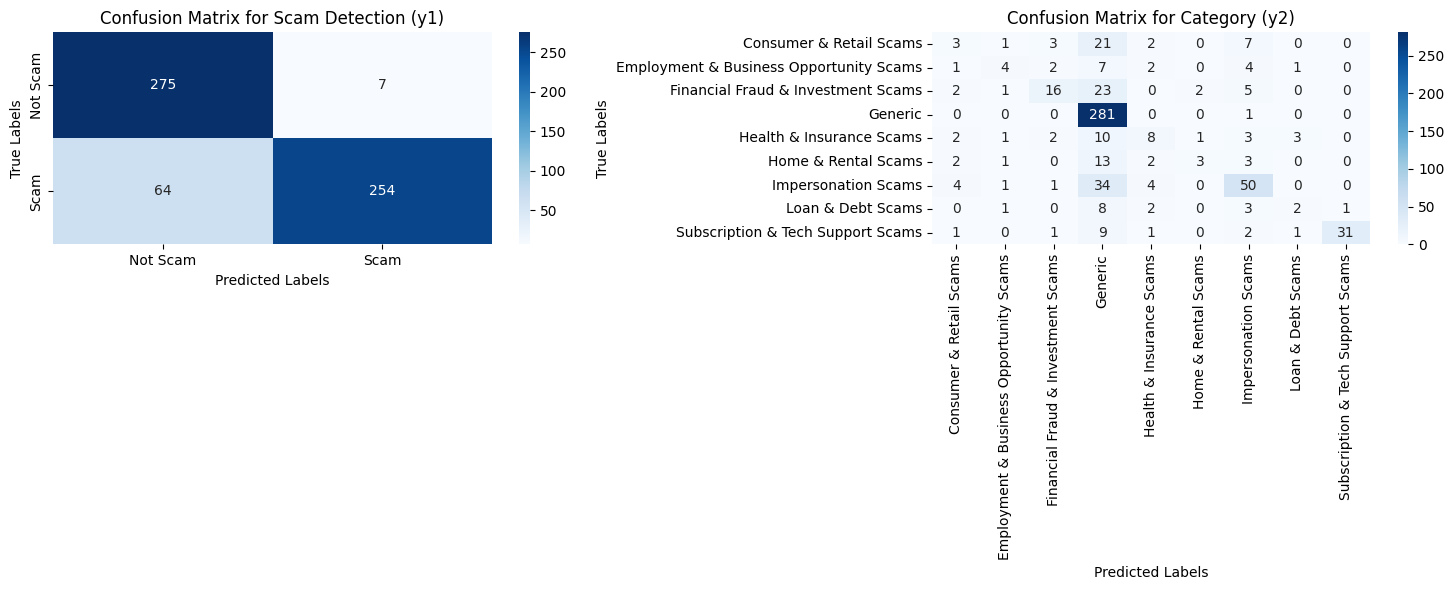

Confusion Matrix for TF-IDF:


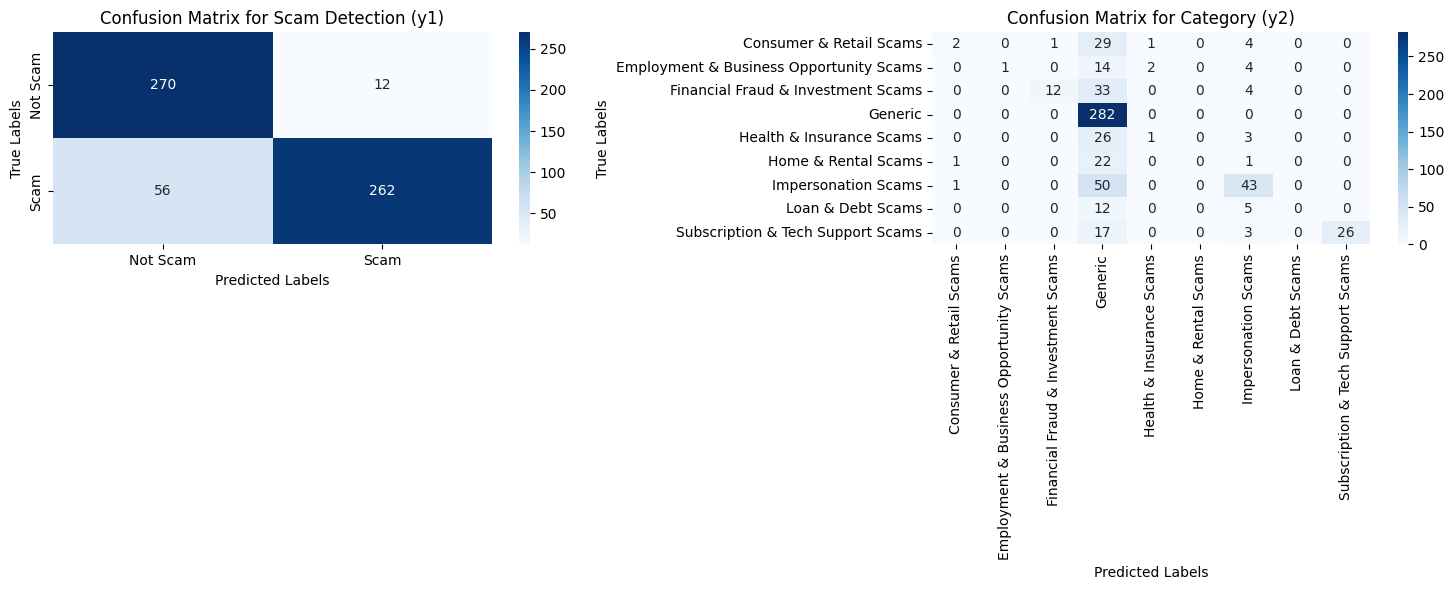

Confusion Matrix for Word2Vec:


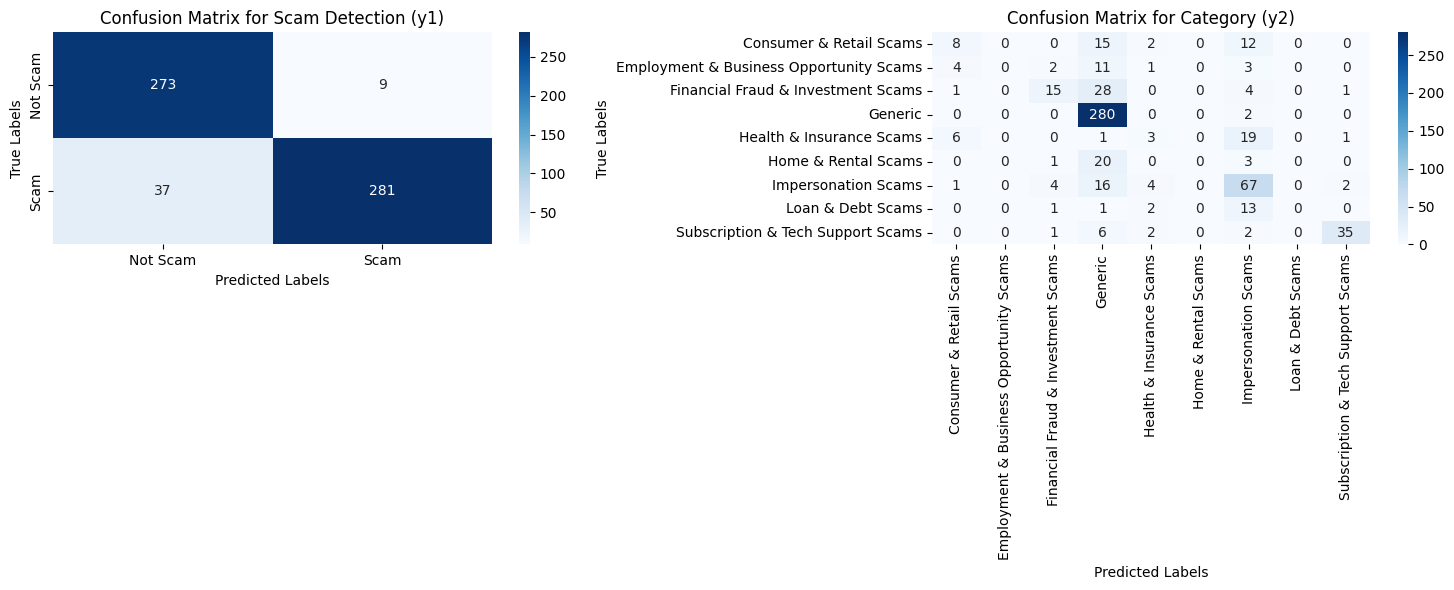

Confusion Matrix for DistilBERT:


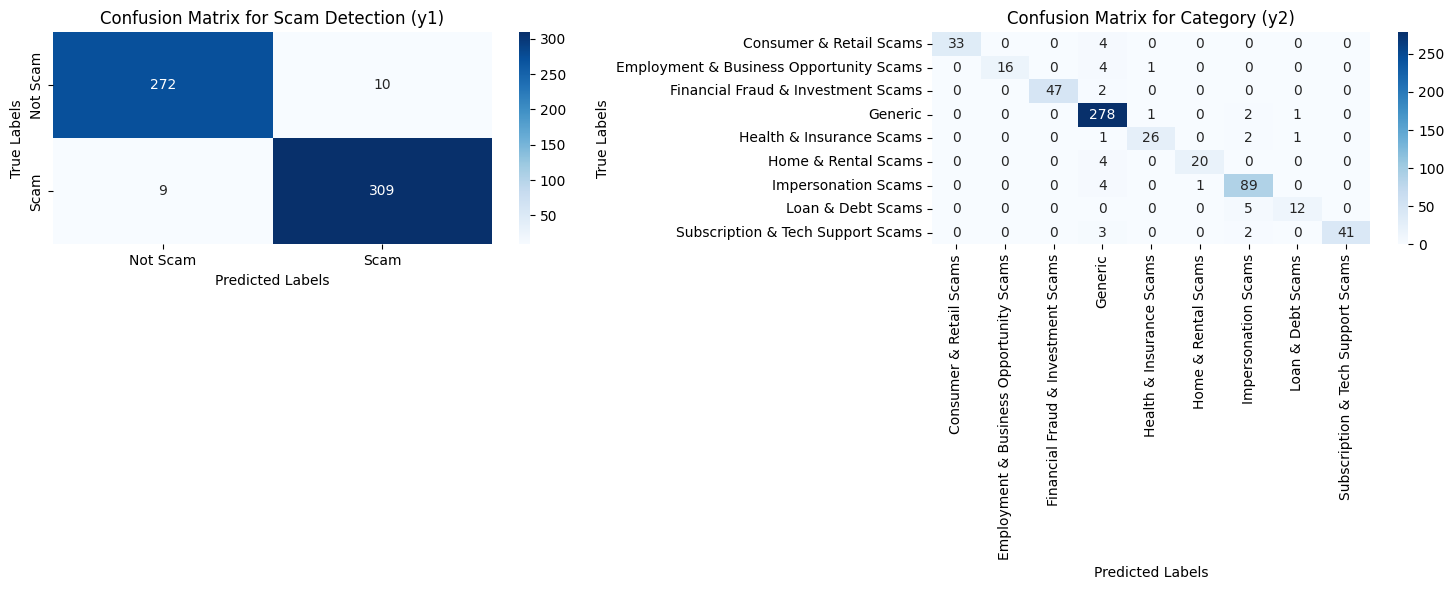

Confusion Matrix for SBERT:


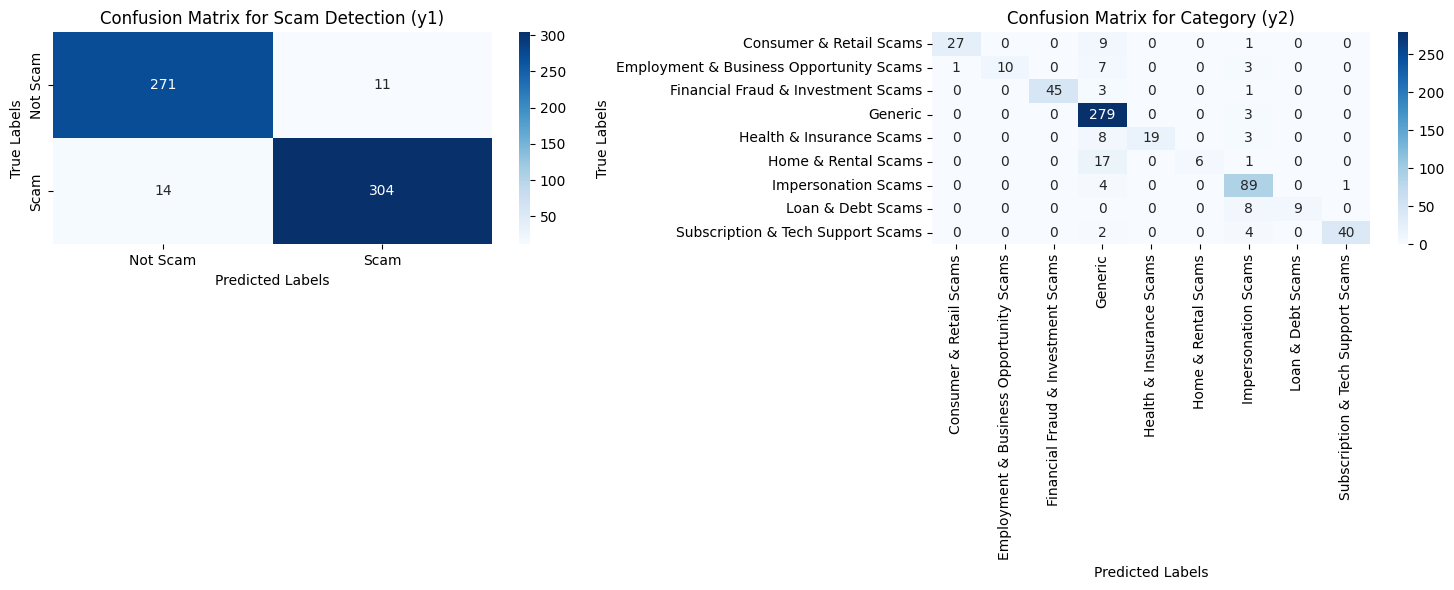

In [28]:
# For each embedding data
for embedding, data in embedding_data.items():
    print(f"Confusion Matrix for {embedding}:")

    # Create your models
    logistic_model_y1 = ClassificationModel(data["X_train"], data["y1_train"], multi_class_func='logistic')
    logistic_model_y2 = ClassificationModel(data["X_train"], data["y2_train"], multi_class_func='logistic')

    # Get predictions
    y_pred_1 = logistic_model_y1.predict(data["X_test"])
    y_pred_2 = logistic_model_y2.predict(data["X_test"])

    # Plot the confusion matrices
    fig = plot_dual_confusion_matrices(
        data["y1_test"], y_pred_1,
        data["y2_test"], y_pred_2,
        y2_labels=le,  # Your label encoder
        y2_title=f"Confusion Matrix for Category (y2)"
    )

    plt.show()

### 4.2. SVM 📏

In [29]:
# List to store results in a single row format
results = []

# Iterate through each embedding type and train the models
for embedding, data in embedding_data.items():
    print(f"\nEvaluating {embedding}...")

    row = {
        "Algorithm": "SVM",
        "Embedding": embedding,
    }

    for label_name, y_train, y_val in [("y1", data["y1_train"], data["y1_val"]),
                                       ("y2", data["y2_train"], data["y2_val"])]:

        # Train logistic regression model
        svm_model = ClassificationModel(data["X_train"], y_train, multi_class_func='svm')
        accuracy, precision, recall, f1, _, class_report = svm_model.evaluate(data["X_val"], y_val)

        print(f"{label_name} Classification Report for {embedding}:\n", class_report)

        # Store results in the row with unique column names
        row[f"Type"] = "Validation Set"
        row[f"{label_name}_Accuracy"] = round(accuracy, 4)
        row[f"{label_name}_Precision"] = round(precision, 4)
        row[f"{label_name}_Recall"] = round(recall, 4)
        row[f"{label_name}_F1_Score"] = round(f1, 4)

    # Append row to results list
    results.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Append results to the combined dataframe
combined_results_df = pd.concat([combined_results_df, results_df], ignore_index=True)

# Display results
results_df


Evaluating Count Vectorizer...
y1 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.76      0.95      0.85       295
           1       0.94      0.71      0.81       305

    accuracy                           0.83       600
   macro avg       0.85      0.83      0.83       600
weighted avg       0.85      0.83      0.83       600



/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

y2 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.14      0.02      0.04        46
           1       0.17      0.10      0.12        20
           2       0.68      0.42      0.52        36
           3       0.67      1.00      0.80       295
           4       0.17      0.03      0.06        30
           5       0.00      0.00      0.00        21
           6       0.56      0.50      0.53        92
           7       0.25      0.08      0.12        24
           8       0.96      0.67      0.79        36

    accuracy                           0.64       600
   macro avg       0.40      0.31      0.33       600
weighted avg       0.55      0.64      0.57       600


Evaluating TF-IDF...
y1 Classification Report for TF-IDF:
               precision    recall  f1-score   support

           0       0.85      0.95      0.90       295
           1       0.95      0.84      0.89       305

    accuracy           

Algorithm         Embedding            Type  y1_Accuracy  y1_Precision  \
0       SVM  Count Vectorizer  Validation Set       0.8283        0.9391   
1       SVM            TF-IDF  Validation Set       0.8950        0.9481   
2       SVM          Word2Vec  Validation Set       0.9000        0.9391   
3       SVM        DistilBERT  Validation Set       0.9550        0.9427   
4       SVM             SBERT  Validation Set       0.9850        0.9805   

   y1_Recall  y1_F1_Score  y2_Accuracy  y2_Precision  y2_Recall  y2_F1_Score  
0     0.7082       0.8075       0.6433        0.5505     0.6433       0.5699  
1     0.8393       0.8904       0.6867        0.6284     0.6867       0.6360  
2     0.8590       0.8973       0.6717        0.5979     0.6717       0.6109  
3     0.9705       0.9564       0.7517        0.7955     0.7517       0.7091  
4     0.9902       0.9853       0.9433        0.9449     0.9433       0.9409

In [30]:
# Do the same for the test set
results = []

# Iterate through each embedding type and train the models
for embedding, data in embedding_data.items():
    print(f"\nEvaluating {embedding}...")

    row = {
        "Algorithm": "SVM",
        "Embedding": embedding,
    }

    for label_name, y_train, y_test in [("y1", data["y1_train"], data["y1_test"]),
                                       ("y2", data["y2_train"], data["y2_test"])]:

        # Train logistic regression model
        svm_model = ClassificationModel(data["X_train"], y_train, multi_class_func='svm')
        accuracy, precision, recall, f1, _, class_report = svm_model.evaluate(data["X_test"], y_test)

        print(f"{label_name} Classification Report for {embedding}:\n", class_report)

        # Store results in the row with unique column names
        row[f"Type"] = "Test Set"
        row[f"{label_name}_Accuracy"] = round(accuracy, 4)
        row[f"{label_name}_Precision"] = round(precision, 4)
        row[f"{label_name}_Recall"] = round(recall, 4)
        row[f"{label_name}_F1_Score"] = round(f1, 4)

    # Append row to results list
    results.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Append results to the combined dataframe
combined_results_df = pd.concat([combined_results_df, results_df], ignore_index=True)

# Display results
results_df


Evaluating Count Vectorizer...
y1 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.75      0.97      0.85       282
           1       0.96      0.72      0.82       318

    accuracy                           0.83       600
   macro avg       0.86      0.84      0.83       600
weighted avg       0.86      0.83      0.83       600



/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

y2 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.12      0.03      0.04        37
           1       0.50      0.19      0.28        21
           2       0.65      0.27      0.38        49
           3       0.66      1.00      0.79       282
           4       0.15      0.07      0.09        30
           5       0.00      0.00      0.00        24
           6       0.59      0.52      0.55        94
           7       0.25      0.06      0.10        17
           8       0.97      0.72      0.82        46

    accuracy                           0.64       600
   macro avg       0.43      0.32      0.34       600
weighted avg       0.57      0.64      0.57       600


Evaluating TF-IDF...
y1 Classification Report for TF-IDF:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       282
           1       0.95      0.84      0.89       318

    accuracy           

Algorithm         Embedding      Type  y1_Accuracy  y1_Precision  y1_Recall  \
0       SVM  Count Vectorizer  Test Set       0.8350        0.9620     0.7170   
1       SVM            TF-IDF  Test Set       0.8933        0.9536     0.8396   
2       SVM          Word2Vec  Test Set       0.9283        0.9758     0.8868   
3       SVM        DistilBERT  Test Set       0.9450        0.9553     0.9403   
4       SVM             SBERT  Test Set       0.9833        0.9904     0.9780   

   y1_F1_Score  y2_Accuracy  y2_Precision  y2_Recall  y2_F1_Score  
0       0.8216       0.6417        0.5682     0.6417       0.5728  
1       0.8930       0.6483        0.5852     0.6483       0.5950  
2       0.9292       0.6883        0.6558     0.6883       0.6281  
3       0.9477       0.7850        0.8243     0.7850       0.7463  
4       0.9842       0.9717        0.9725     0.9717       0.9713

Confusion Matrix for Count Vectorizer:


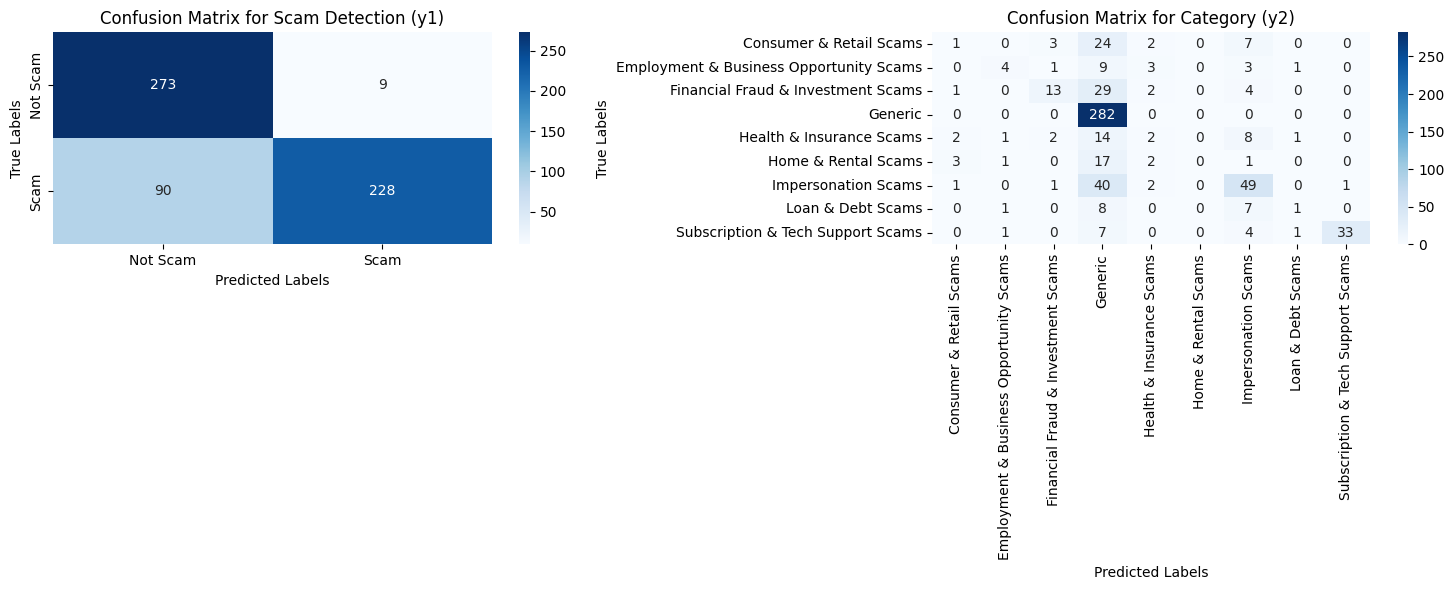

Confusion Matrix for TF-IDF:


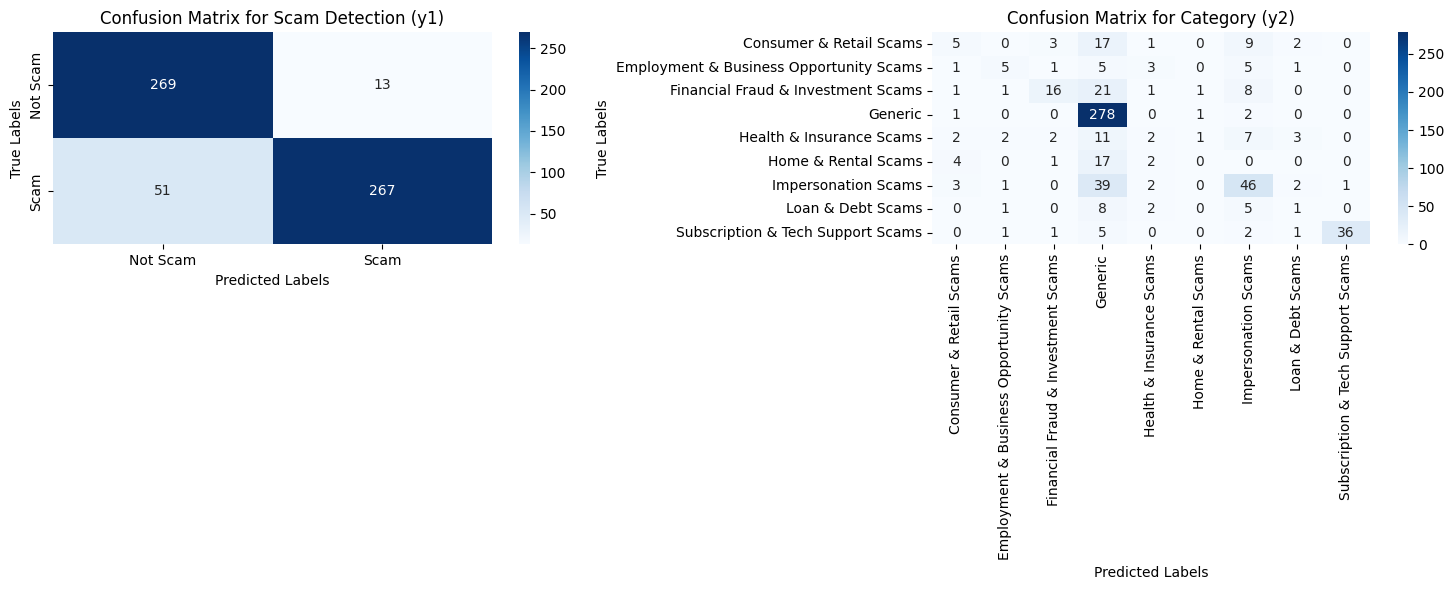

Confusion Matrix for Word2Vec:


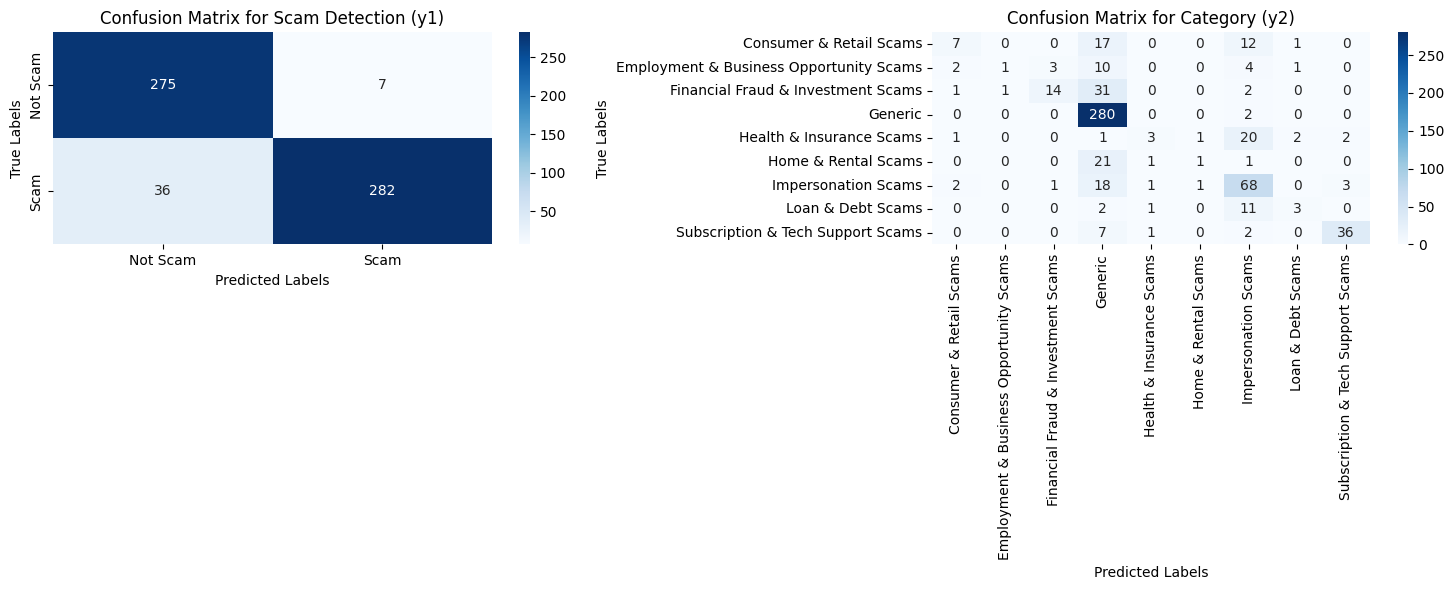

Confusion Matrix for DistilBERT:


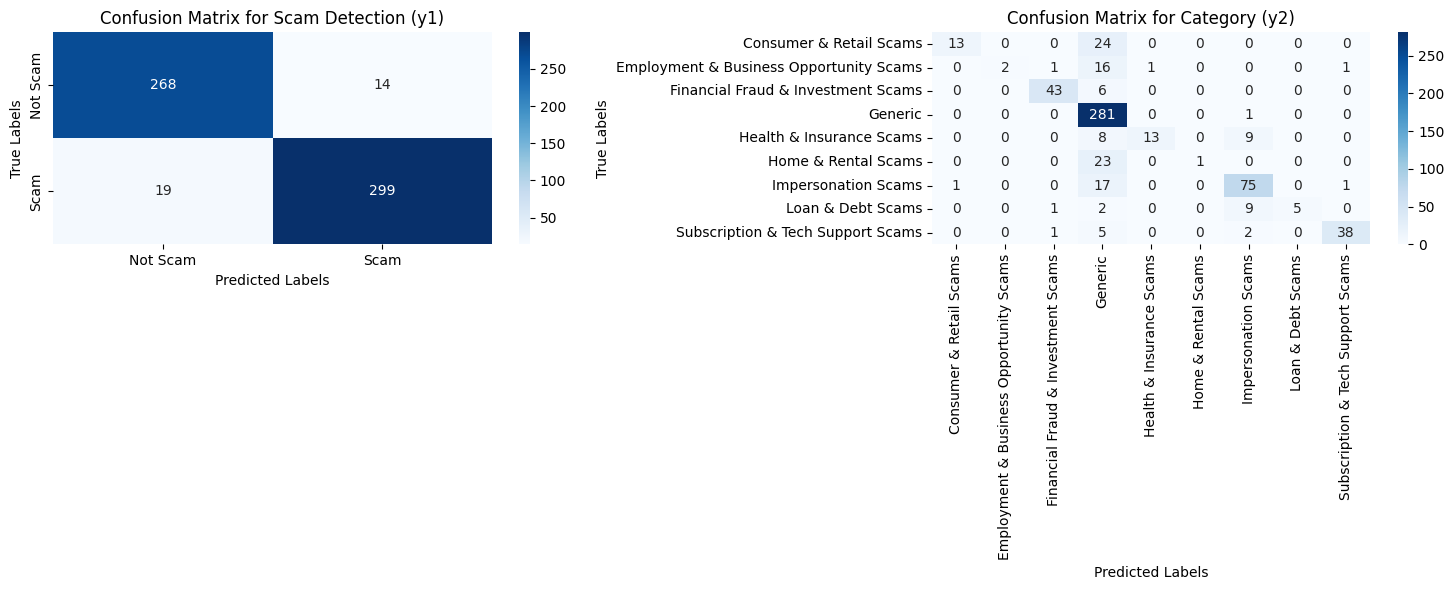

Confusion Matrix for SBERT:


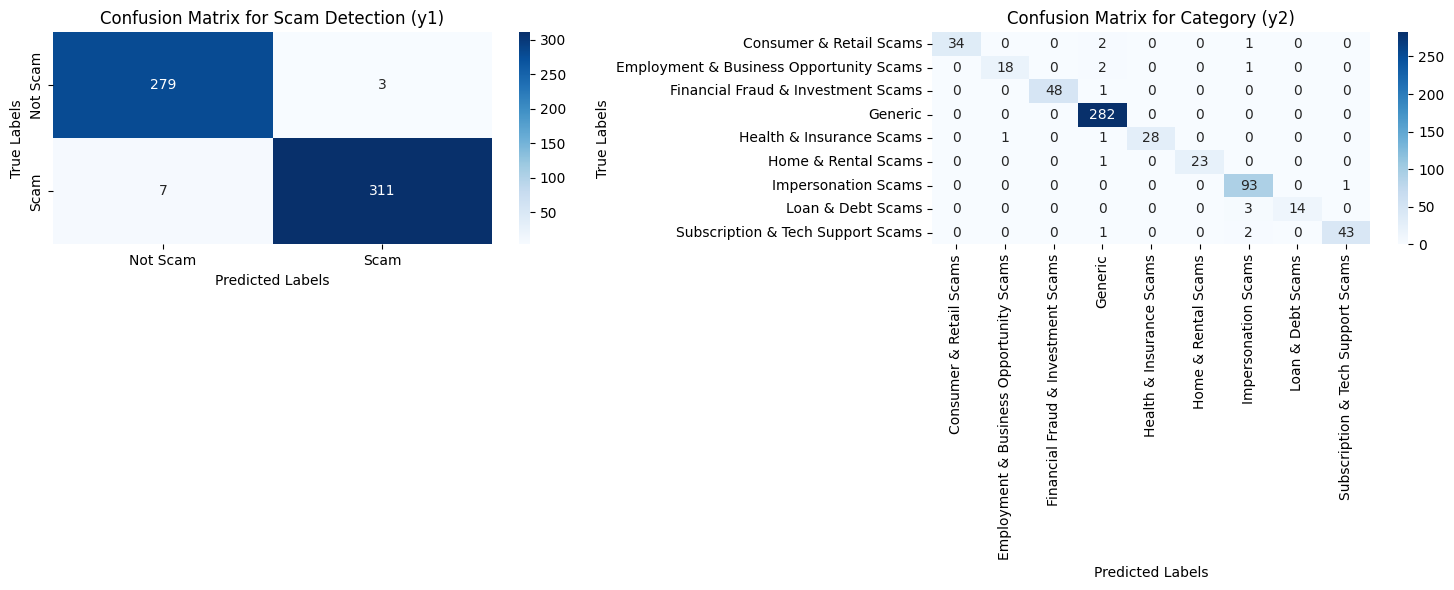

In [31]:
# For each embedding data, plot the confusion matrices
for embedding, data in embedding_data.items():
    print(f"Confusion Matrix for {embedding}:")

    # Create your models
    svm_model_y1 = ClassificationModel(data["X_train"], data["y1_train"], multi_class_func='svm')
    svm_model_y2 = ClassificationModel(data["X_train"], data["y2_train"], multi_class_func='svm')

    # Get predictions
    y_pred_1 = svm_model_y1.predict(data["X_test"])
    y_pred_2 = svm_model_y2.predict(data["X_test"])

    # Plot the confusion matrices
    fig = plot_dual_confusion_matrices(
        data["y1_test"], y_pred_1,
        data["y2_test"], y_pred_2,
        y2_labels=le,  # Your label encoder
        y2_title=f"Confusion Matrix for Category (y2)"
    )

    plt.show()

### 4.3. Random Forest 🌲

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# List to store results in a single row format
results = []

# Iterate through each embedding type and train the models
for embedding, data in embedding_data.items():
    print(f"\nEvaluating {embedding}...")

    row = {
        "Algorithm": "Random Forest",
        "Embedding": embedding,
    }

    for label_name, y_train, y_val in [("y1", data["y1_train"], data["y1_val"]),
                                       ("y2", data["y2_train"], data["y2_val"])]:

        # Initialize Random Forest Classifier
        RandomForest = RandomForestClassifier(
            n_estimators=100, random_state=42, max_depth=100, oob_score=True, bootstrap=True
        )

        # Train the Random Forest model for the current label
        RandomForest.fit(data["X_train"], y_train)
        y_pred = RandomForest.predict(data["X_val"])

        # Calculate metrics based on whether it's binary or multi-class
        if len(set(y_val)) == 2:  # Binary classification (e.g., scam vs. not scam)
            precision = precision_score(y_val, y_pred, average='binary', zero_division=0)
            recall = recall_score(y_val, y_pred, average='binary', zero_division=0)
            f1 = f1_score(y_val, y_pred, average='binary', zero_division=0)
        else:  # Multi-class classification (e.g., call scam, email scam, etc.)
            precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)  # Weighted average for multi-class
            recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

        accuracy = accuracy_score(y_val, y_pred)

        print(f"{label_name} Classification Report for {embedding}:\n", classification_report(y_val, y_pred))

        # Store results in the row with unique column names
        row[f"Type"] = "Validation Set"
        row[f"{label_name}_Accuracy"] = round(accuracy, 4)
        row[f"{label_name}_Precision"] = round(precision, 4)
        row[f"{label_name}_Recall"] = round(recall, 4)
        row[f"{label_name}_F1_Score"] = round(f1, 4)

    # Append row to results list
    results.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Append results to the combined dataframe
combined_results_df = pd.concat([combined_results_df, results_df], ignore_index=True)

# Display results
results_df


Evaluating Count Vectorizer...
y1 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.80      0.95      0.87       295
           1       0.94      0.77      0.85       305

    accuracy                           0.86       600
   macro avg       0.87      0.86      0.86       600
weighted avg       0.87      0.86      0.86       600

y2 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.31      0.28      0.30        46
           1       0.29      0.25      0.27        20
           2       0.53      0.53      0.53        36
           3       0.77      0.97      0.86       295
           4       0.28      0.17      0.21        30
           5       0.33      0.19      0.24        21
           6       0.74      0.52      0.61        92
           7       0.23      0.12      0.16        24
           8       0.96      0.72      0.83        36

   

/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

Algorithm         Embedding            Type  y1_Accuracy  y1_Precision  \
0  Random Forest  Count Vectorizer  Validation Set       0.8600        0.9438   
1  Random Forest            TF-IDF  Validation Set       0.8650        0.9553   
2  Random Forest          Word2Vec  Validation Set       0.9550        0.9696   
3  Random Forest        DistilBERT  Validation Set       0.9550        0.9603   
4  Random Forest             SBERT  Validation Set       0.9467        0.9627   

   y1_Recall  y1_F1_Score  y2_Accuracy  y2_Precision  y2_Recall  y2_F1_Score  
0     0.7705       0.8484       0.6817        0.6510     0.6817       0.6549  
1     0.7705       0.8530       0.6900        0.6441     0.6900       0.6528  
2     0.9410       0.9551       0.7317        0.6762     0.7317       0.6906  
3     0.9508       0.9555       0.7583        0.8065     0.7583       0.7196  
4     0.9311       0.9467       0.7800        0.7885     0.7800       0.7442

#### Test Set Metrics

In [33]:
# Do the same for test set
results = []

# Iterate through each embedding type and train the models
for embedding, data in embedding_data.items():
    print(f"\nEvaluating {embedding}...")

    row = {
        "Algorithm": "Random Forest",
        "Embedding": embedding,
    }

    for label_name, y_train, y_test in [("y1", data["y1_train"], data["y1_test"]),
                                       ("y2", data["y2_train"], data["y2_test"])]:

        # Initialize Random Forest Classifier
        RandomForest = RandomForestClassifier(
            n_estimators=100, random_state=42, max_depth=100, oob_score=True, bootstrap=True
        )

        # Train the Random Forest model for the current label
        RandomForest.fit(data["X_train"], y_train)
        y_pred = RandomForest.predict(data["X_test"])

        # Calculate metrics based on whether it's binary or multi-class
        if len(set(y_test)) == 2:  # Binary classification (e.g., scam vs. not scam)
            precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
            recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
        else:  # Multi-class classification (e.g., call scam, email scam, etc.)
            precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)  # Weighted average for multi-class
            recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        accuracy = accuracy_score(y_test, y_pred)

        # Print classification report
        print(f"{label_name} Classification Report for {embedding}:\n", classification_report(y_test, y_pred))

        # Store results in the row with unique column names
        row[f"Type"] = "Test Set"
        row[f"{label_name}_Accuracy"] = round(accuracy, 4)
        row[f"{label_name}_Precision"] = round(precision, 4)
        row[f"{label_name}_Recall"] = round(recall, 4)
        row[f"{label_name}_F1_Score"] = round(f1, 4)

    # Append row to results list
    results.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Append results to the combined dataframe
combined_results_df = pd.concat([combined_results_df, results_df], ignore_index=True)

# Display results
results_df


Evaluating Count Vectorizer...
y1 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.78      0.97      0.87       282
           1       0.97      0.76      0.85       318

    accuracy                           0.86       600
   macro avg       0.87      0.86      0.86       600
weighted avg       0.88      0.86      0.86       600

y2 Classification Report for Count Vectorizer:
               precision    recall  f1-score   support

           0       0.12      0.08      0.10        37
           1       0.40      0.29      0.33        21
           2       0.55      0.33      0.41        49
           3       0.76      0.98      0.85       282
           4       0.19      0.13      0.16        30
           5       0.24      0.17      0.20        24
           6       0.68      0.55      0.61        94
           7       0.16      0.18      0.17        17
           8       0.97      0.74      0.84        46

   

/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

y2 Classification Report for DistilBERT:
               precision    recall  f1-score   support

           0       1.00      0.41      0.58        37
           1       1.00      0.10      0.17        21
           2       1.00      0.84      0.91        49
           3       0.73      0.99      0.84       282
           4       0.93      0.43      0.59        30
           5       0.00      0.00      0.00        24
           6       0.81      0.88      0.85        94
           7       0.83      0.29      0.43        17
           8       1.00      0.80      0.89        46

    accuracy                           0.79       600
   macro avg       0.81      0.53      0.59       600
weighted avg       0.80      0.79      0.75       600


Evaluating SBERT...
y1 Classification Report for SBERT:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       282
           1       0.97      0.95      0.96       318

    accuracy                   

Algorithm         Embedding      Type  y1_Accuracy  y1_Precision  \
0  Random Forest  Count Vectorizer  Test Set       0.8583        0.9679   
1  Random Forest            TF-IDF  Test Set       0.8600        0.9643   
2  Random Forest          Word2Vec  Test Set       0.9383        0.9763   
3  Random Forest        DistilBERT  Test Set       0.9600        0.9742   
4  Random Forest             SBERT  Test Set       0.9583        0.9681   

   y1_Recall  y1_F1_Score  y2_Accuracy  y2_Precision  y2_Recall  y2_F1_Score  
0     0.7579       0.8501       0.6617        0.6269     0.6617       0.6320  
1     0.7642       0.8526       0.6700        0.6289     0.6700       0.6342  
2     0.9057       0.9396       0.7500        0.7415     0.7500       0.7248  
3     0.9497       0.9618       0.7933        0.7961     0.7933       0.7548  
4     0.9528       0.9604       0.8200        0.8573     0.8200       0.7964

Confusion Matrix for Count Vectorizer:


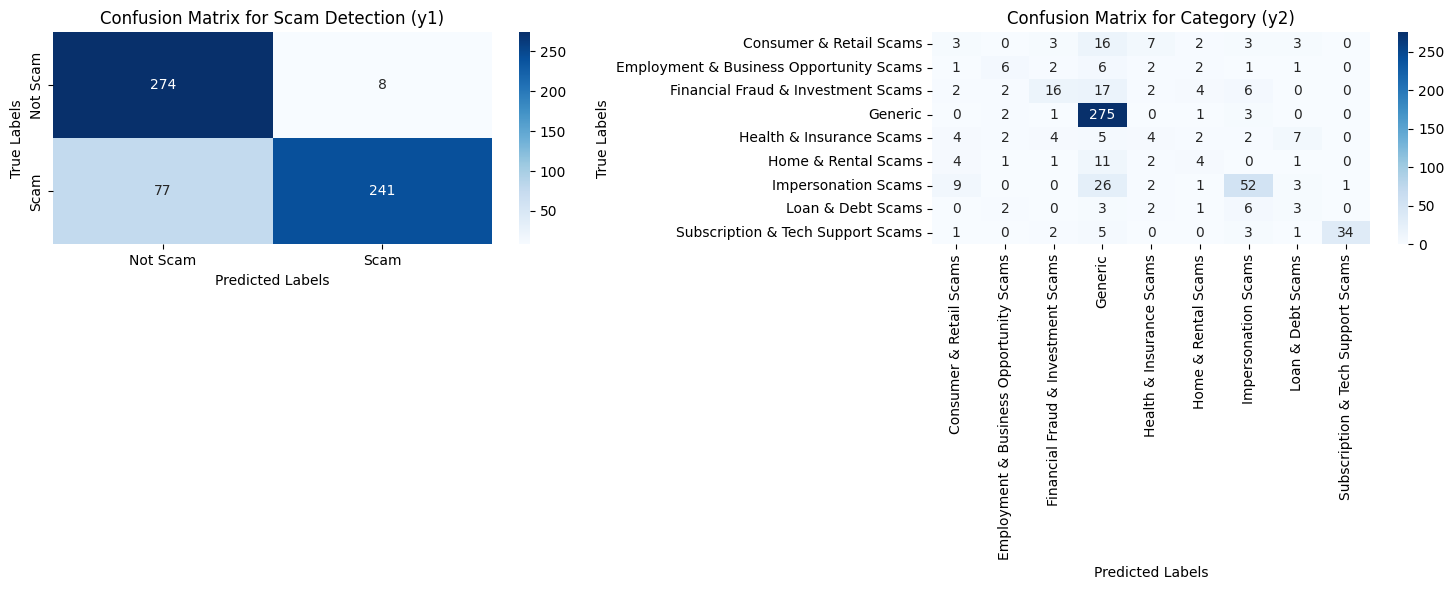

Confusion Matrix for TF-IDF:


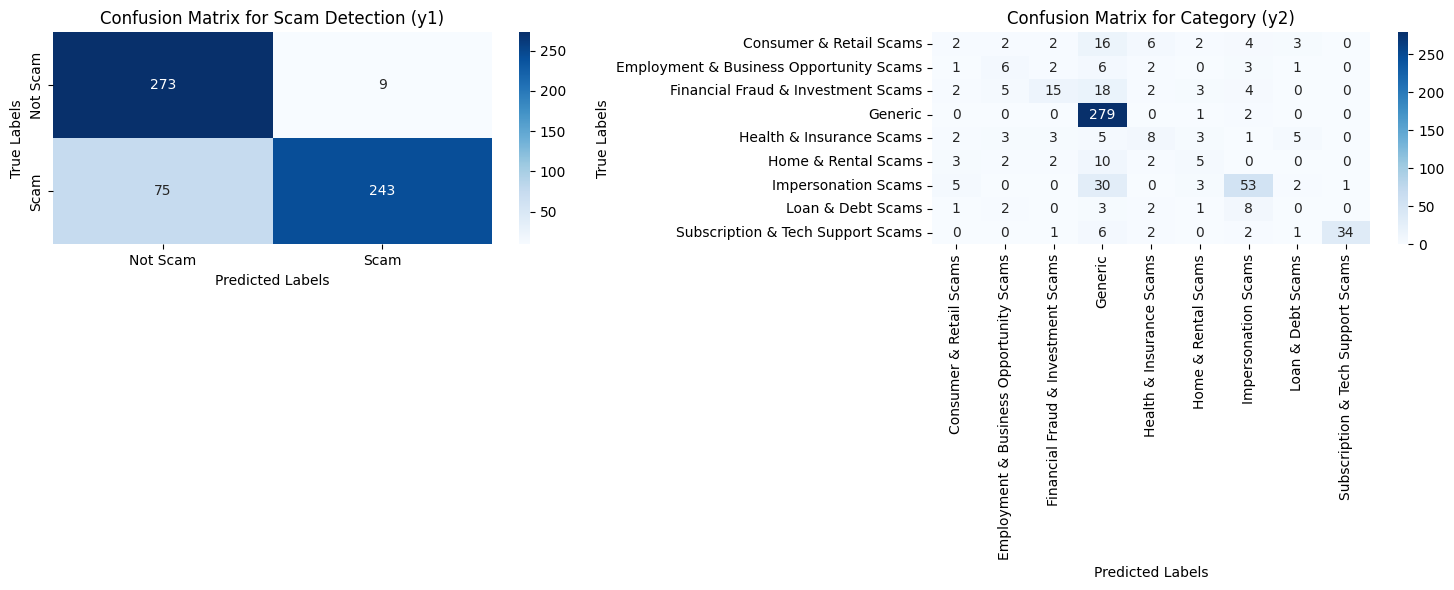

Confusion Matrix for Word2Vec:


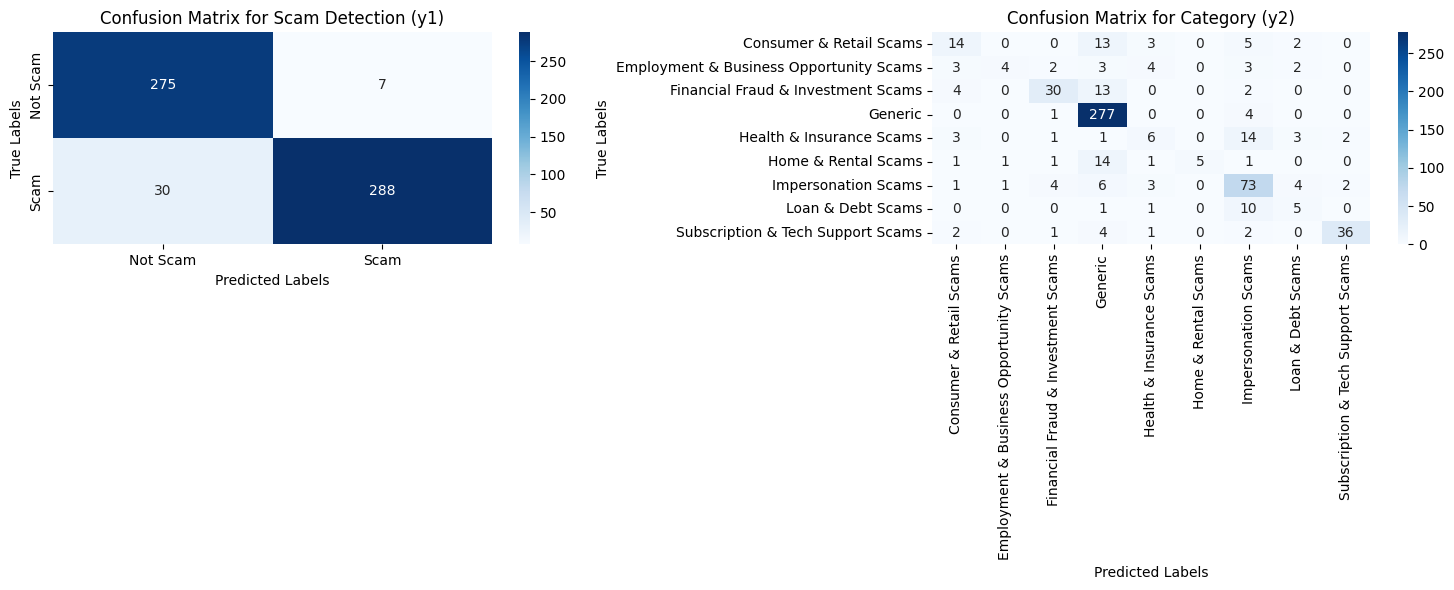

Confusion Matrix for DistilBERT:


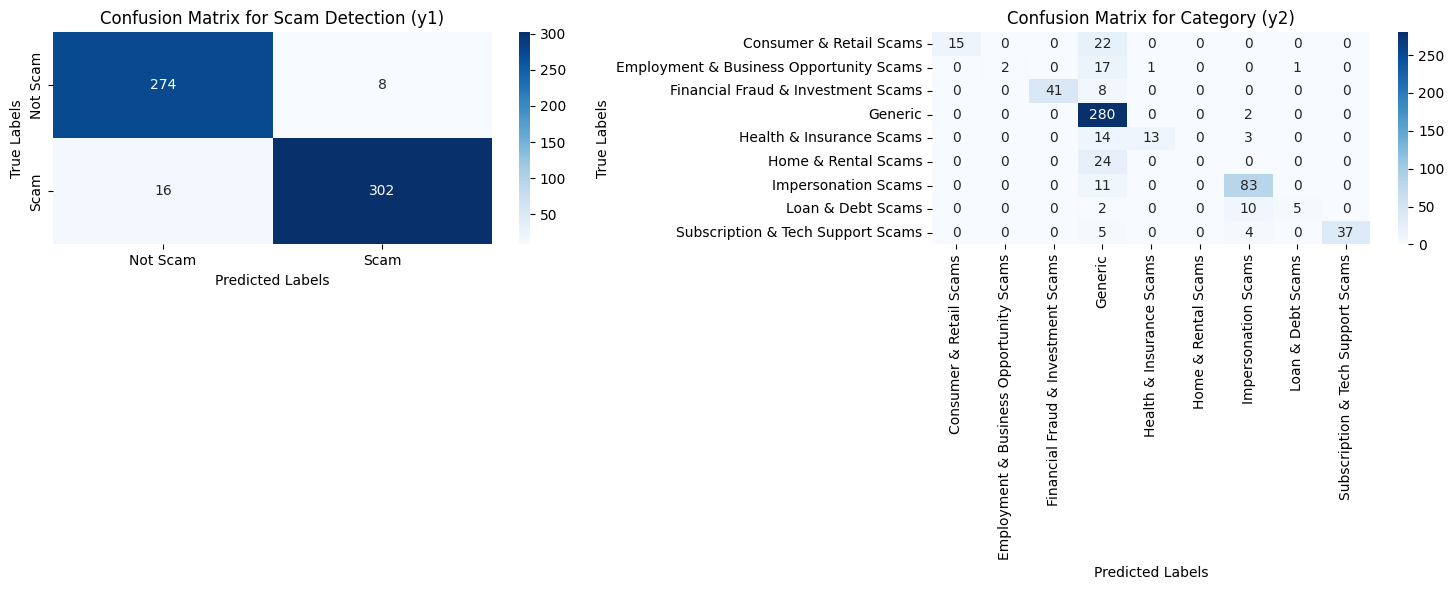

Confusion Matrix for SBERT:


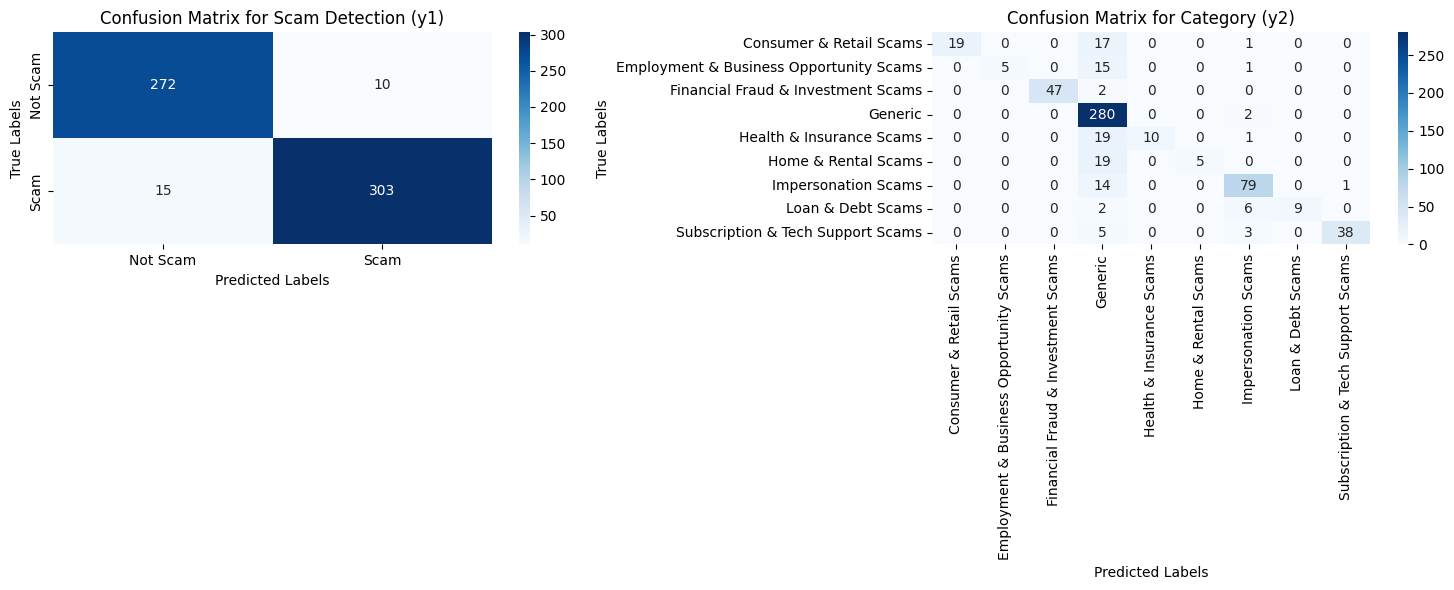

In [34]:
# For each embedding data, plot the confusion matrices for test set
for embedding, data in embedding_data.items():
    print(f"Confusion Matrix for {embedding}:")

    # Create your models
    RandomForest_model_y1 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=100, oob_score=True, bootstrap=True).fit(data["X_train"], data["y1_train"])
    RandomForest_model_y2 = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=100, oob_score=True, bootstrap=True).fit(data["X_train"], data["y2_train"])

    # Get predictions
    y_pred_1 = RandomForest_model_y1.predict(data["X_test"])
    y_pred_2 = RandomForest_model_y2.predict(data["X_test"])

    # Plot the confusion matrices
    fig = plot_dual_confusion_matrices(
        data["y1_test"], y_pred_1,
        data["y2_test"], y_pred_2,
        y2_labels=le,  # Your label encoder
        y2_title=f"Confusion Matrix for Category (y2)"
    )

    plt.show()


### 4.4. Adaboost 🔄

First, import modules

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score, log_loss, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import math

#### AdaBoost Classifier

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, classification_report

# List to store results in a single row format
results = []

# Iterate through each embedding type and train the models
for embedding, data in embedding_data.items():
    print(f"\nEvaluating {embedding}...")

    row = {
        "Algorithm": "AdaBoost",
        "Embedding": embedding,
    }

    for label_name, y_train, y_val in [("y1", data["y1_train"], data["y1_val"]),
                                       ("y2", data["y2_train"], data["y2_val"])]:

        # Initialize AdaBoost Model
        AdaBoost = AdaBoostClassifier(n_estimators=100, random_state=42)

        # Train the AdaBoost model for the current label
        AdaBoost.fit(data["X_train"], y_train)

        # Predictions on Validation Set
        y_val_pred = AdaBoost.predict(data["X_val"])
        y_val_prob = AdaBoost.predict_proba(data["X_val"])

        # Compute Accuracy
        train_accuracy = accuracy_score(y_val, y_val_pred)

        # Compute Precision, Recall, and F1 Score (binary or multi-class)
        if len(set(y_val)) == 2:  # Binary classification (e.g., scam vs. not scam)
            train_precision = precision_score(y_val, y_val_pred, average='binary', zero_division=0)
            train_recall = recall_score(y_val, y_val_pred, average='binary', zero_division=0)
            train_f1 = f1_score(y_val, y_val_pred, average='binary', zero_division=0)
        else:  # Multi-class classification (e.g., call scam, email scam, etc.)
            train_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
            train_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
            train_f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)

        # Compute Log Loss (for probability-based evaluation)
        train_log_loss = log_loss(y_val, y_val_prob)

        # Classification Report (optional, just for visualization)
        class_report = classification_report(y_val, y_val_pred)

        # Print results for this label and embedding
        print(f"{label_name} Classification Report for {embedding}:\n")
        print(f"Training Accuracy on Validation Set: {train_accuracy:.4f}")
        print(f"Training Log Loss: {train_log_loss:.4f}")
        print(f"Classification Report:\n{class_report}")

        # Store results in the row with unique column names
        row[f"Type"] = "Validation Set"
        row[f"{label_name}_Accuracy"] = round(train_accuracy, 4)
        row[f"{label_name}_Precision"] = round(train_precision, 4)
        row[f"{label_name}_Recall"] = round(train_recall, 4)
        row[f"{label_name}_F1_Score"] = round(train_f1, 4)

    # Append row to results list
    results.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Append results to the combined dataframe
combined_results_df = pd.concat([combined_results_df, results_df], ignore_index=True)

# Display results
results_df


Evaluating Count Vectorizer...
y1 Classification Report for Count Vectorizer:

Training Accuracy on Validation Set: 0.7217
Training Log Loss: 0.6465
Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       295
           1       1.00      0.45      0.62       305

    accuracy                           0.72       600
   macro avg       0.82      0.73      0.70       600
weighted avg       0.82      0.72      0.70       600



/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

y2 Classification Report for Count Vectorizer:

Training Accuracy on Validation Set: 0.5333
Training Log Loss: 2.1890
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        36
           3       0.51      1.00      0.68       295
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        21
           6       1.00      0.23      0.37        92
           7       0.00      0.00      0.00        24
           8       1.00      0.11      0.20        36

    accuracy                           0.53       600
   macro avg       0.28      0.15      0.14       600
weighted avg       0.47      0.53      0.40       600


Evaluating TF-IDF...
y1 Classification Report for TF-IDF:

Training Accuracy on Validation Set: 0.7250
Training Log Loss: 0.6454
Classification Report:
 

/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

y2 Classification Report for TF-IDF:

Training Accuracy on Validation Set: 0.5333
Training Log Loss: 2.1892
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        36
           3       0.51      1.00      0.68       295
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        21
           6       1.00      0.23      0.37        92
           7       0.00      0.00      0.00        24
           8       1.00      0.11      0.20        36

    accuracy                           0.53       600
   macro avg       0.28      0.15      0.14       600
weighted avg       0.47      0.53      0.40       600


Evaluating Word2Vec...
y1 Classification Report for Word2Vec:

Training Accuracy on Validation Set: 0.9633
Training Log Loss: 0.4889
Classification Report:
       

Algorithm         Embedding            Type  y1_Accuracy  y1_Precision  \
0  AdaBoost  Count Vectorizer  Validation Set       0.7217        1.0000   
1  AdaBoost            TF-IDF  Validation Set       0.7250        1.0000   
2  AdaBoost          Word2Vec  Validation Set       0.9633        0.9732   
3  AdaBoost        DistilBERT  Validation Set       0.9600        0.9547   
4  AdaBoost             SBERT  Validation Set       0.9550        0.9603   

   y1_Recall  y1_F1_Score  y2_Accuracy  y2_Precision  y2_Recall  y2_F1_Score  
0     0.4525       0.6230       0.5333        0.4656     0.5333       0.4024  
1     0.4590       0.6292       0.5333        0.4656     0.5333       0.4024  
2     0.9541       0.9636       0.6183        0.6131     0.6183       0.6085  
3     0.9672       0.9609       0.6867        0.7042     0.6867       0.6484  
4     0.9508       0.9555       0.6567        0.7152     0.6567       0.5961

Test Set Metrics

In [37]:
# Do the same for test set
results = []

# Iterate through each embedding type and train the models
for embedding, data in embedding_data.items():
    print(f"\nEvaluating {embedding}...")

    row = {
        "Algorithm": "AdaBoost",
        "Embedding": embedding,
    }

    for label_name, y_train, y_test in [("y1", data["y1_train"], data["y1_test"]),
                                       ("y2", data["y2_train"], data["y2_test"])]:

        # Initialize AdaBoost Model
        AdaBoost = AdaBoostClassifier(n_estimators=100, random_state=42)

        # Train the AdaBoost model for the current label
        AdaBoost.fit(data["X_train"], y_train)

        # Predictions on Test Data
        y_test_pred = AdaBoost.predict(data["X_test"])
        y_test_prob = AdaBoost.predict_proba(data["X_test"])

        # Compute Accuracy
        test_accuracy = accuracy_score(y_test, y_test_pred)

        # Compute Precision, Recall, and F1 Score (binary or multi-class)
        if len(set(y_test)) == 2:  # Binary classification (e.g., scam vs. not scam)
            test_precision = precision_score(y_test, y_test_pred, average='binary')
            test_recall = recall_score(y_test, y_test_pred, average='binary')
            test_f1 = f1_score(y_test, y_test_pred, average='binary')
        else:  # Multi-class classification (e.g., call scam, email scam, etc.)
            test_precision = precision_score(y_test, y_test_pred, average='weighted')
            test_recall = recall_score(y_test, y_test_pred, average='weighted')
            test_f1 = f1_score(y_test, y_test_pred, average='weighted')

        # Compute Log Loss (for probability-based evaluation)
        test_log_loss = log_loss(y_test, y_test_prob)

        # Classification Report (optional, just for visualization)
        class_report = classification_report(y_test, y_test_pred)

        # Print results for this label and embedding
        print(f"{label_name} Classification Report for {embedding}:\n")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Log Loss: {test_log_loss:.4f}")
        print(f"Classification Report:\n{class_report}")

        # Store results in the row with unique column names
        row[f"Type"] = "Test Set"
        row[f"{label_name}_Accuracy"] = round(test_accuracy, 4)
        row[f"{label_name}_Precision"] = round(test_precision, 4)
        row[f"{label_name}_Recall"] = round(test_recall, 4)
        row[f"{label_name}_F1_Score"] = round(test_f1, 4)

    # Append row to results list
    results.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Append results to the combined dataframe
combined_results_df = pd.concat([combined_results_df, results_df], ignore_index=True)

# Display results
results_df


Evaluating Count Vectorizer...
y1 Classification Report for Count Vectorizer:

Test Accuracy: 0.7300
Test Log Loss: 0.6503
Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       282
           1       0.99      0.49      0.66       318

    accuracy                           0.73       600
   macro avg       0.81      0.75      0.72       600
weighted avg       0.83      0.73      0.71       600



/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

y2 Classification Report for Count Vectorizer:

Test Accuracy: 0.5317
Test Log Loss: 2.1892
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        49
           3       0.50      1.00      0.67       282
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        24
           6       1.00      0.23      0.38        94
           7       0.00      0.00      0.00        17
           8       1.00      0.33      0.49        46

    accuracy                           0.53       600
   macro avg       0.28      0.17      0.17       600
weighted avg       0.47      0.53      0.41       600


Evaluating TF-IDF...
y1 Classification Report for TF-IDF:

Test Accuracy: 0.7383
Test Log Loss: 0.6490
Classification Report:
              precision    recall  f1-score   support

/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/farhan/Desktop/Machine Learning INF2008/project/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

y2 Classification Report for TF-IDF:

Test Accuracy: 0.5267
Test Log Loss: 2.1894
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        49
           3       0.50      1.00      0.67       282
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        24
           6       1.00      0.23      0.38        94
           7       0.00      0.00      0.00        17
           8       1.00      0.26      0.41        46

    accuracy                           0.53       600
   macro avg       0.28      0.17      0.16       600
weighted avg       0.47      0.53      0.40       600


Evaluating Word2Vec...
y1 Classification Report for Word2Vec:

Test Accuracy: 0.9533
Test Log Loss: 0.4944
Classification Report:
              precision    recall  f1-score   support

    

Algorithm         Embedding      Type  y1_Accuracy  y1_Precision  y1_Recall  \
0  AdaBoost  Count Vectorizer  Test Set       0.7300        0.9937     0.4937   
1  AdaBoost            TF-IDF  Test Set       0.7383        0.9939     0.5094   
2  AdaBoost          Word2Vec  Test Set       0.9533        0.9677     0.9434   
3  AdaBoost        DistilBERT  Test Set       0.9500        0.9706     0.9340   
4  AdaBoost             SBERT  Test Set       0.9567        0.9650     0.9528   

   y1_F1_Score  y2_Accuracy  y2_Precision  y2_Recall  y2_F1_Score  
0       0.6597       0.5317        0.4688     0.5317       0.4108  
1       0.6736       0.5267        0.4675     0.5267       0.4037  
2       0.9554       0.6650        0.6628     0.6650       0.6594  
3       0.9519       0.6883        0.6884     0.6883       0.6559  
4       0.9589       0.6767        0.7183     0.6767       0.6267

Confusion Matrix for Count Vectorizer:


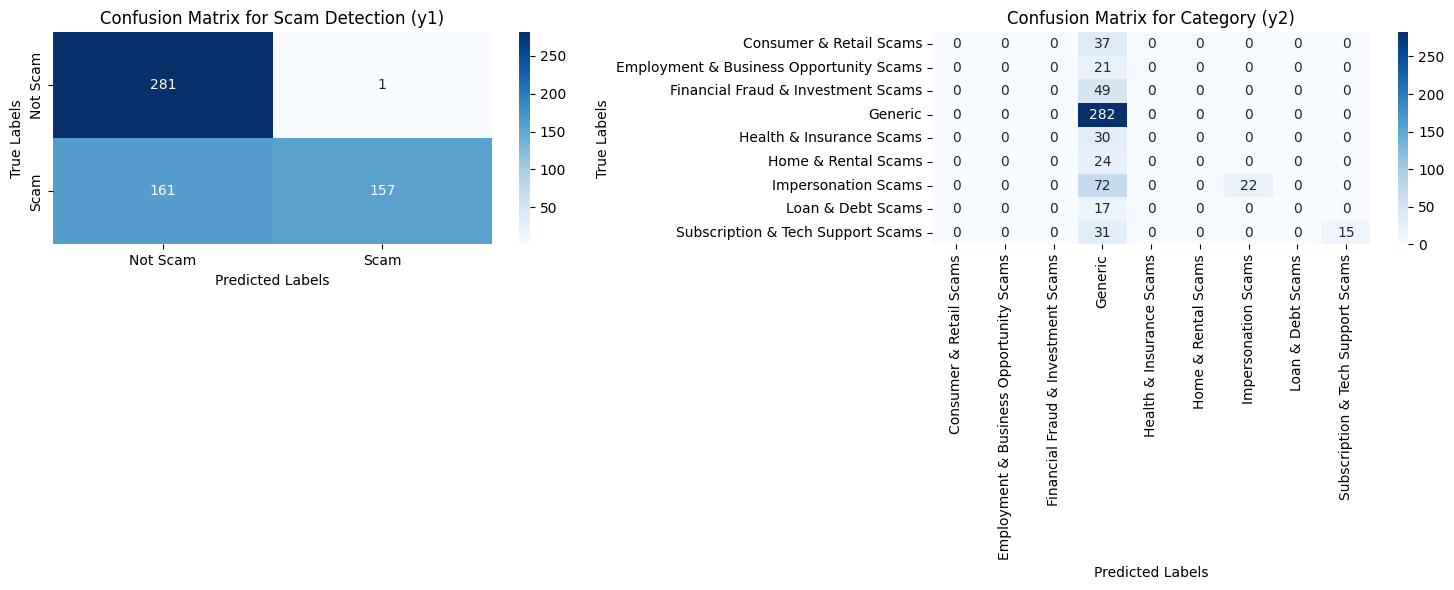

Confusion Matrix for TF-IDF:


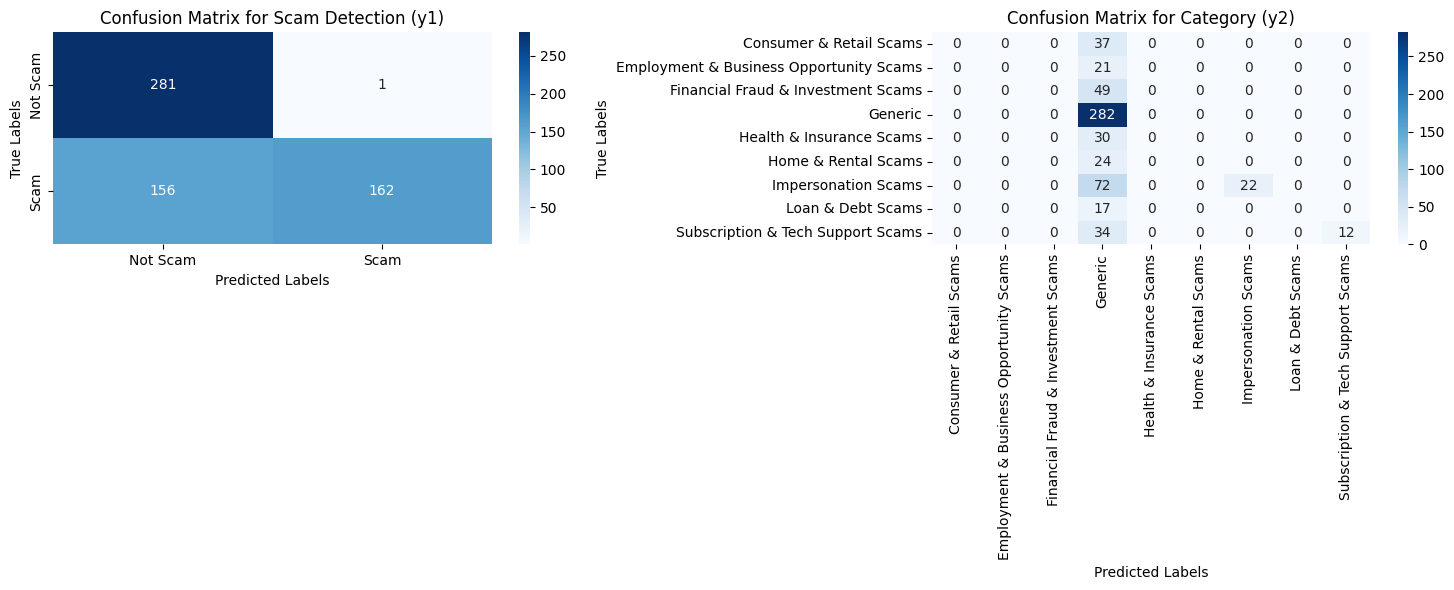

Confusion Matrix for Word2Vec:


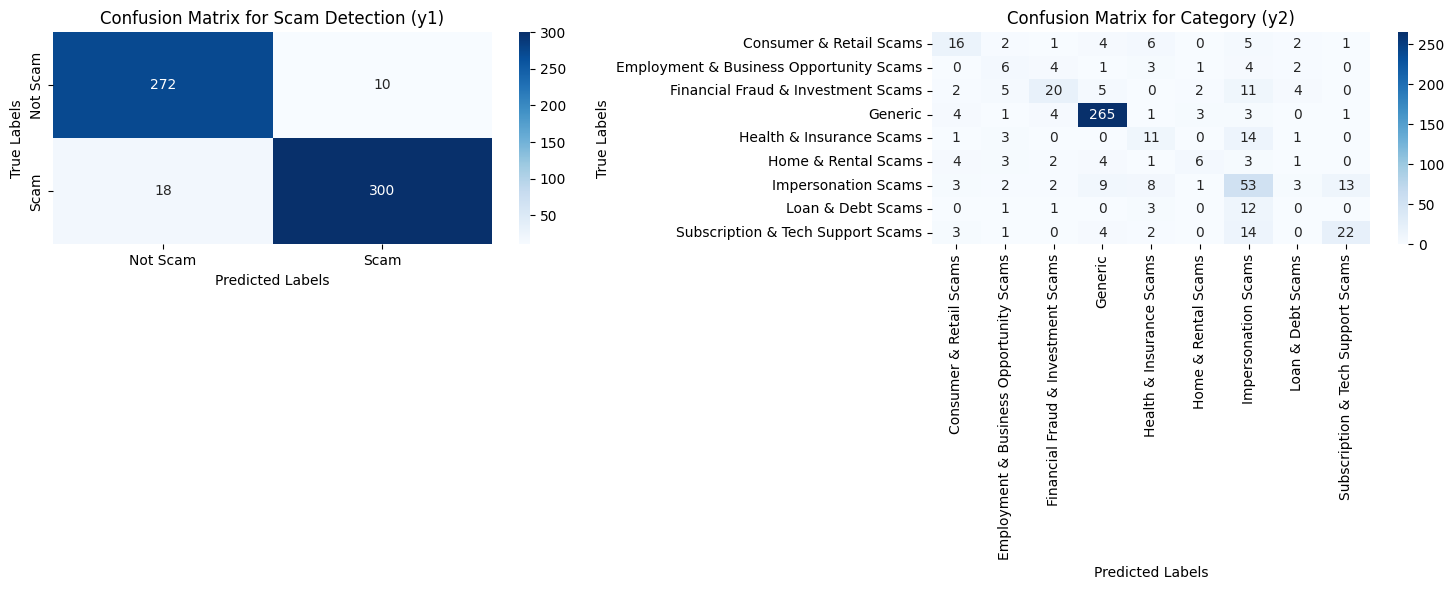

Confusion Matrix for DistilBERT:


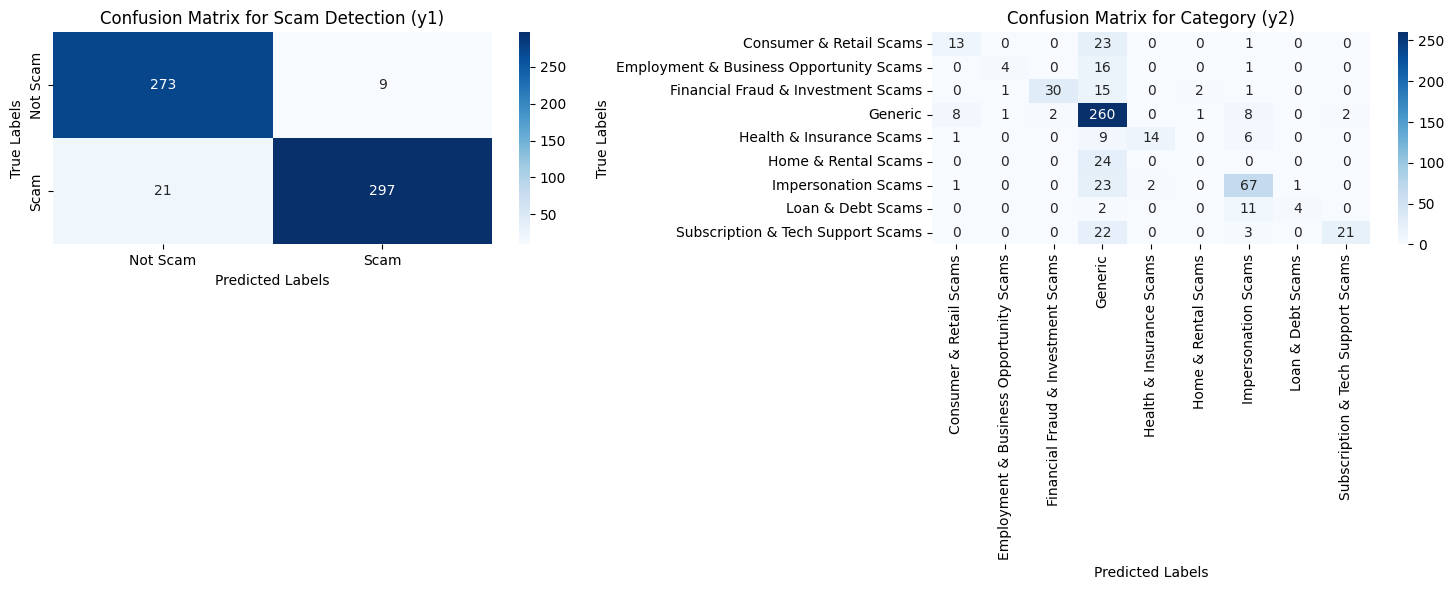

Confusion Matrix for SBERT:


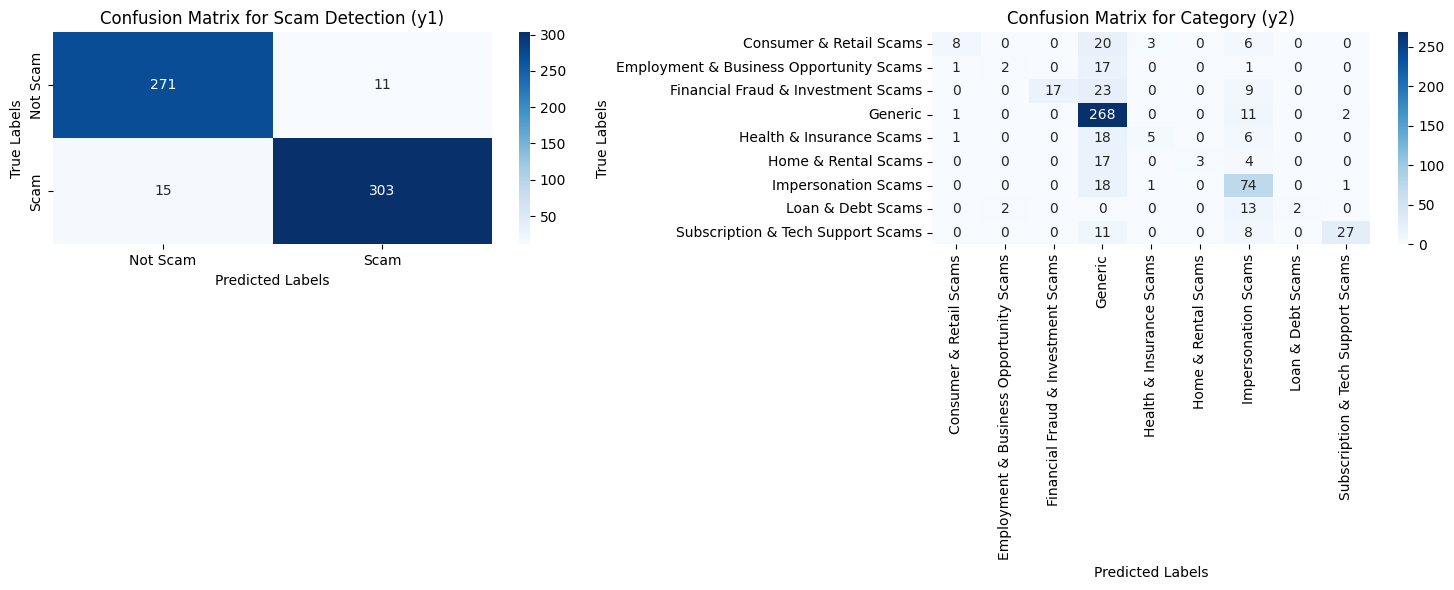

In [38]:
# For each embedding data, plot the confusion matrices for test set
for embedding, data in embedding_data.items():
    print(f"Confusion Matrix for {embedding}:")

    # Create your models
    AdaBoost_model_y1 = AdaBoostClassifier(n_estimators=100, random_state=42).fit(data["X_train"], data["y1_train"])
    AdaBoost_model_y2 = AdaBoostClassifier(n_estimators=100, random_state=42).fit(data["X_train"], data["y2_train"])

    # Get predictions
    y_pred_1 = AdaBoost_model_y1.predict(data["X_test"])
    y_pred_2 = AdaBoost_model_y2.predict(data["X_test"])

    # Plot the confusion matrices
    fig = plot_dual_confusion_matrices(
        data["y1_test"], y_pred_1,
        data["y2_test"], y_pred_2,
        y2_labels=le,  # Your label encoder
        y2_title=f"Confusion Matrix for Category (y2)"
    )

    plt.show()

In [39]:
combined_results_df

# Save the results to a csv file
combined_results_df.to_csv("results.csv", index=False)

### 4.5. Scam Detection with (Policy-Based Reinforcement Learning) 💡

We will now explore scam detectionn with reinforcement learning - the third main paradigm within the field of machine learning.

Rather than training our model with an explicit labelled dataset, we train an agent with a policy to maximize scam detection accuracy. With this approach over time, our agent should be able to explore and learn new scam patterns dynamically rather than relying on static labels.

**Key Components:**

- Agent: The model that classifies conversations
- Environment: The dataset of conversations
- State: Features representing the current conversation
- Action: Classifying a conversation as 'scam' or 'not scam'
- Reward: Feedback based on the accuracy of the classification

Use Transformers-based feature extractor with SentenceBERT

In [40]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2').to(device)
X_rl = list(dataset_df["dialogue_processed"].values)
X_rl_embeddings = model.encode(X_rl)

In [41]:
y_rl = dataset_df["labels"].values

In [42]:
y2_rl = le.transform(dataset_df["type"].values)

In [43]:
print(X_rl_embeddings.shape)
print(y_rl.shape)
print(y2_rl.shape)

(2000, 384)
(2000,)
(2000,)


In [44]:
X_rl_train, X_rl_rest, y_rl_train, y_rl_rest, y2_rl_train, y2_rl_rest = train_test_split(X_rl_embeddings, y_rl, y2_rl, test_size=0.6, random_state=42) # Train split
X_rl_val, X_rl_test, y_rl_val, y_rl_test, y2_rl_val, y2_rl_test = train_test_split(X_rl_rest, y_rl_rest, y2_rl_rest, test_size=0.5, random_state=42) # Validation and test split

In [45]:
print("Train set:")
print(X_rl_train.shape)
print(y_rl_train.shape)
print()
print("Validation set:")
print(X_rl_val.shape)
print(y_rl_val.shape)
print()
print("Test set:")
print(X_rl_test.shape)
print(y_rl_test.shape)

Train set:
(800, 384)
(800,)

Validation set:
(600, 384)
(600,)

Test set:
(600, 384)
(600,)


#### 4.5.1 Defining the Neural Network (Agent + Policy that it follows)

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define your policy network architecture
class ScamPolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=2):
        super(ScamPolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=-1)

# Wrap the policy network and training process in a class
class ScamPolicyModel:
    def __init__(self, X_train, y_train, batch_size=32, lr=1e-3, output_dim=2):
        self.input_dim = X_train.shape[1]
        self.model = ScamPolicyNetwork(self.input_dim, hidden_dim=128, output_dim=output_dim)
        
        # Device selection
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            self.device = torch.device("mps")
        else:
            self.device = torch.device("cpu")
        self.model.to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.batch_size = batch_size
        
        # Convert training data to tensors (make sure X_train is a NumPy array)

        # For handling sparse data types (Count Vectorizer, TF-IDF Vectorizer)
        if type(X_train) == scipy.sparse.csr.csr_matrix:
            X_train = X_train.toarray()

        self.train_dataset = TensorDataset(
            torch.tensor(X_train, dtype=torch.float32), 
            torch.tensor(y_train, dtype=torch.long)
        )
        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        
        self.loss_history = []
        self.reward_history = []
        self.best_model_weights = None

    def summary(self):
        """Prints the model summary."""
        self.model.to("cpu")
        summary(self.model, (self.batch_size, self.input_dim))
        self.model.to(self.device)
    
    def reward_function(self, actions, true_labels):
        """
        Computes rewards for a batch.
        Here, if the action matches the true label, reward = +1; otherwise, -1.
        You can make this more sophisticated as needed.
        """  
        reward = torch.where(actions == true_labels, 
                             torch.ones_like(actions, dtype=torch.float32), 
                             -torch.ones_like(actions, dtype=torch.float32))
        return reward

    def train(self, num_epochs):
        best_loss = float('inf')
        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0.0
            num_batches = 0
            for inputs, labels in self.train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                # Forward pass: get probabilities for the batch
                probs = self.model(inputs)  # Shape: (batch_size, 2)
                
                # Choose the action with the highest probability per sample
                actions = torch.argmax(probs, dim=1)  # Shape: (batch_size,)
                
                # Compute reward for the entire batch
                reward = self.reward_function(actions, labels)  # Tensor shape: (batch_size,)
                
                # Gather the predicted probabilities for the chosen actions
                selected_probs = probs.gather(1, actions.unsqueeze(1)).squeeze().clamp(min=1e-10)
                
                # Compute loss using the REINFORCE update (averaged over the batch)
                loss = (-torch.log(selected_probs) * reward).mean()
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
                num_batches += 1
                self.reward_history.append(reward.cpu().numpy())
                self.loss_history.append(loss.item())
            
            avg_loss = total_loss / num_batches
            print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")
            
            if avg_loss < best_loss:
                best_loss = avg_loss
                self.best_model_weights = self.model.state_dict()
        print("Training complete.")

    def plot_losses(self):
        """Plots the loss progression over training."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_history, label="Loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.title("Loss Progression Over Training")
        plt.legend()
        plt.show()
    
    def predict(self, X):
        """Makes predictions for the given input features."""
        self.model.eval()
        with torch.no_grad():
            inputs = torch.tensor(X, dtype=torch.float32).to(self.device)
            probs = self.model(inputs)
            actions = torch.argmax(probs, dim=1)
        return actions.cpu().numpy()
    
    def evaluate(self, X, y):
        """Evaluates the model on the provided dataset and prints classification metrics."""
        # For handling sparse data types (Count Vectorizer, TF-IDF Vectorizer)
        if type(X) == scipy.sparse.csr.csr_matrix:
            X = X.toarray()
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)
        conf_matrix = confusion_matrix(y, y_pred)
        class_report = classification_report(y, y_pred, zero_division=0)
        print("Accuracy:", accuracy)
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)
        return accuracy, conf_matrix, class_report

    def plot_confusion_matrix(self, X, y, class_names):
        """Plots the confusion matrix for model predictions."""
        if type(X) == scipy.sparse.csr.csr_matrix:
            X = X.toarray()
        y_pred = self.predict(X)
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    def evaluate_raw(self, X, y, average="binary"):
        # Output raw precision, F1, and recall scores
        if type(X) == scipy.sparse.csr.csr_matrix:
            X = X.toarray()
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average=average)
        recall = recall_score(y, y_pred, average=average)
        f1 = f1_score(y, y_pred, average=average)
        return accuracy, precision, recall, f1

#### 4.5.2 Policy-Based Reinforcement Learning, SentenceBERT, Y1

In [47]:
policy_network_y1_sbert = ScamPolicyModel(X_SBERT_train, y1_SBERT_train.to_numpy(), batch_size=32, lr=1e-3, output_dim=2)

policy_network_y1_sbert.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 32, 128]             49,280
├─Linear: 1-2                            [-1, 32, 2]               258
Total params: 49,538
Trainable params: 49,538
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.05
Forward/backward pass size (MB): 0.03
Params size (MB): 0.19
Estimated Total Size (MB): 0.27


/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:44: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X_train) == scipy.sparse.csr.csr_matrix:


In [48]:
policy_network_y1_sbert.train(num_epochs=10)

Epoch 1/10 - Average Loss: 0.1548
Epoch 2/10 - Average Loss: 0.2618
Epoch 3/10 - Average Loss: 0.1153
Epoch 4/10 - Average Loss: 0.0676
Epoch 5/10 - Average Loss: 0.0516
Epoch 6/10 - Average Loss: 0.0353
Epoch 7/10 - Average Loss: 0.0291
Epoch 8/10 - Average Loss: 0.0230
Epoch 9/10 - Average Loss: 0.0213
Epoch 10/10 - Average Loss: 0.0166
Training complete.


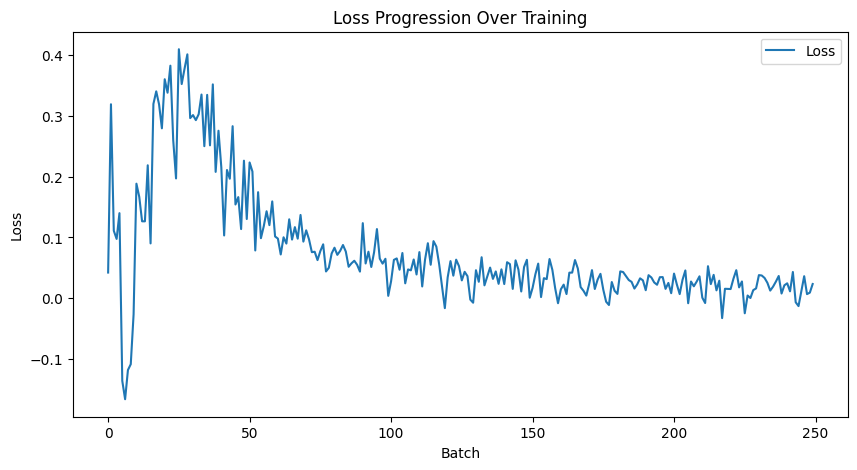

In [49]:
policy_network_y1_sbert.plot_losses()

In [50]:
policy_network_y1_sbert.evaluate(X_SBERT_val, y1_SBERT_val.to_numpy())

Accuracy: 0.9633333333333334
Confusion Matrix:
[[284  11]
 [ 11 294]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       295
           1       0.96      0.96      0.96       305

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.9633333333333334,
 array([[284,  11],
        [ 11, 294]]),
 '              precision    recall  f1-score   support\n\n           0       0.96      0.96      0.96       295\n           1       0.96      0.96      0.96       305\n\n    accuracy                           0.96       600\n   macro avg       0.96      0.96      0.96       600\nweighted avg       0.96      0.96      0.96       600\n')

In [51]:
policy_network_y1_sbert.evaluate(X_SBERT_test, y1_SBERT_test.to_numpy())

Accuracy: 0.965
Confusion Matrix:
[[273   9]
 [ 12 306]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       282
           1       0.97      0.96      0.97       318

    accuracy                           0.96       600
   macro avg       0.96      0.97      0.96       600
weighted avg       0.97      0.96      0.97       600



/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.965,
 array([[273,   9],
        [ 12, 306]]),
 '              precision    recall  f1-score   support\n\n           0       0.96      0.97      0.96       282\n           1       0.97      0.96      0.97       318\n\n    accuracy                           0.96       600\n   macro avg       0.96      0.97      0.96       600\nweighted avg       0.97      0.96      0.97       600\n')

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:152: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


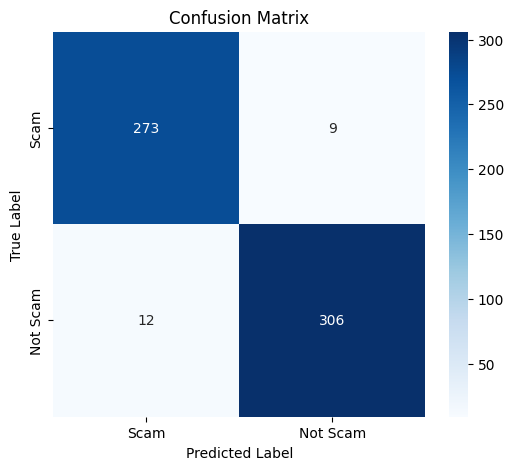

In [52]:
policy_network_y1_sbert.plot_confusion_matrix(X_SBERT_test, y1_SBERT_test.to_numpy(), class_names=["Scam", "Not Scam"])

#### 4.5.3 Policy-Based Reinforcement Learning, SentenceBERT, Y2

In [53]:
policy_network_y2_sbert = ScamPolicyModel(X_SBERT_train, y2_SBERT_train, batch_size=32, lr=1e-3, output_dim=num_types)

policy_network_y2_sbert.summary()

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:44: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X_train) == scipy.sparse.csr.csr_matrix:


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 32, 128]             49,280
├─Linear: 1-2                            [-1, 32, 9]               1,161
Total params: 50,441
Trainable params: 50,441
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.05
Forward/backward pass size (MB): 0.03
Params size (MB): 0.19
Estimated Total Size (MB): 0.27


In [54]:
policy_network_y2_sbert.train(num_epochs=10)

Epoch 1/10 - Average Loss: -0.2302
Epoch 2/10 - Average Loss: 0.2942
Epoch 3/10 - Average Loss: -0.0642
Epoch 4/10 - Average Loss: -0.0813
Epoch 5/10 - Average Loss: 0.0212
Epoch 6/10 - Average Loss: 0.0319
Epoch 7/10 - Average Loss: 0.0702
Epoch 8/10 - Average Loss: 0.0214
Epoch 9/10 - Average Loss: -0.0155
Epoch 10/10 - Average Loss: -0.0419
Training complete.


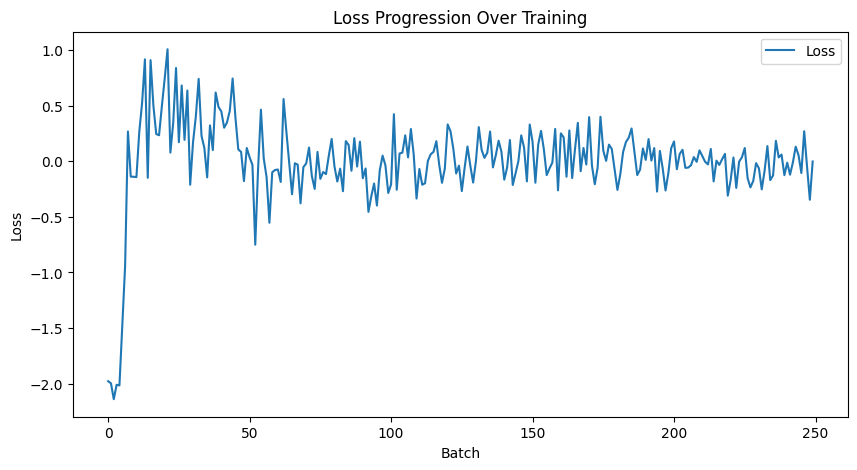

In [55]:
policy_network_y2_sbert.plot_losses()

In [56]:
policy_network_y2_sbert.evaluate(X_SBERT_val, y2_SBERT_val)

Accuracy: 0.745
Confusion Matrix:
[[ 25   0   5   6   0   0  10   0   0]
 [  6   0   7   5   0   0   2   0   0]
 [  0   0  21   4   0   0   9   0   2]
 [  0   0   0 291   0   0   4   0   0]
 [  8   0   0   7   0   0  14   0   1]
 [  2   0   6  10   0   0   2   0   1]
 [  0   0   1   4   0   0  78   0   9]
 [  7   0   0   1   0   0  15   0   1]
 [  0   0   0   4   0   0   0   0  32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.54      0.53        46
           1       0.00      0.00      0.00        20
           2       0.53      0.58      0.55        36
           3       0.88      0.99      0.93       295
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        21
           6       0.58      0.85      0.69        92
           7       0.00      0.00      0.00        24
           8       0.70      0.89      0.78        36

    accuracy                           0.74      

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.745,
 array([[ 25,   0,   5,   6,   0,   0,  10,   0,   0],
        [  6,   0,   7,   5,   0,   0,   2,   0,   0],
        [  0,   0,  21,   4,   0,   0,   9,   0,   2],
        [  0,   0,   0, 291,   0,   0,   4,   0,   0],
        [  8,   0,   0,   7,   0,   0,  14,   0,   1],
        [  2,   0,   6,  10,   0,   0,   2,   0,   1],
        [  0,   0,   1,   4,   0,   0,  78,   0,   9],
        [  7,   0,   0,   1,   0,   0,  15,   0,   1],
        [  0,   0,   0,   4,   0,   0,   0,   0,  32]]),
 '              precision    recall  f1-score   support\n\n           0       0.52      0.54      0.53        46\n           1       0.00      0.00      0.00        20\n           2       0.53      0.58      0.55        36\n           3       0.88      0.99      0.93       295\n           4       0.00      0.00      0.00        30\n           5       0.00      0.00      0.00        21\n           6       0.58      0.85      0.69        92\n           7       0.00      0.00      0.00        

In [57]:
policy_network_y2_sbert.evaluate(X_SBERT_test, y2_SBERT_test)

Accuracy: 0.7783333333333333
Confusion Matrix:
[[ 23   0   2   8   0   0   4   0   0]
 [  6   0   6   5   0   0   3   0   1]
 [  1   0  36   4   0   0   6   0   2]
 [  0   0   0 279   0   0   3   0   0]
 [  4   0   1   3   0   0  19   0   3]
 [  4   0   3  12   0   0   3   0   2]
 [  1   0   0   2   0   0  90   0   1]
 [  3   0   1   1   0   0  12   0   0]
 [  0   0   0   3   0   0   4   0  39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58        37
           1       0.00      0.00      0.00        21
           2       0.73      0.73      0.73        49
           3       0.88      0.99      0.93       282
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        24
           6       0.62      0.96      0.76        94
           7       0.00      0.00      0.00        17
           8       0.81      0.85      0.83        46

    accuracy                        

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.7783333333333333,
 array([[ 23,   0,   2,   8,   0,   0,   4,   0,   0],
        [  6,   0,   6,   5,   0,   0,   3,   0,   1],
        [  1,   0,  36,   4,   0,   0,   6,   0,   2],
        [  0,   0,   0, 279,   0,   0,   3,   0,   0],
        [  4,   0,   1,   3,   0,   0,  19,   0,   3],
        [  4,   0,   3,  12,   0,   0,   3,   0,   2],
        [  1,   0,   0,   2,   0,   0,  90,   0,   1],
        [  3,   0,   1,   1,   0,   0,  12,   0,   0],
        [  0,   0,   0,   3,   0,   0,   4,   0,  39]]),
 '              precision    recall  f1-score   support\n\n           0       0.55      0.62      0.58        37\n           1       0.00      0.00      0.00        21\n           2       0.73      0.73      0.73        49\n           3       0.88      0.99      0.93       282\n           4       0.00      0.00      0.00        30\n           5       0.00      0.00      0.00        24\n           6       0.62      0.96      0.76        94\n           7       0.00      0.00     

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:152: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


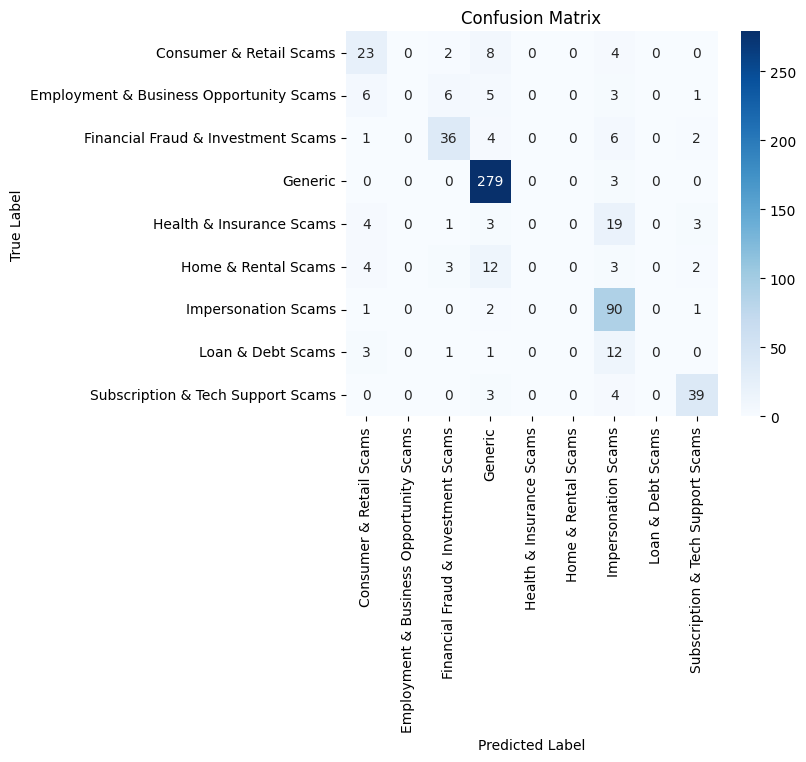

In [58]:
policy_network_y2_sbert.plot_confusion_matrix(X_SBERT_test, y2_SBERT_test, class_names=le.classes_)

#### 4.5.4 Policy-Based Reinforcement Learning, CountVectorizer, Y1

In [59]:
policy_network_y1_cv = ScamPolicyModel(X_CV_train, y1_CV_train.to_numpy(), batch_size=32, lr=1e-3, output_dim=2)

policy_network_y1_cv.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 32, 128]             98,432
├─Linear: 1-2                            [-1, 32, 2]               258
Total params: 98,690
Trainable params: 98,690
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.09
Forward/backward pass size (MB): 0.03
Params size (MB): 0.38
Estimated Total Size (MB): 0.50


/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:44: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X_train) == scipy.sparse.csr.csr_matrix:


In [60]:
policy_network_y1_cv.train(num_epochs=10)

Epoch 1/10 - Average Loss: 0.1780
Epoch 2/10 - Average Loss: 0.2783
Epoch 3/10 - Average Loss: 0.1743
Epoch 4/10 - Average Loss: 0.1049
Epoch 5/10 - Average Loss: 0.0766
Epoch 6/10 - Average Loss: 0.0594
Epoch 7/10 - Average Loss: 0.0476
Epoch 8/10 - Average Loss: 0.0433
Epoch 9/10 - Average Loss: 0.0371
Epoch 10/10 - Average Loss: 0.0311
Training complete.


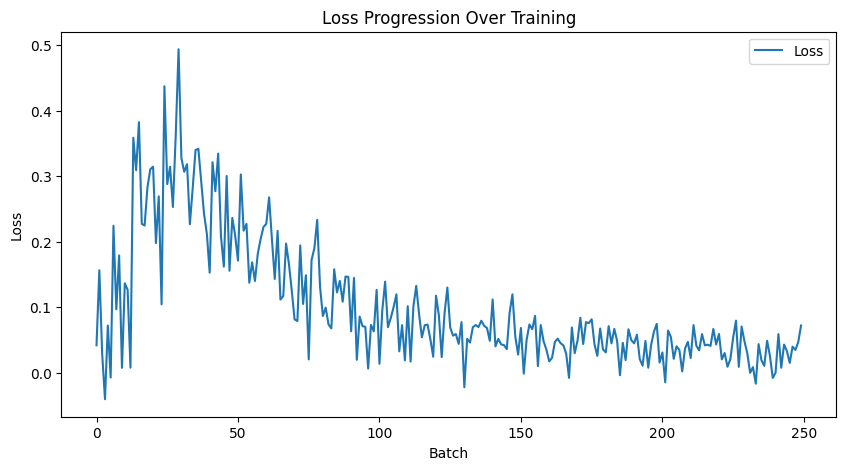

In [61]:
policy_network_y1_cv.plot_losses()

In [62]:
policy_network_y1_cv.evaluate(X_CV_val, y1_CV_val)

Accuracy: 0.8816666666666667
Confusion Matrix:
[[280  15]
 [ 56 249]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       295
           1       0.94      0.82      0.88       305

    accuracy                           0.88       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.89      0.88      0.88       600



/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.8816666666666667,
 array([[280,  15],
        [ 56, 249]]),
 '              precision    recall  f1-score   support\n\n           0       0.83      0.95      0.89       295\n           1       0.94      0.82      0.88       305\n\n    accuracy                           0.88       600\n   macro avg       0.89      0.88      0.88       600\nweighted avg       0.89      0.88      0.88       600\n')

In [63]:
policy_network_y1_cv.evaluate(X_CV_test, y1_CV_test)

Accuracy: 0.885
Confusion Matrix:
[[276   6]
 [ 63 255]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       282
           1       0.98      0.80      0.88       318

    accuracy                           0.89       600
   macro avg       0.90      0.89      0.88       600
weighted avg       0.90      0.89      0.88       600



/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.885,
 array([[276,   6],
        [ 63, 255]]),
 '              precision    recall  f1-score   support\n\n           0       0.81      0.98      0.89       282\n           1       0.98      0.80      0.88       318\n\n    accuracy                           0.89       600\n   macro avg       0.90      0.89      0.88       600\nweighted avg       0.90      0.89      0.88       600\n')

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:152: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


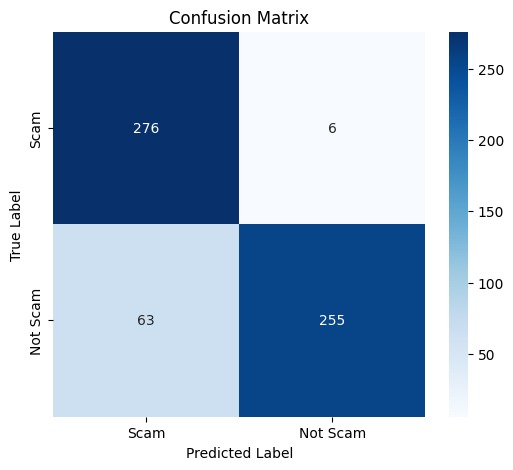

In [64]:
policy_network_y1_cv.plot_confusion_matrix(X_CV_test, y1_CV_test, class_names=["Scam", "Not Scam"])

#### 4.5.5 Policy-Based Reinforcement Learning, CountVectorizer, Y2

In [65]:
policy_network_y2_cv = ScamPolicyModel(X_CV_train, y2_CV_train, batch_size=32, lr=1e-3, output_dim=num_types)

policy_network_y2_cv.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 32, 128]             98,432
├─Linear: 1-2                            [-1, 32, 9]               1,161
Total params: 99,593
Trainable params: 99,593
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.09
Forward/backward pass size (MB): 0.03
Params size (MB): 0.38
Estimated Total Size (MB): 0.51


/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:44: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X_train) == scipy.sparse.csr.csr_matrix:


In [66]:
policy_network_y2_cv.train(num_epochs=10)

Epoch 1/10 - Average Loss: 0.0761
Epoch 2/10 - Average Loss: 0.3317
Epoch 3/10 - Average Loss: 0.1574
Epoch 4/10 - Average Loss: -0.0044
Epoch 5/10 - Average Loss: -0.0764
Epoch 6/10 - Average Loss: -0.0819
Epoch 7/10 - Average Loss: -0.0739
Epoch 8/10 - Average Loss: -0.0643
Epoch 9/10 - Average Loss: -0.0381
Epoch 10/10 - Average Loss: -0.0217
Training complete.


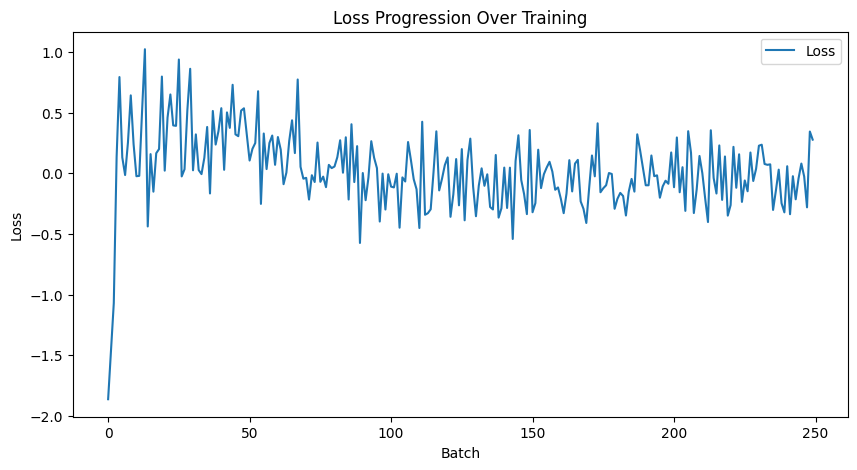

In [67]:
policy_network_y2_cv.plot_losses()

In [68]:
policy_network_y2_cv.evaluate(X_CV_val, y2_CV_val)

Accuracy: 0.665
Confusion Matrix:
[[  2   5   1  23   0   6   6   0   3]
 [  1   1   0  11   1   0   5   0   1]
 [  1   1  18  10   1   1   4   0   0]
 [  0   0   0 293   0   0   1   0   1]
 [  4   0   0  12   2   3   7   0   2]
 [  2   1   0   9   1   3   4   0   1]
 [  1   1   0  30   0   2  53   0   5]
 [  0   0   0  10   0   1  13   0   0]
 [  0   0   0   7   0   1   1   0  27]]
Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.04      0.07        46
           1       0.11      0.05      0.07        20
           2       0.95      0.50      0.65        36
           3       0.72      0.99      0.84       295
           4       0.40      0.07      0.11        30
           5       0.18      0.14      0.16        21
           6       0.56      0.58      0.57        92
           7       0.00      0.00      0.00        24
           8       0.68      0.75      0.71        36

    accuracy                           0.67      

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.665,
 array([[  2,   5,   1,  23,   0,   6,   6,   0,   3],
        [  1,   1,   0,  11,   1,   0,   5,   0,   1],
        [  1,   1,  18,  10,   1,   1,   4,   0,   0],
        [  0,   0,   0, 293,   0,   0,   1,   0,   1],
        [  4,   0,   0,  12,   2,   3,   7,   0,   2],
        [  2,   1,   0,   9,   1,   3,   4,   0,   1],
        [  1,   1,   0,  30,   0,   2,  53,   0,   5],
        [  0,   0,   0,  10,   0,   1,  13,   0,   0],
        [  0,   0,   0,   7,   0,   1,   1,   0,  27]]),
 '              precision    recall  f1-score   support\n\n           0       0.18      0.04      0.07        46\n           1       0.11      0.05      0.07        20\n           2       0.95      0.50      0.65        36\n           3       0.72      0.99      0.84       295\n           4       0.40      0.07      0.11        30\n           5       0.18      0.14      0.16        21\n           6       0.56      0.58      0.57        92\n           7       0.00      0.00      0.00        

In [69]:
policy_network_y2_cv.evaluate(X_CV_test, y2_CV_test)

Accuracy: 0.6566666666666666
Confusion Matrix:
[[  3   1   3  18   0   3   8   0   1]
 [  1   4   3   6   1   1   4   0   1]
 [  2   2  16  22   0   0   6   0   1]
 [  0   0   0 280   0   0   2   0   0]
 [  5   3   2   9   1   1   8   0   1]
 [  3   2   1  13   0   2   2   0   1]
 [  0   0   0  33   0   2  54   0   5]
 [  0   0   0   6   1   1   8   0   1]
 [  0   1   2   5   0   0   4   0  34]]
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.08      0.12        37
           1       0.31      0.19      0.24        21
           2       0.59      0.33      0.42        49
           3       0.71      0.99      0.83       282
           4       0.33      0.03      0.06        30
           5       0.20      0.08      0.12        24
           6       0.56      0.57      0.57        94
           7       0.00      0.00      0.00        17
           8       0.76      0.74      0.75        46

    accuracy                        

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.6566666666666666,
 array([[  3,   1,   3,  18,   0,   3,   8,   0,   1],
        [  1,   4,   3,   6,   1,   1,   4,   0,   1],
        [  2,   2,  16,  22,   0,   0,   6,   0,   1],
        [  0,   0,   0, 280,   0,   0,   2,   0,   0],
        [  5,   3,   2,   9,   1,   1,   8,   0,   1],
        [  3,   2,   1,  13,   0,   2,   2,   0,   1],
        [  0,   0,   0,  33,   0,   2,  54,   0,   5],
        [  0,   0,   0,   6,   1,   1,   8,   0,   1],
        [  0,   1,   2,   5,   0,   0,   4,   0,  34]]),
 '              precision    recall  f1-score   support\n\n           0       0.21      0.08      0.12        37\n           1       0.31      0.19      0.24        21\n           2       0.59      0.33      0.42        49\n           3       0.71      0.99      0.83       282\n           4       0.33      0.03      0.06        30\n           5       0.20      0.08      0.12        24\n           6       0.56      0.57      0.57        94\n           7       0.00      0.00     

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:152: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


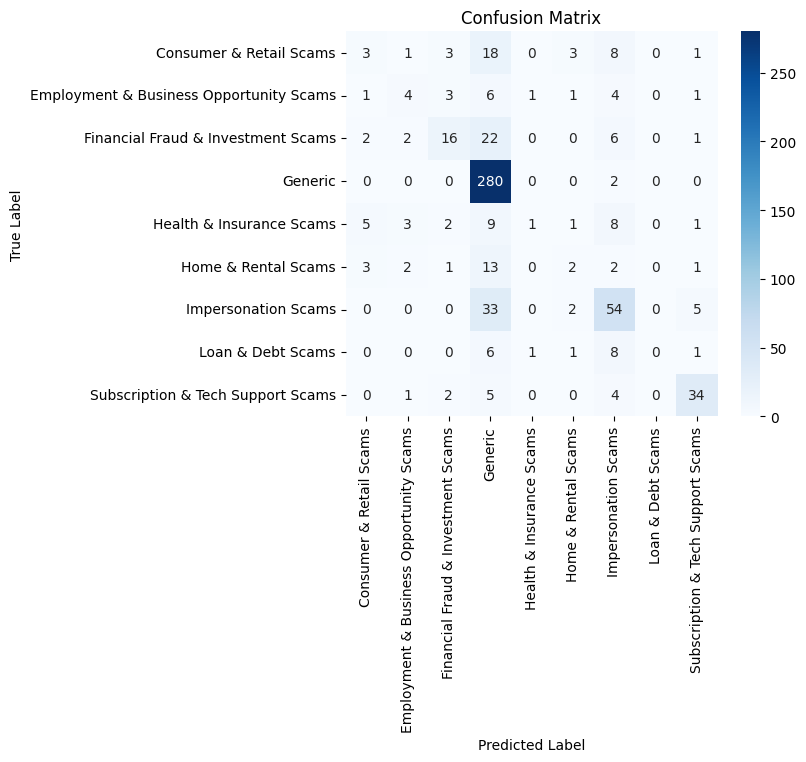

In [70]:
policy_network_y2_cv.plot_confusion_matrix(X_CV_test, y2_CV_test, class_names=le.classes_)

#### 4.5.6 Policy-Based Reinforcement Learning, TF-IDF Vectorizer, Y1

In [71]:
policy_network_y1_tf_idf = ScamPolicyModel(X_TFIDF_train, y1_TFIDF_train.to_numpy(), batch_size=32, lr=1e-3, output_dim=2)

policy_network_y1_tf_idf.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 32, 128]             98,432
├─Linear: 1-2                            [-1, 32, 2]               258
Total params: 98,690
Trainable params: 98,690
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.09
Forward/backward pass size (MB): 0.03
Params size (MB): 0.38
Estimated Total Size (MB): 0.50


/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:44: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X_train) == scipy.sparse.csr.csr_matrix:


In [72]:
policy_network_y1_tf_idf.train(num_epochs=10)

Epoch 1/10 - Average Loss: 0.0516
Epoch 2/10 - Average Loss: 0.3062
Epoch 3/10 - Average Loss: 0.2722
Epoch 4/10 - Average Loss: 0.1573
Epoch 5/10 - Average Loss: 0.1009
Epoch 6/10 - Average Loss: 0.0712
Epoch 7/10 - Average Loss: 0.0599
Epoch 8/10 - Average Loss: 0.0466
Epoch 9/10 - Average Loss: 0.0388
Epoch 10/10 - Average Loss: 0.0342
Training complete.


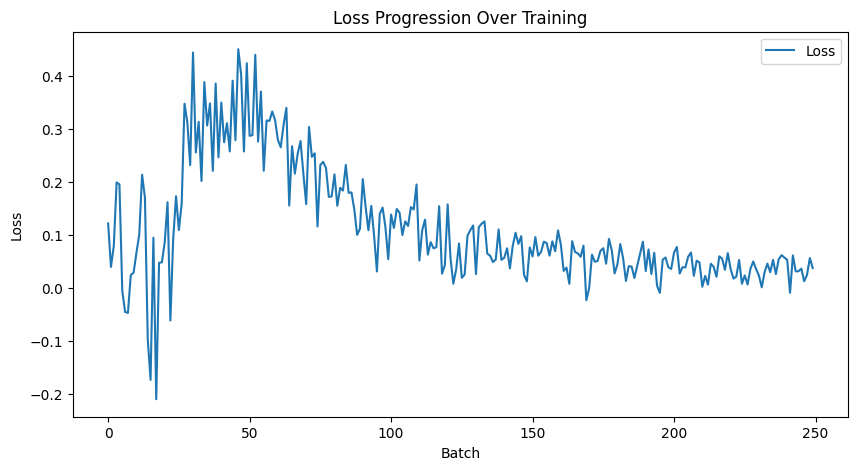

In [73]:
policy_network_y1_tf_idf.plot_losses()

In [74]:
policy_network_y1_tf_idf.evaluate(X_TFIDF_val, y1_TFIDF_val)

Accuracy: 0.8883333333333333
Confusion Matrix:
[[281  14]
 [ 53 252]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       295
           1       0.95      0.83      0.88       305

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.90      0.89      0.89       600



/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.8883333333333333,
 array([[281,  14],
        [ 53, 252]]),
 '              precision    recall  f1-score   support\n\n           0       0.84      0.95      0.89       295\n           1       0.95      0.83      0.88       305\n\n    accuracy                           0.89       600\n   macro avg       0.89      0.89      0.89       600\nweighted avg       0.90      0.89      0.89       600\n')

In [75]:
policy_network_y1_tf_idf.evaluate(X_TFIDF_test, y1_TFIDF_test)

Accuracy: 0.8916666666666667
Confusion Matrix:
[[273   9]
 [ 56 262]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       282
           1       0.97      0.82      0.89       318

    accuracy                           0.89       600
   macro avg       0.90      0.90      0.89       600
weighted avg       0.90      0.89      0.89       600



/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.8916666666666667,
 array([[273,   9],
        [ 56, 262]]),
 '              precision    recall  f1-score   support\n\n           0       0.83      0.97      0.89       282\n           1       0.97      0.82      0.89       318\n\n    accuracy                           0.89       600\n   macro avg       0.90      0.90      0.89       600\nweighted avg       0.90      0.89      0.89       600\n')

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:152: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


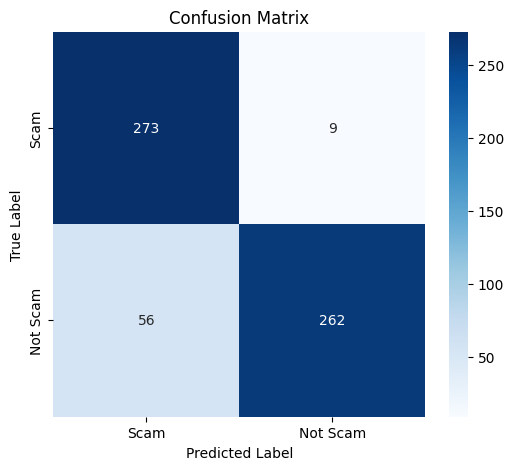

In [76]:
policy_network_y1_tf_idf.plot_confusion_matrix(X_TFIDF_test, y1_TFIDF_test, class_names=["Scam", "Not Scam"])

#### 4.5.7 Policy-Based Reinforcement Learning, TF-IDF Vectorizer, Y2

In [77]:
policy_network_y2_tf_idf = ScamPolicyModel(X_TFIDF_train, y2_TFIDF_train, batch_size=32, lr=1e-3, output_dim=num_types)

policy_network_y2_tf_idf.summary() 

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 32, 128]             98,432
├─Linear: 1-2                            [-1, 32, 9]               1,161
Total params: 99,593
Trainable params: 99,593
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.09
Forward/backward pass size (MB): 0.03
Params size (MB): 0.38
Estimated Total Size (MB): 0.51


/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:44: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X_train) == scipy.sparse.csr.csr_matrix:


In [78]:
policy_network_y2_tf_idf.train(num_epochs=10) 

Epoch 1/10 - Average Loss: -1.3005
Epoch 2/10 - Average Loss: 0.5981
Epoch 3/10 - Average Loss: 0.4137
Epoch 4/10 - Average Loss: 0.1482
Epoch 5/10 - Average Loss: -0.0164
Epoch 6/10 - Average Loss: -0.0738
Epoch 7/10 - Average Loss: -0.0602
Epoch 8/10 - Average Loss: -0.1184
Epoch 9/10 - Average Loss: -0.0827
Epoch 10/10 - Average Loss: -0.0855
Training complete.


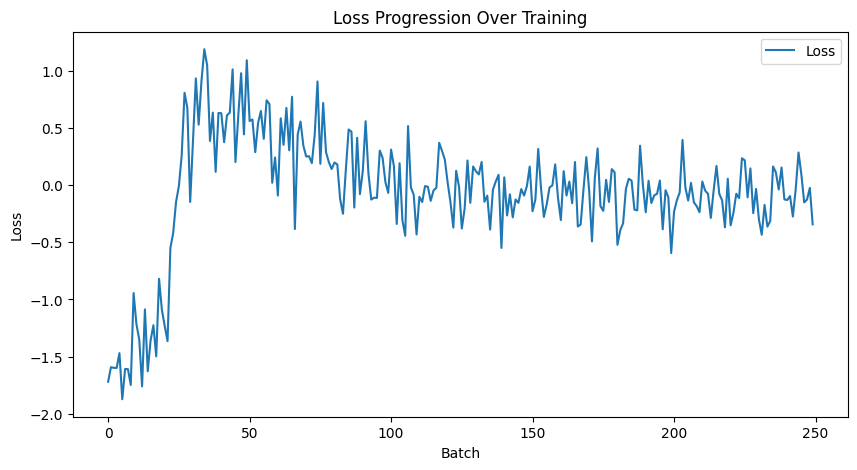

In [79]:
policy_network_y2_tf_idf.plot_losses()

In [80]:
policy_network_y2_tf_idf.evaluate(X_TFIDF_val, y2_TFIDF_val)

Accuracy: 0.6666666666666666
Confusion Matrix:
[[  0   2  11  17   1   0  12   1   2]
 [  0   1   1   7   0   0  10   0   1]
 [  0   1  20  10   0   0   5   0   0]
 [  0   0   0 292   0   0   3   0   0]
 [  0   2   5  10   1   1  10   0   1]
 [  1   0   4   8   0   1   6   0   1]
 [  0   1   3  26   0   0  58   1   3]
 [  0   1   0   9   0   0  14   0   0]
 [  0   0   0   7   0   0   2   0  27]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.12      0.05      0.07        20
           2       0.45      0.56      0.50        36
           3       0.76      0.99      0.86       295
           4       0.50      0.03      0.06        30
           5       0.50      0.05      0.09        21
           6       0.48      0.63      0.55        92
           7       0.00      0.00      0.00        24
           8       0.77      0.75      0.76        36

    accuracy                        

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.6666666666666666,
 array([[  0,   2,  11,  17,   1,   0,  12,   1,   2],
        [  0,   1,   1,   7,   0,   0,  10,   0,   1],
        [  0,   1,  20,  10,   0,   0,   5,   0,   0],
        [  0,   0,   0, 292,   0,   0,   3,   0,   0],
        [  0,   2,   5,  10,   1,   1,  10,   0,   1],
        [  1,   0,   4,   8,   0,   1,   6,   0,   1],
        [  0,   1,   3,  26,   0,   0,  58,   1,   3],
        [  0,   1,   0,   9,   0,   0,  14,   0,   0],
        [  0,   0,   0,   7,   0,   0,   2,   0,  27]]),
 '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00        46\n           1       0.12      0.05      0.07        20\n           2       0.45      0.56      0.50        36\n           3       0.76      0.99      0.86       295\n           4       0.50      0.03      0.06        30\n           5       0.50      0.05      0.09        21\n           6       0.48      0.63      0.55        92\n           7       0.00      0.00     

In [81]:
policy_network_y2_tf_idf.evaluate(X_TFIDF_test, y2_TFIDF_test)

Accuracy: 0.67
Confusion Matrix:
[[  0   2   3  15   0   1  16   0   0]
 [  0   3   3   5   1   1   8   0   0]
 [  0   0  18  19   0   1  10   0   1]
 [  0   0   1 280   0   0   1   0   0]
 [  0   1   5   8   2   1  10   0   3]
 [  0   2   1  12   0   1   7   0   1]
 [  0   0   3  27   0   0  62   0   2]
 [  0   1   1   6   0   0   8   0   1]
 [  0   0   2   5   1   0   2   0  36]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.33      0.14      0.20        21
           2       0.49      0.37      0.42        49
           3       0.74      0.99      0.85       282
           4       0.50      0.07      0.12        30
           5       0.20      0.04      0.07        24
           6       0.50      0.66      0.57        94
           7       0.00      0.00      0.00        17
           8       0.82      0.78      0.80        46

    accuracy                           0.67       

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.67,
 array([[  0,   2,   3,  15,   0,   1,  16,   0,   0],
        [  0,   3,   3,   5,   1,   1,   8,   0,   0],
        [  0,   0,  18,  19,   0,   1,  10,   0,   1],
        [  0,   0,   1, 280,   0,   0,   1,   0,   0],
        [  0,   1,   5,   8,   2,   1,  10,   0,   3],
        [  0,   2,   1,  12,   0,   1,   7,   0,   1],
        [  0,   0,   3,  27,   0,   0,  62,   0,   2],
        [  0,   1,   1,   6,   0,   0,   8,   0,   1],
        [  0,   0,   2,   5,   1,   0,   2,   0,  36]]),
 '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00        37\n           1       0.33      0.14      0.20        21\n           2       0.49      0.37      0.42        49\n           3       0.74      0.99      0.85       282\n           4       0.50      0.07      0.12        30\n           5       0.20      0.04      0.07        24\n           6       0.50      0.66      0.57        94\n           7       0.00      0.00      0.00        1

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:152: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


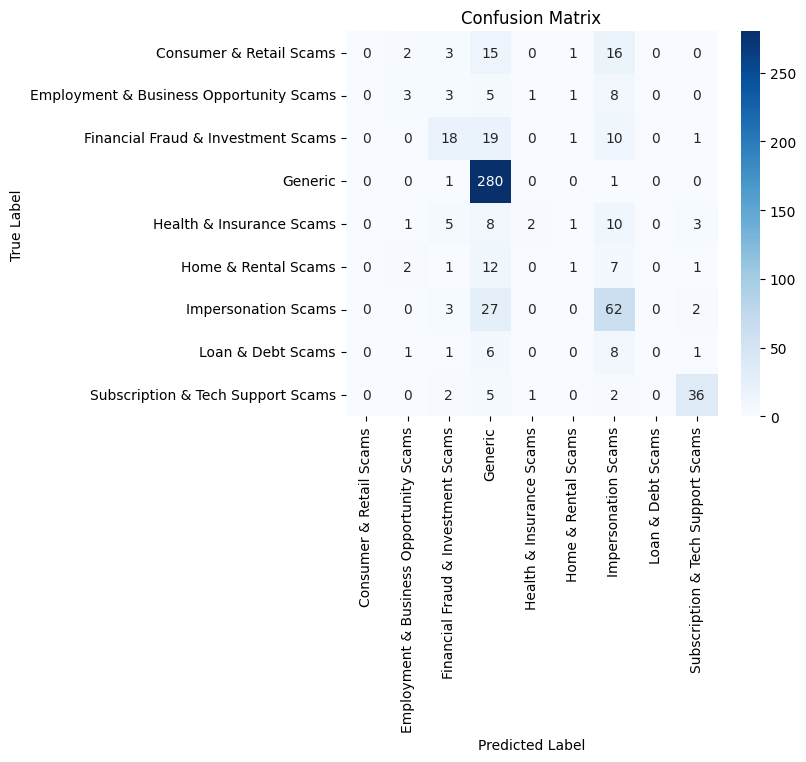

In [82]:
policy_network_y2_tf_idf.plot_confusion_matrix(X_TFIDF_test, y2_TFIDF_test, class_names=le.classes_)

#### 4.5.8 Policy-Based Reinforcement Learning, Word2Vec, Y1

In [83]:
policy_network_y1_w2v = ScamPolicyModel(X_W2V_train, y1_W2V_train.to_numpy(), batch_size=32, lr=1e-3, output_dim=2)

policy_network_y1_w2v.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 32, 128]             12,928
├─Linear: 1-2                            [-1, 32, 2]               258
Total params: 13,186
Trainable params: 13,186
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.05
Estimated Total Size (MB): 0.09


/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:44: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X_train) == scipy.sparse.csr.csr_matrix:


In [84]:
policy_network_y1_w2v.train(num_epochs=10)

Epoch 1/10 - Average Loss: 0.2469
Epoch 2/10 - Average Loss: 0.2460
Epoch 3/10 - Average Loss: 0.1280
Epoch 4/10 - Average Loss: 0.0799
Epoch 5/10 - Average Loss: 0.0677
Epoch 6/10 - Average Loss: 0.0455
Epoch 7/10 - Average Loss: 0.0389
Epoch 8/10 - Average Loss: 0.0308
Epoch 9/10 - Average Loss: 0.0282
Epoch 10/10 - Average Loss: 0.0275
Training complete.


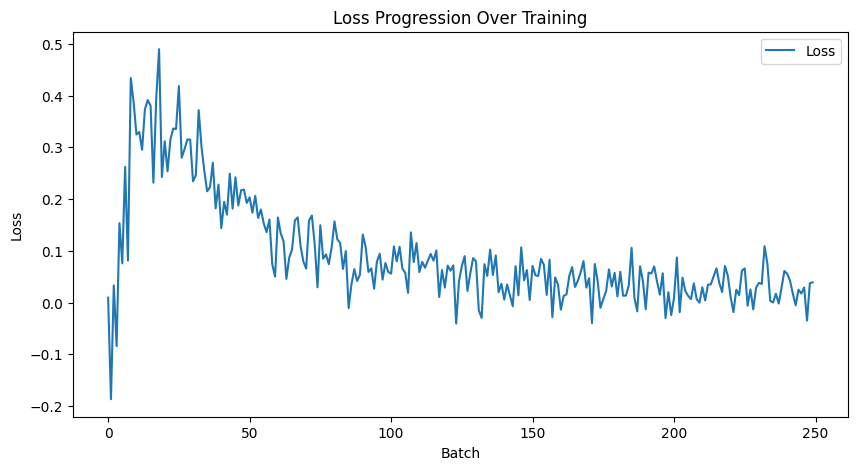

In [85]:
policy_network_y1_w2v.plot_losses()

In [86]:
policy_network_y1_w2v.evaluate(X_W2V_val, y1_W2V_val)

Accuracy: 0.8833333333333333
Confusion Matrix:
[[278  17]
 [ 53 252]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       295
           1       0.94      0.83      0.88       305

    accuracy                           0.88       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.89      0.88      0.88       600



/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.8833333333333333,
 array([[278,  17],
        [ 53, 252]]),
 '              precision    recall  f1-score   support\n\n           0       0.84      0.94      0.89       295\n           1       0.94      0.83      0.88       305\n\n    accuracy                           0.88       600\n   macro avg       0.89      0.88      0.88       600\nweighted avg       0.89      0.88      0.88       600\n')

In [87]:
policy_network_y1_w2v.evaluate(X_W2V_test, y1_W2V_test)

Accuracy: 0.9066666666666666
Confusion Matrix:
[[270  12]
 [ 44 274]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       282
           1       0.96      0.86      0.91       318

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600



/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.9066666666666666,
 array([[270,  12],
        [ 44, 274]]),
 '              precision    recall  f1-score   support\n\n           0       0.86      0.96      0.91       282\n           1       0.96      0.86      0.91       318\n\n    accuracy                           0.91       600\n   macro avg       0.91      0.91      0.91       600\nweighted avg       0.91      0.91      0.91       600\n')

#### 4.5.9 Policy-Based Reinforcement Learning, Word2Vec, Y2

In [88]:
policy_network_y2_w2v = ScamPolicyModel(X_W2V_train, y2_W2V_train, batch_size=32, lr=1e-3, output_dim=num_types)

policy_network_y2_w2v.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 32, 128]             12,928
├─Linear: 1-2                            [-1, 32, 9]               1,161
Total params: 14,089
Trainable params: 14,089
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.05
Estimated Total Size (MB): 0.10


/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:44: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X_train) == scipy.sparse.csr.csr_matrix:


In [89]:
policy_network_y2_w2v.train(num_epochs=10)

Epoch 1/10 - Average Loss: -0.5824
Epoch 2/10 - Average Loss: -0.0024
Epoch 3/10 - Average Loss: -0.1766
Epoch 4/10 - Average Loss: -0.0694
Epoch 5/10 - Average Loss: -0.1396
Epoch 6/10 - Average Loss: -0.1747
Epoch 7/10 - Average Loss: -0.2053
Epoch 8/10 - Average Loss: -0.2860
Epoch 9/10 - Average Loss: -0.3045
Epoch 10/10 - Average Loss: -0.3478
Training complete.


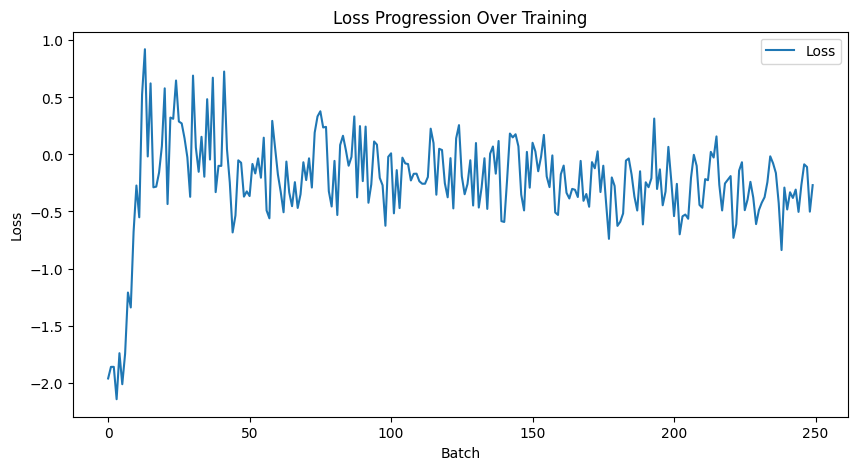

In [90]:
policy_network_y2_w2v.plot_losses()

In [91]:
policy_network_y2_w2v.evaluate(X_W2V_val, y2_W2V_val)

Accuracy: 0.5966666666666667
Confusion Matrix:
[[  0   0   1  31   5   4   5   0   0]
 [  3   0   0   8   2   2   5   0   0]
 [  0   0  14  14   5   1   2   0   0]
 [  0   0   0 290   2   1   2   0   0]
 [  0   1   0   4   4   3  17   0   1]
 [  0   0   0  14   4   0   2   0   1]
 [  0   2   3  28   5   5  49   0   0]
 [  0   0   0   3   5   0  16   0   0]
 [  0   1   3   9   2   0  20   0   1]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.00      0.00      0.00        20
           2       0.67      0.39      0.49        36
           3       0.72      0.98      0.83       295
           4       0.12      0.13      0.12        30
           5       0.00      0.00      0.00        21
           6       0.42      0.53      0.47        92
           7       0.00      0.00      0.00        24
           8       0.33      0.03      0.05        36

    accuracy                        

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.5966666666666667,
 array([[  0,   0,   1,  31,   5,   4,   5,   0,   0],
        [  3,   0,   0,   8,   2,   2,   5,   0,   0],
        [  0,   0,  14,  14,   5,   1,   2,   0,   0],
        [  0,   0,   0, 290,   2,   1,   2,   0,   0],
        [  0,   1,   0,   4,   4,   3,  17,   0,   1],
        [  0,   0,   0,  14,   4,   0,   2,   0,   1],
        [  0,   2,   3,  28,   5,   5,  49,   0,   0],
        [  0,   0,   0,   3,   5,   0,  16,   0,   0],
        [  0,   1,   3,   9,   2,   0,  20,   0,   1]]),
 '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00        46\n           1       0.00      0.00      0.00        20\n           2       0.67      0.39      0.49        36\n           3       0.72      0.98      0.83       295\n           4       0.12      0.13      0.12        30\n           5       0.00      0.00      0.00        21\n           6       0.42      0.53      0.47        92\n           7       0.00      0.00     

In [92]:
policy_network_y2_w2v.evaluate(X_W2V_test, y2_W2V_test)

Accuracy: 0.5883333333333334
Confusion Matrix:
[[  0   0   0  18   5   4   9   0   1]
 [  1   0   1   8   6   0   3   0   2]
 [  0   0  11  30   4   2   2   0   0]
 [  0   0   0 280   0   0   2   0   0]
 [  0   0   1   2   7   2  18   0   0]
 [  0   0   0  21   2   0   1   0   0]
 [  0   4   2  19   8   5  55   0   1]
 [  0   0   0   1   2   1  12   0   1]
 [  0   0   6  13   5   0  22   0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00        21
           2       0.52      0.22      0.31        49
           3       0.71      0.99      0.83       282
           4       0.18      0.23      0.20        30
           5       0.00      0.00      0.00        24
           6       0.44      0.59      0.50        94
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        46

    accuracy                        

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.5883333333333334,
 array([[  0,   0,   0,  18,   5,   4,   9,   0,   1],
        [  1,   0,   1,   8,   6,   0,   3,   0,   2],
        [  0,   0,  11,  30,   4,   2,   2,   0,   0],
        [  0,   0,   0, 280,   0,   0,   2,   0,   0],
        [  0,   0,   1,   2,   7,   2,  18,   0,   0],
        [  0,   0,   0,  21,   2,   0,   1,   0,   0],
        [  0,   4,   2,  19,   8,   5,  55,   0,   1],
        [  0,   0,   0,   1,   2,   1,  12,   0,   1],
        [  0,   0,   6,  13,   5,   0,  22,   0,   0]]),
 '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00        37\n           1       0.00      0.00      0.00        21\n           2       0.52      0.22      0.31        49\n           3       0.71      0.99      0.83       282\n           4       0.18      0.23      0.20        30\n           5       0.00      0.00      0.00        24\n           6       0.44      0.59      0.50        94\n           7       0.00      0.00     

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:152: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


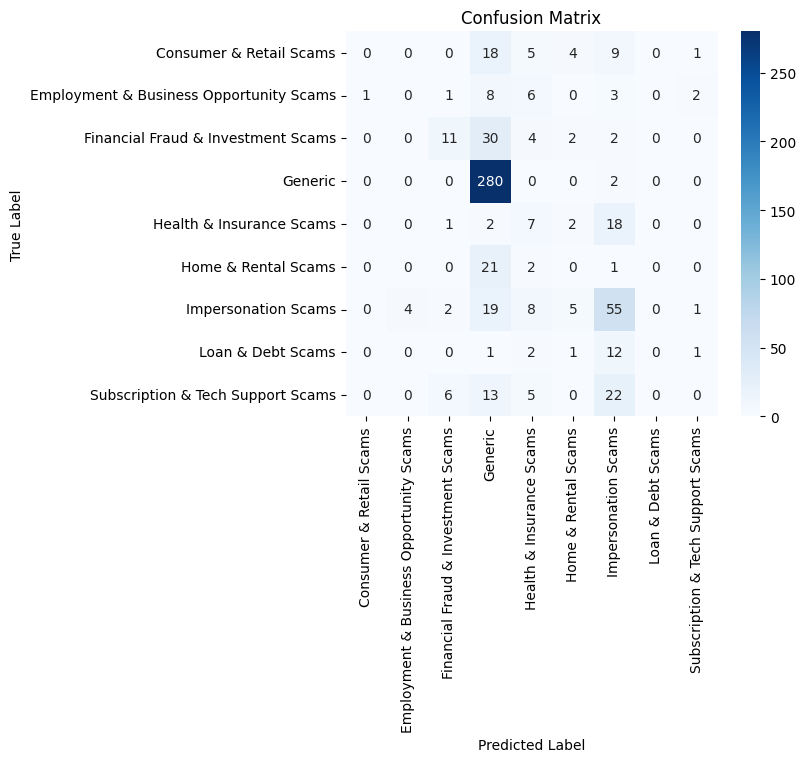

In [93]:
policy_network_y2_w2v.plot_confusion_matrix(X_W2V_test, y2_W2V_test, class_names=le.classes_)

#### 4.5.10 Policy-Based Reinforcement Learning, DistilBERT, Y1

In [94]:
policy_network_y1_bert = ScamPolicyModel(X_BERT_train, y1_BERT_train.to_numpy(), batch_size=32, lr=1e-3, output_dim=2)

policy_network_y1_bert.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 32, 128]             98,432
├─Linear: 1-2                            [-1, 32, 2]               258
Total params: 98,690
Trainable params: 98,690
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.09
Forward/backward pass size (MB): 0.03
Params size (MB): 0.38
Estimated Total Size (MB): 0.50


/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:44: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X_train) == scipy.sparse.csr.csr_matrix:


In [95]:
policy_network_y1_bert.train(num_epochs=10)

Epoch 1/10 - Average Loss: 0.2060
Epoch 2/10 - Average Loss: 0.1425
Epoch 3/10 - Average Loss: 0.1103
Epoch 4/10 - Average Loss: 0.0710
Epoch 5/10 - Average Loss: 0.0507
Epoch 6/10 - Average Loss: 0.0500
Epoch 7/10 - Average Loss: 0.0424
Epoch 8/10 - Average Loss: 0.0336
Epoch 9/10 - Average Loss: 0.0346
Epoch 10/10 - Average Loss: 0.0310
Training complete.


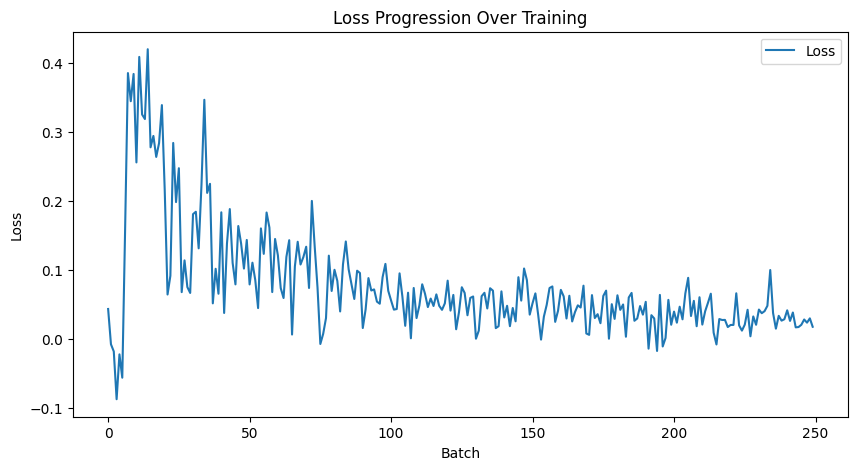

In [96]:
policy_network_y1_bert.plot_losses()

In [97]:
policy_network_y1_bert.evaluate(X_BERT_val, y1_BERT_val)

Accuracy: 0.9683333333333334
Confusion Matrix:
[[287   8]
 [ 11 294]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       295
           1       0.97      0.96      0.97       305

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.9683333333333334,
 array([[287,   8],
        [ 11, 294]]),
 '              precision    recall  f1-score   support\n\n           0       0.96      0.97      0.97       295\n           1       0.97      0.96      0.97       305\n\n    accuracy                           0.97       600\n   macro avg       0.97      0.97      0.97       600\nweighted avg       0.97      0.97      0.97       600\n')

In [98]:
policy_network_y1_bert.evaluate(X_BERT_test, y1_BERT_test)

Accuracy: 0.95
Confusion Matrix:
[[272  10]
 [ 20 298]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       282
           1       0.97      0.94      0.95       318

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.95,
 array([[272,  10],
        [ 20, 298]]),
 '              precision    recall  f1-score   support\n\n           0       0.93      0.96      0.95       282\n           1       0.97      0.94      0.95       318\n\n    accuracy                           0.95       600\n   macro avg       0.95      0.95      0.95       600\nweighted avg       0.95      0.95      0.95       600\n')

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:152: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


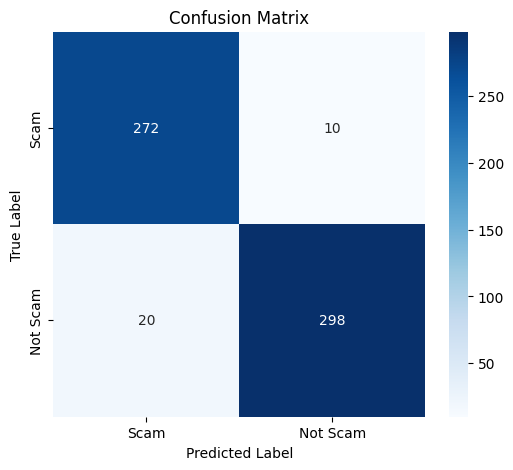

In [99]:
policy_network_y1_bert.plot_confusion_matrix(X_BERT_test, y1_BERT_test, class_names=["Scam", "Not Scam"])

#### 4.5.11 Policy-Based Reinforcement Learning, DistilBERT, Y2

In [100]:
policy_network_y2_bert = ScamPolicyModel(X_BERT_train, y2_BERT_train, batch_size=32, lr=1e-3, output_dim=num_types)

policy_network_y2_bert.summary()

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 32, 128]             98,432
├─Linear: 1-2                            [-1, 32, 9]               1,161
Total params: 99,593
Trainable params: 99,593
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.09
Forward/backward pass size (MB): 0.03
Params size (MB): 0.38
Estimated Total Size (MB): 0.51


/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:44: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X_train) == scipy.sparse.csr.csr_matrix:


In [101]:
policy_network_y2_bert.train(num_epochs=10)

Epoch 1/10 - Average Loss: -0.0548
Epoch 2/10 - Average Loss: -0.3323
Epoch 3/10 - Average Loss: -0.2654
Epoch 4/10 - Average Loss: -0.1525
Epoch 5/10 - Average Loss: -0.1195
Epoch 6/10 - Average Loss: -0.0583
Epoch 7/10 - Average Loss: -0.0439
Epoch 8/10 - Average Loss: -0.0445
Epoch 9/10 - Average Loss: -0.0543
Epoch 10/10 - Average Loss: -0.0647
Training complete.


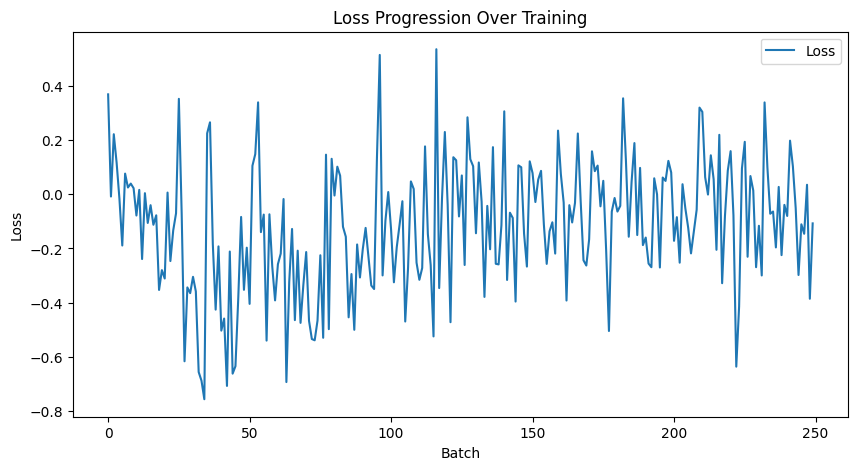

In [102]:
policy_network_y2_bert.plot_losses()

In [103]:
policy_network_y2_bert.evaluate(X_BERT_val, y2_BERT_val)

Accuracy: 0.725
Confusion Matrix:
[[ 14   0   4   9   0   0  19   0   0]
 [  1   0  10   7   0   0   2   0   0]
 [  0   0  19   1   0   0  13   0   3]
 [  0   0   0 287   0   0   8   0   0]
 [  5   0   2   2   0   0  21   0   0]
 [  0   0   2  15   0   0   4   0   0]
 [  0   0   1   3   0   0  86   0   2]
 [  1   0   6   0   0   0  17   0   0]
 [  0   0   1   2   0   0   4   0  29]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.30      0.42        46
           1       0.00      0.00      0.00        20
           2       0.42      0.53      0.47        36
           3       0.88      0.97      0.92       295
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        21
           6       0.49      0.93      0.65        92
           7       0.00      0.00      0.00        24
           8       0.85      0.81      0.83        36

    accuracy                           0.72      

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.725,
 array([[ 14,   0,   4,   9,   0,   0,  19,   0,   0],
        [  1,   0,  10,   7,   0,   0,   2,   0,   0],
        [  0,   0,  19,   1,   0,   0,  13,   0,   3],
        [  0,   0,   0, 287,   0,   0,   8,   0,   0],
        [  5,   0,   2,   2,   0,   0,  21,   0,   0],
        [  0,   0,   2,  15,   0,   0,   4,   0,   0],
        [  0,   0,   1,   3,   0,   0,  86,   0,   2],
        [  1,   0,   6,   0,   0,   0,  17,   0,   0],
        [  0,   0,   1,   2,   0,   0,   4,   0,  29]]),
 '              precision    recall  f1-score   support\n\n           0       0.67      0.30      0.42        46\n           1       0.00      0.00      0.00        20\n           2       0.42      0.53      0.47        36\n           3       0.88      0.97      0.92       295\n           4       0.00      0.00      0.00        30\n           5       0.00      0.00      0.00        21\n           6       0.49      0.93      0.65        92\n           7       0.00      0.00      0.00        

In [104]:
policy_network_y2_bert.evaluate(X_BERT_test, y2_BERT_test)

Accuracy: 0.755
Confusion Matrix:
[[ 18   0   2  11   0   0   6   0   0]
 [  3   0   8   8   0   0   1   0   1]
 [  0   0  34   4   0   0  11   0   0]
 [  0   0   0 274   0   0   8   0   0]
 [  1   0   2   1   0   0  26   0   0]
 [  2   0   2  16   0   0   4   0   0]
 [  0   0   0   5   0   0  89   0   0]
 [  2   0   1   0   0   0  14   0   0]
 [  0   0   1   2   0   0   5   0  38]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.49      0.57        37
           1       0.00      0.00      0.00        21
           2       0.68      0.69      0.69        49
           3       0.85      0.97      0.91       282
           4       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        24
           6       0.54      0.95      0.69        94
           7       0.00      0.00      0.00        17
           8       0.97      0.83      0.89        46

    accuracy                           0.76      

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:137: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


(0.755,
 array([[ 18,   0,   2,  11,   0,   0,   6,   0,   0],
        [  3,   0,   8,   8,   0,   0,   1,   0,   1],
        [  0,   0,  34,   4,   0,   0,  11,   0,   0],
        [  0,   0,   0, 274,   0,   0,   8,   0,   0],
        [  1,   0,   2,   1,   0,   0,  26,   0,   0],
        [  2,   0,   2,  16,   0,   0,   4,   0,   0],
        [  0,   0,   0,   5,   0,   0,  89,   0,   0],
        [  2,   0,   1,   0,   0,   0,  14,   0,   0],
        [  0,   0,   1,   2,   0,   0,   5,   0,  38]]),
 '              precision    recall  f1-score   support\n\n           0       0.69      0.49      0.57        37\n           1       0.00      0.00      0.00        21\n           2       0.68      0.69      0.69        49\n           3       0.85      0.97      0.91       282\n           4       0.00      0.00      0.00        30\n           5       0.00      0.00      0.00        24\n           6       0.54      0.95      0.69        94\n           7       0.00      0.00      0.00        

/var/folders/c5/bdxskntd0gj2_jft4g13_1800000gn/T/ipykernel_80904/2561276948.py:152: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if type(X) == scipy.sparse.csr.csr_matrix:


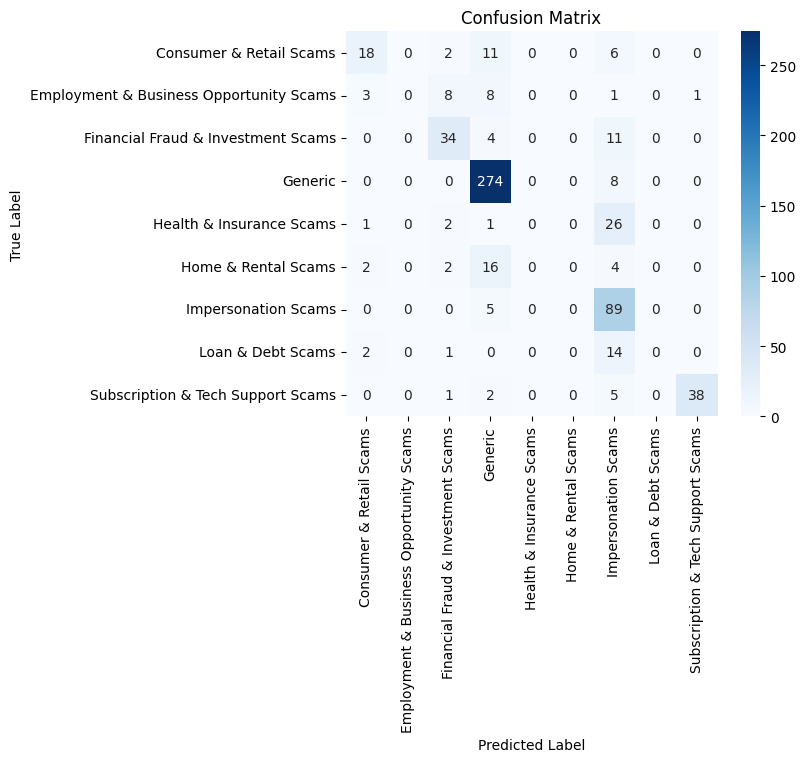

In [105]:
policy_network_y2_bert.plot_confusion_matrix(X_BERT_test, y2_BERT_test, class_names=le.classes_)

#### 4.5.12 Wrapping Up

In [106]:
trained_rl_models_y1 = {
    "SBERT": policy_network_y1_sbert,
    "CountVectorizer": policy_network_y1_cv,
    "TF-IDF": policy_network_y1_tf_idf,
    "Word2Vec": policy_network_y1_w2v,
    "BERT": policy_network_y1_bert
}

trained_rl_models_y2 = {
    "SBERT": policy_network_y2_sbert,
    "CountVectorizer": policy_network_y2_cv,
    "TF-IDF": policy_network_y2_tf_idf,
    "Word2Vec": policy_network_y2_w2v,
    "BERT": policy_network_y2_bert
}

test_sets_y1 = {
    "SBERT": (X_SBERT_test, y1_SBERT_test),
    "CountVectorizer": (X_CV_test, y1_CV_test),
    "TF-IDF": (X_TFIDF_test, y1_TFIDF_test),
    "Word2Vec": (X_W2V_test, y1_W2V_test),
    "BERT": (X_BERT_test, y1_BERT_test)
}

test_sets_y2 = {
    "SBERT": (X_SBERT_test, y2_SBERT_test),
    "CountVectorizer": (X_CV_test, y2_CV_test),
    "TF-IDF": (X_TFIDF_test, y2_TFIDF_test),
    "Word2Vec": (X_W2V_test, y2_W2V_test),
    "BERT": (X_BERT_test, y2_BERT_test)
}


In [143]:
import pandas as pd
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.simplefilter("ignore", DeprecationWarning)  # 🔇 Silences all DeprecationWarnings
warnings.simplefilter("ignore", UndefinedMetricWarning)

# Define the column structure
columns = [
    "Algorithm", "Embedding", "Type",
    "y1_Accuracy", "y1_Precision", "y1_Recall", "y1_F1_Score",
    "y2_Accuracy", "y2_Precision", "y2_Recall", "y2_F1_Score"
]

# List to store results
results = []

# Evaluate y1 (binary classification; "average" for metrics)
for key, model in trained_rl_models_y1.items():
    X_test, y_test = test_sets_y1[key]
    accuracy, precision, recall, f1 = model.evaluate_raw(X_test, y_test, "binary")

    results.append([
        "Policy-based Reinforcement Learning",  # Algorithm
        key,  # Embedding
        "Test Set",  # Type
        accuracy, precision, recall, f1,  # y1 metrics
        0, 0, 0, 0  # Temporary placeholders for y2 metrics (ensuring 11 columns)
    ])

# Evaluate y2 (multi-class classification; "weighted" for metrics)
for key, model in trained_rl_models_y2.items():
    X_test, y_test = test_sets_y2[key]
    accuracy, precision, recall, f1 = model.evaluate_raw(X_test, y_test, "weighted")

    # Find the corresponding row in `results` and update y2 values
    for row in results:
        if row[1] == key:  # Match the embedding type
            row[7:] = [accuracy, precision, recall, f1]  # Update y2 columns
            break

# Convert results to a DataFrame
df_results = pd.DataFrame(results, columns=columns)

df_results

Algorithm        Embedding      Type  \
0  Policy-based Reinforcement Learning            SBERT  Test Set   
1  Policy-based Reinforcement Learning  CountVectorizer  Test Set   
2  Policy-based Reinforcement Learning           TF-IDF  Test Set   
3  Policy-based Reinforcement Learning         Word2Vec  Test Set   
4  Policy-based Reinforcement Learning             BERT  Test Set   

   y1_Accuracy  y1_Precision  y1_Recall  y1_F1_Score  y2_Accuracy  \
0     0.965000      0.971429   0.962264     0.966825     0.778333   
1     0.885000      0.977011   0.801887     0.880829     0.656667   
2     0.891667      0.966790   0.823899     0.889643     0.670000   
3     0.906667      0.958042   0.861635     0.907285     0.588333   
4     0.950000      0.967532   0.937107     0.952077     0.755000   

   y2_Precision  y2_Recall  y2_F1_Score  
0      0.667637   0.778333     0.715841  
1      0.578810   0.656667     0.594459  
2      0.574529   0.670000     0.599667  
3      0.456956   0.588333     0.505368  
4      0.659131   0.755000     0.695100

### 4.6. Multi Task Learning - Training and Evaluation (Neural Network) 🧠

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy

#### Custom Dataset Class for Multi-Task Learning
1. **Embedding Features**: BERT embeddings for caller and recipient texts.
2. **Labels**: Binary classification labels for scam detection. Float32 is used here for BCE loss.
3. **Types**: Categorical labels for scam type classification. Int64 is used here for CrossEntropy loss.

In [109]:
class MultiTaskDataset(Dataset):
    def __init__(self, embedding, labels, types):
        self.X = torch.tensor(embedding, dtype=torch.float32)
        # For binary task, we use float labels
        self.labels = torch.tensor(labels.values if hasattr(labels, "values") else labels, dtype=torch.float32)
        # For multi-class, targets should be long (integer encoded)
        self.types = torch.tensor(types.values if hasattr(types, "values") else types, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx], self.types[idx]

#### Multi-Task Learning Model Architecture

The model processes input features through shared layers and then splits into two separate heads for different tasks: one for binary classification and another for multi-class classification.

```mermaid
flowchart LR
    input[Input Features] -- 1536(from BERT) --> shared

    subgraph shared[Shared Layers]
        direction TB
        fc1[Linear Layer<br/>in: <br/>] -- 512 --> relu[ReLU] --> dropout[Dropout<br/>p=0.2]
    end

    shared -- 512 --> label_head[Label Head<br/>Linear Layer]
    shared -- 512 --> type_head[Type Head<br/>Linear Layer]

    label_head -- 1 --> label_out[Label Logits<br/>Binary Classification]
    type_head -- 12(from the number_types) --> type_out[Type Logits<br/>Multi-class Classification]
```

In this architecture:

* Shared Layers: Extract features from the input using a linear layer, ReLU, and dropout.
* Binary Head: Produces a single logit for binary classification.
* Multi-class Head: Produces logits for each class in a multi-class setting.

In [110]:
class MultiTaskNet(nn.Module):
    def __init__(self, feature_dimension, num_types):
        super(MultiTaskNet, self).__init__()
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(feature_dimension, 512),
            nn.ReLU(),
            nn.Dropout(0.2) # Regularization for preventing overfitting
        )
        # Head for binary scam label prediction
        self.label_head = nn.Linear(512, 1)  # output logit for binary classification

        # Head for multi-class scam type prediction
        self.type_head = nn.Linear(512, num_types)

    def forward(self, x):
        shared_rep = self.shared(x)
        # For binary classification, we’ll use BCEWithLogitsLoss, so no sigmoid here.
        label_logits = self.label_head(shared_rep)
        # For type classification, output logits (to be used with CrossEntropyLoss)
        type_logits = self.type_head(shared_rep)
        return label_logits, type_logits

#### Multi-Task Learning Model

1. **Loss Functions**:
   - **Binary Classification**: Binary Cross-Entropy Loss
   - **Multi-class Classification**: Cross-Entropy Loss
2. **Optimizer**: Adam Optimizer with a default learning rate of 0.001


In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader

class MutltiTaskModel:
    def __init__(self, X_train, y1_train, y2_train, num_types, batch_size=32, lr=1e-3):
        self.model = MultiTaskNet(X_train.shape[1], num_types)

        # Determine device (cuda, mps, or cpu)
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            self.device = torch.device("mps")
        else:
            self.device = torch.device("cpu")
        self.model.to(self.device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion_label = nn.BCEWithLogitsLoss()
        self.criterion_type = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.input_dim = X_train.shape[1]

        # Create DataLoader for training
        self.train_dataset = MultiTaskDataset(X_train, y1_train, y2_train)
        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)

        # Lists to store losses for plotting
        self.train_label_losses = []
        self.train_type_losses = []

        # For saving the best model
        self.best_model_weights = None

    def summary(self):
        """
        Prints the model summary.
        """
        self.model.to("cpu")
        summary(self.model, (self.batch_size, self.input_dim))
        self.model.to(self.device)

    def train(self, num_epochs):
        best_loss = float('inf')

        for epoch in range(num_epochs):
            self.model.train()
            total_loss_label = 0.0
            total_loss_type = 0.0
            num_batches = 0

            for inputs, labels, types in self.train_loader:
                inputs, labels, types = inputs.to(self.device), labels.to(self.device), types.to(self.device)

                self.optimizer.zero_grad()
                label_logits, type_logits = self.model(inputs)

                loss_label = self.criterion_label(label_logits.view(-1), labels)
                loss_type = self.criterion_type(type_logits, types)

                loss = loss_label + loss_type
                loss.backward()
                self.optimizer.step()

                total_loss_label += loss_label.item()
                total_loss_type += loss_type.item()
                num_batches += 1

            # Calculate average loss for the epoch
            avg_loss_label = total_loss_label / num_batches
            avg_loss_type = total_loss_type / num_batches
            total_loss = avg_loss_label + avg_loss_type

            # Store losses for plotting
            self.train_label_losses.append(avg_loss_label)
            self.train_type_losses.append(avg_loss_type)

            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}")
                print(f"Average Loss (Label): {avg_loss_label:.4f}")
                print(f"Average Loss (Type): {avg_loss_type:.4f}")
                print(f"Total Loss: {total_loss:.4f}\n")

            # Save best model weights
            if total_loss < best_loss:
                best_loss = total_loss
                self.best_model_weights = self.model.state_dict()

        print("Training complete.")

    def plot_losses(self):
        """
        Plots the losses for label and type predictions during training.
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_label_losses, label="Label Loss")
        plt.plot(self.train_type_losses, label="Type Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Losses")
        plt.legend()
        plt.show()

    def predict(self, X):
        """
        Makes predictions for the given inputs X.

        Parameters:
            X (numpy array or tensor): Input features.

        Returns:
            tuple: (predicted_label, predicted_type) where predicted_label is the binary prediction (0 or 1)
                   and predicted_type is the predicted class for multi-class task.
        """
        self.model.eval()
        with torch.no_grad():
            inputs = torch.tensor(X, dtype=torch.float32).to(self.device)
            label_logits, type_logits = self.model(inputs)
            label_pred = (torch.sigmoid(label_logits) >= 0.5).cpu().numpy().astype(int) # Convert to 0 or 1 instead of floating point from sigmoid
            type_pred = torch.argmax(type_logits, dim=1).cpu().numpy()

        return label_pred, type_pred

    def evaluate(self, X, y1, y2):
        """
        Evaluates the model on the provided dataset and computes various performance metrics.

        Parameters:
            X (array-like): Input features.
            y1 (array-like): True labels for binary classification.
            y2 (array-like): True labels for multi-class classification.

        Returns:
            tuple: A nested tuple containing:
                - accuracy (float): Overall accuracy of the model.
                - precision (float): Precision score.
                - recall (float): Recall score.
                - f1 (float): F1 score.
                - conf_matrix (array-like): Confusion matrix.
                - class_report (str): Text summary of the precision, recall, and f1-score for each class.
        """
        y1_pred, y2_pred = self.predict(X)

        # Binary classification metrics
        accuracy_label = accuracy_score(y1, y1_pred)
        precision_label = precision_score(y1, y1_pred, zero_division=0)
        recall_label = recall_score(y1, y1_pred, zero_division=0)
        f1_label = f1_score(y1, y1_pred, zero_division=0)
        conf_matrix_label = confusion_matrix(y1, y1_pred)

        # Multi-class classification metrics
        accuracy_type = accuracy_score(y2, y2_pred)
        precision_type = precision_score(y2, y2_pred, average='weighted', zero_division=0)
        recall_type = recall_score(y2, y2_pred, average='weighted', zero_division=0)
        f1_type = f1_score(y2, y2_pred, average='weighted', zero_division=0)
        conf_matrix_type = confusion_matrix(y2, y2_pred)

        return (accuracy_label, precision_label, recall_label, f1_label, conf_matrix_label), \
               (accuracy_type, precision_type, recall_type, f1_type, conf_matrix_type)

    def plot_confusion_matrix(self, X, y1, y2, labels):
        """
        Plots the confusion matrix for the model's predictions.

        Parameters:
            X (array-like): Input features.
            y1 (array-like): True labels for binary classification.
            y2 (array-like): True labels for multi-class classification.
            labels (list): List of label names to be used in the plot axes.
        """
        y1_pred, y2_pred = self.predict(X)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(confusion_matrix(y1, y1_pred), annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Not Scam", "Scam"], yticklabels=["Not Scam", "Scam"])
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Binary Classification")

        plt.subplot(1, 2, 2)
        sns.heatmap(confusion_matrix(y2, y2_pred), annot=True, fmt="d", cmap="Blues",
                    xticklabels=labels, yticklabels=labels)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Multi-Class Classification")

        plt.tight_layout()
        plt.show()

#### Training the Multi-Task Learning Model

- The model is trained for **5 epochs** with a batch size of **32**.
- **Binary Classification** and **Multi-class Classification** losses are computed separately.

In [112]:
# Initialize the multi_task_model for the different embeddings
multi_task_models = {}

for embedding, data in embedding_data.items():
    print(f"Training Multi-Task Model for {embedding}...")

    # Convert sparse matrix to dense if needed
    X_train = data["X_train"].toarray() if scipy.sparse.issparse(data["X_train"]) else data["X_train"]

    multi_task_model = MutltiTaskModel(X_train, data["y1_train"], data["y2_train"],
                                      num_types=len(le.classes_))

    # Add the model to the dictionary
    multi_task_models[embedding] = multi_task_model

Training Multi-Task Model for Count Vectorizer...
Training Multi-Task Model for TF-IDF...
Training Multi-Task Model for Word2Vec...
Training Multi-Task Model for DistilBERT...
Training Multi-Task Model for SBERT...


In [113]:
# Get summary of each model
for embedding, model in multi_task_models.items():
    print(f"Summary for {embedding} model:")
    model.summary()
    print()

Summary for Count Vectorizer model:
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 512]             --
|    └─Linear: 2-1                       [-1, 32, 512]             393,728
|    └─ReLU: 2-2                         [-1, 32, 512]             --
|    └─Dropout: 2-3                      [-1, 32, 512]             --
├─Linear: 1-2                            [-1, 32, 1]               513
├─Linear: 1-3                            [-1, 32, 9]               4,617
Total params: 398,858
Trainable params: 398,858
Non-trainable params: 0
Total mult-adds (M): 0.79
Input size (MB): 0.09
Forward/backward pass size (MB): 0.13
Params size (MB): 1.52
Estimated Total Size (MB): 1.74

Summary for TF-IDF model:
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 512]             --
|    └─Linear: 2-1                       [-1, 32, 512]             393,728


In [114]:
# Train each model
for embedding, model in multi_task_models.items():
    print(f"Training {embedding} model...")
    model.train(num_epochs=100)
    print()

Training Count Vectorizer model...
Epoch 1/100
Average Loss (Label): 0.6475
Average Loss (Type): 1.9072
Total Loss: 2.5547

Epoch 11/100
Average Loss (Label): 0.1386
Average Loss (Type): 0.4214
Total Loss: 0.5600

Epoch 21/100
Average Loss (Label): 0.1151
Average Loss (Type): 0.2815
Total Loss: 0.3965

Epoch 31/100
Average Loss (Label): 0.1094
Average Loss (Type): 0.2488
Total Loss: 0.3581

Epoch 41/100
Average Loss (Label): 0.1110
Average Loss (Type): 0.2367
Total Loss: 0.3478

Epoch 51/100
Average Loss (Label): 0.1097
Average Loss (Type): 0.2381
Total Loss: 0.3478

Epoch 61/100
Average Loss (Label): 0.1084
Average Loss (Type): 0.2316
Total Loss: 0.3400

Epoch 71/100
Average Loss (Label): 0.1093
Average Loss (Type): 0.2302
Total Loss: 0.3394

Epoch 81/100
Average Loss (Label): 0.1059
Average Loss (Type): 0.2304
Total Loss: 0.3363

Epoch 91/100
Average Loss (Label): 0.1080
Average Loss (Type): 0.2308
Total Loss: 0.3388

Training complete.

Training TF-IDF model...
Epoch 1/100
Average L

#### Loss Graphs

Losses for Count Vectorizer model:


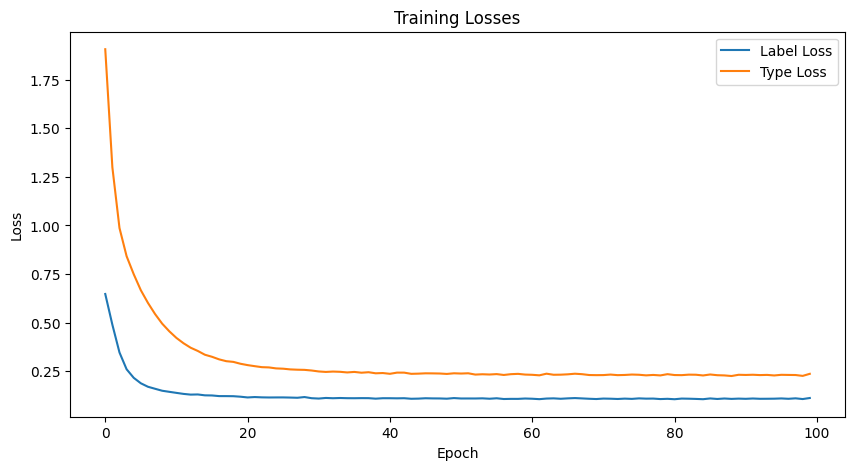


Losses for TF-IDF model:


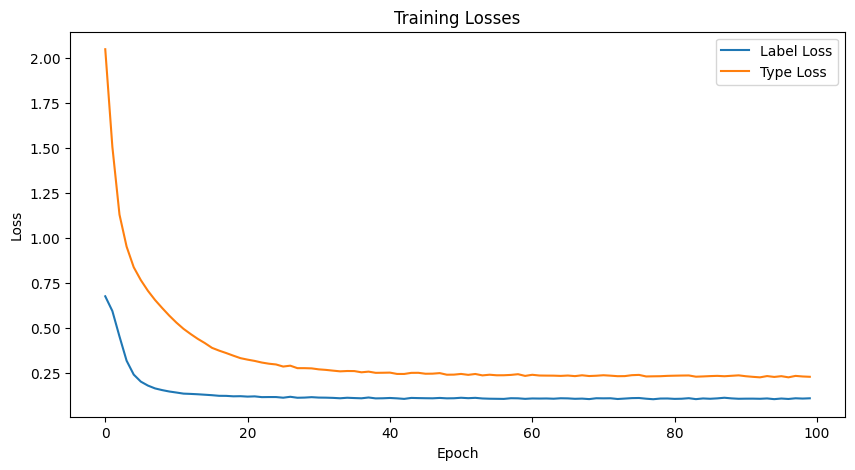


Losses for Word2Vec model:


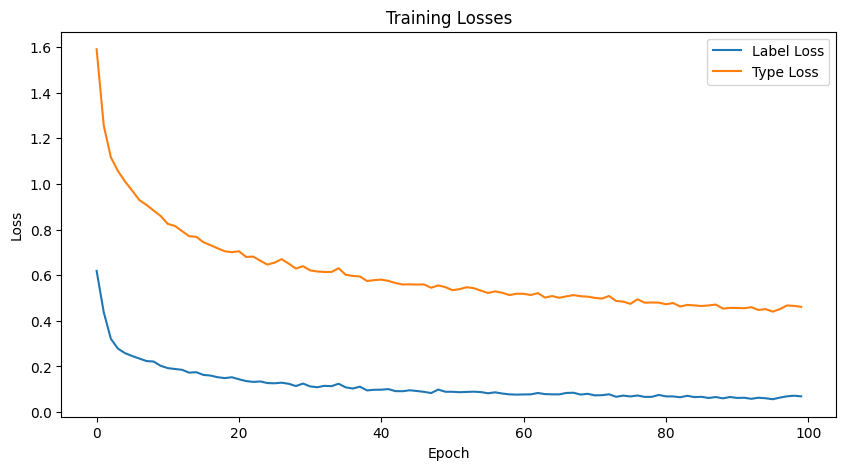


Losses for DistilBERT model:


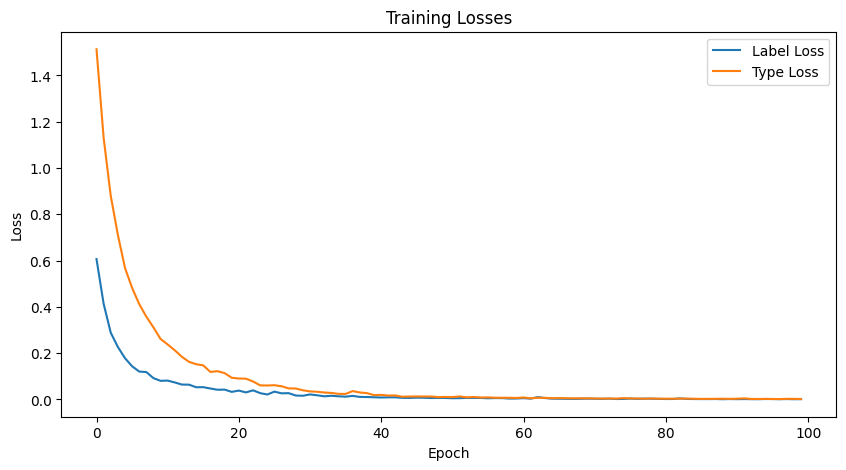


Losses for SBERT model:


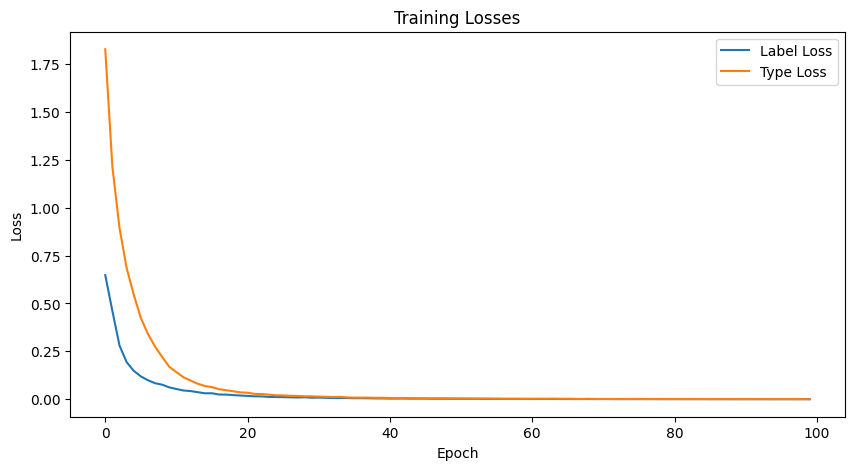

In [115]:
# Plot the losses for each model
for embedding, model in multi_task_models.items():
    print(f"Losses for {embedding} model:")
    model.plot_losses()
    print()

In [116]:
trained_rl_models_y1 = {
    "SBERT": policy_network_y1_sbert,
    "CountVectorizer": policy_network_y1_cv,
    "TF-IDF": policy_network_y1_tf_idf,
    "Word2Vec": policy_network_y1_w2v,
    "BERT": policy_network_y1_bert
}

trained_rl_models_y2 = {
    "SBERT": policy_network_y2_sbert,
    "CountVectorizer": policy_network_y2_cv,
    "TF-IDF": policy_network_y2_tf_idf,
    "Word2Vec": policy_network_y2_w2v,
    "BERT": policy_network_y2_bert
}

test_sets_y1 = {
    "SBERT": (X_SBERT_test, y1_SBERT_test),
    "CountVectorizer": (X_CV_test, y1_CV_test),
    "TF-IDF": (X_TFIDF_test, y1_TFIDF_test),
    "Word2Vec": (X_W2V_test, y1_W2V_test),
    "BERT": (X_BERT_test, y1_BERT_test)
}

test_sets_y2 = {
    "SBERT": (X_SBERT_test, y2_SBERT_test),
    "CountVectorizer": (X_CV_test, y2_CV_test),
    "TF-IDF": (X_TFIDF_test, y2_TFIDF_test),
    "Word2Vec": (X_W2V_test, y2_W2V_test),
    "BERT": (X_BERT_test, y2_BERT_test)
}

#### Model Evaluation on the Validation Set

In [117]:
# Evaluate each of the models on the validation set
results = []

for embedding, model in multi_task_models.items():
    print(f"Evaluating {embedding} model...")

    # Convert validation data to dense if needed
    X_val = embedding_data[embedding]["X_val"].toarray() if scipy.sparse.issparse(embedding_data[embedding]["X_val"]) else embedding_data[embedding]["X_val"]

    eval_label, eval_type = model.evaluate(X_val,
                                         embedding_data[embedding]["y1_val"],
                                         embedding_data[embedding]["y2_val"])

    row = {
        "Algorithm": "Multi-Task Learning",
        "Embedding": embedding,
        "Type": "Validation Set",
        "y1_Accuracy": round(eval_label[0], 4),
        "y1_Precision": round(eval_label[1], 4),
        "y1_Recall": round(eval_label[2], 4),
        "y1_F1_Score": round(eval_label[3], 4),
        "y2_Accuracy": round(eval_type[0], 4),
        "y2_Precision": round(eval_type[1], 4),
        "y2_Recall": round(eval_type[2], 4),
        "y2_F1_Score": round(eval_type[3], 4)
    }

    results.append(row)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Append results to the combined dataframe
combined_results_df = pd.concat([combined_results_df, results_df], ignore_index=True)

# Display results
results_df

Evaluating Count Vectorizer model...
Evaluating TF-IDF model...
Evaluating Word2Vec model...
Evaluating DistilBERT model...
Evaluating SBERT model...


Algorithm         Embedding            Type  y1_Accuracy  \
0  Multi-Task Learning  Count Vectorizer  Validation Set       0.8733   
1  Multi-Task Learning            TF-IDF  Validation Set       0.8717   
2  Multi-Task Learning          Word2Vec  Validation Set       0.9633   
3  Multi-Task Learning        DistilBERT  Validation Set       0.9833   
4  Multi-Task Learning             SBERT  Validation Set       0.9850   

   y1_Precision  y1_Recall  y1_F1_Score  y2_Accuracy  y2_Precision  y2_Recall  \
0        0.9288     0.8131       0.8671       0.6767        0.6503     0.6767   
1        0.9254     0.8131       0.8656       0.6733        0.6469     0.6733   
2        0.9863     0.9410       0.9631       0.7533        0.7125     0.7533   
3        0.9805     0.9869       0.9837       0.9600        0.9608     0.9600   
4        0.9744     0.9967       0.9854       0.9600        0.9624     0.9600   

   y2_F1_Score  
0       0.6585  
1       0.6561  
2       0.7285  
3       0.9592  
4       0.9588

#### Model Evaluation on the Test Set

Evaluating Count Vectorizer model...


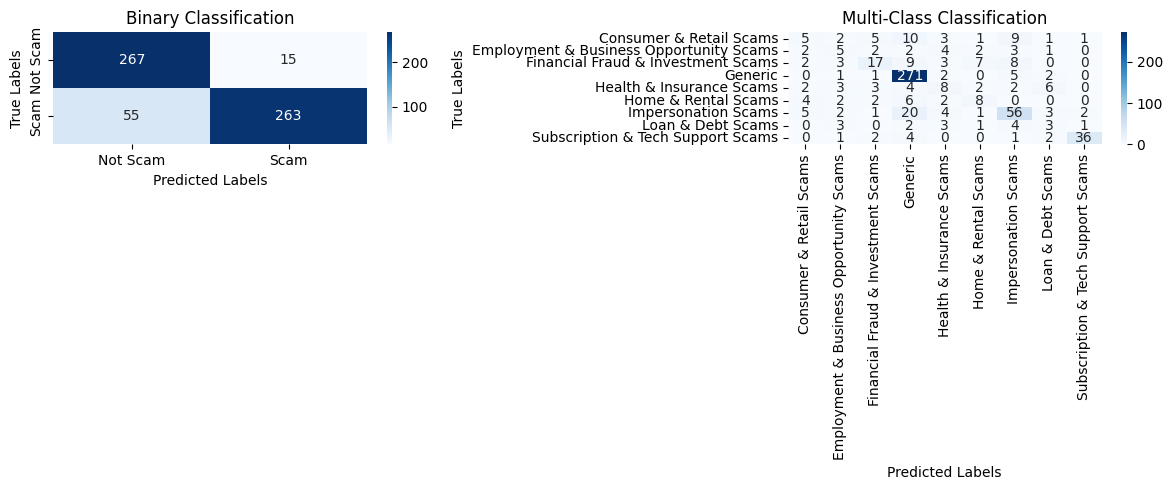

Evaluating TF-IDF model...


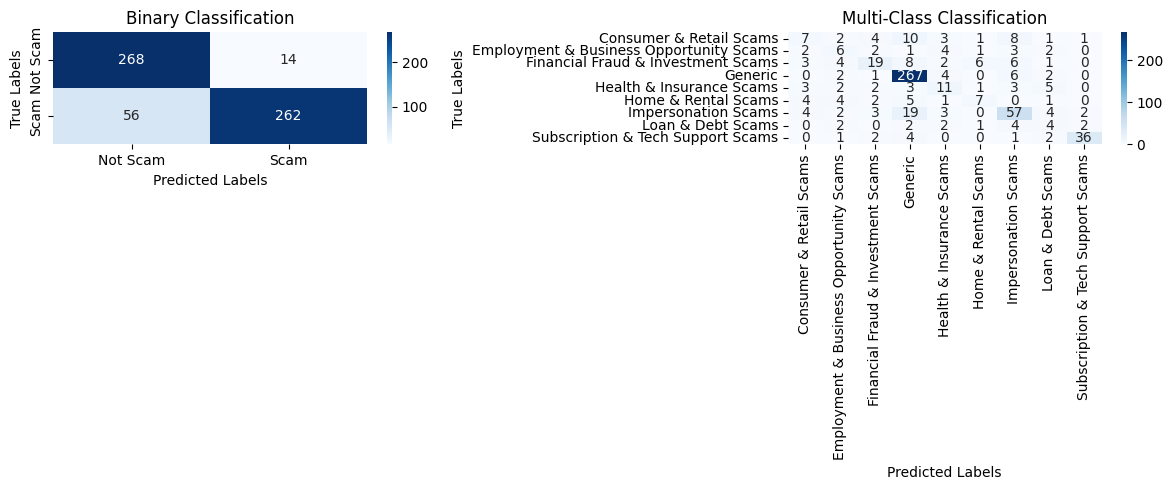

Evaluating Word2Vec model...


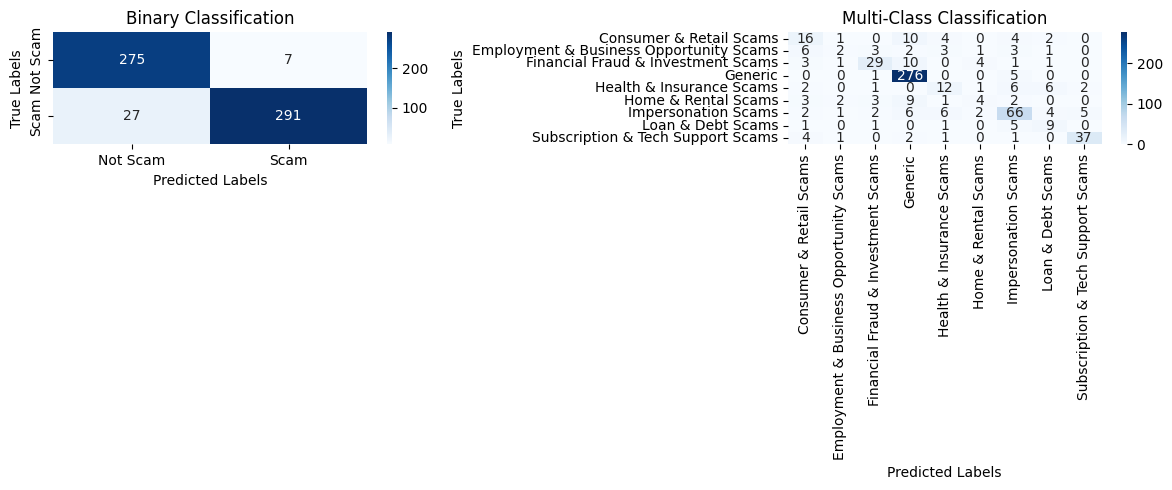

Evaluating DistilBERT model...


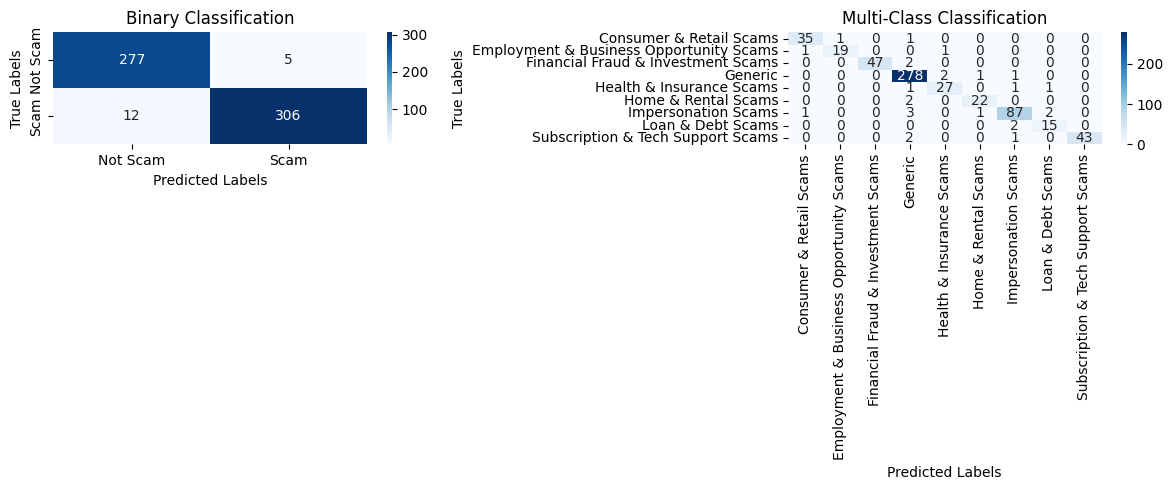

Evaluating SBERT model...


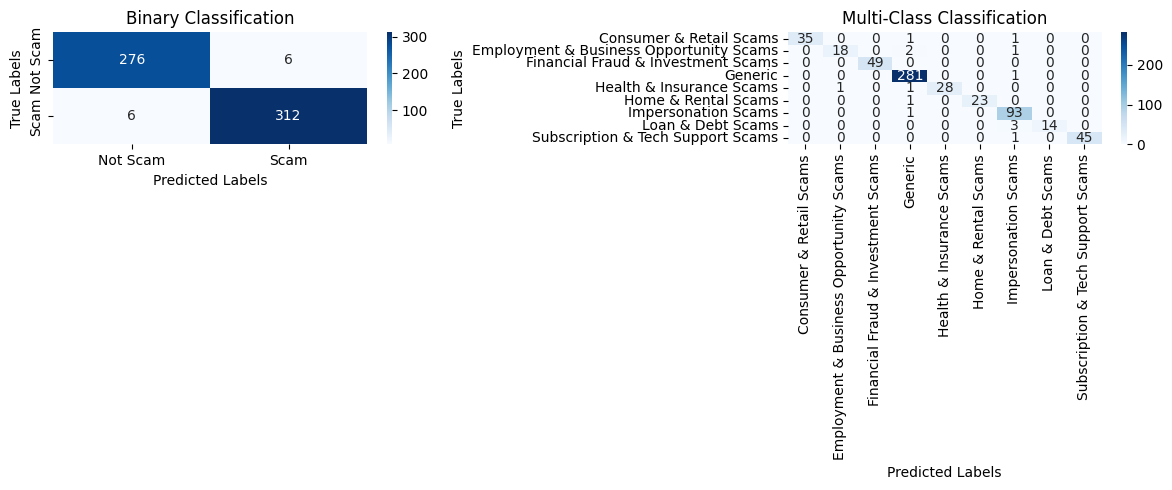

Algorithm         Embedding      Type  y1_Accuracy  y1_Precision  \
0  Multi-Task Learning  Count Vectorizer  Test Set       0.8833        0.9460   
1  Multi-Task Learning            TF-IDF  Test Set       0.8833        0.9493   
2  Multi-Task Learning          Word2Vec  Test Set       0.9433        0.9765   
3  Multi-Task Learning        DistilBERT  Test Set       0.9717        0.9839   
4  Multi-Task Learning             SBERT  Test Set       0.9800        0.9811   

   y1_Recall  y1_F1_Score  y2_Accuracy  y2_Precision  y2_Recall  y2_F1_Score  
0     0.8270       0.8826       0.6817        0.6555     0.6817       0.6634  
1     0.8239       0.8822       0.6900        0.6736     0.6900       0.6775  
2     0.9151       0.9448       0.7517        0.7279     0.7517       0.7352  
3     0.9623       0.9730       0.9550        0.9555     0.9550       0.9550  
4     0.9811       0.9811       0.9767        0.9774     0.9767       0.9764

In [118]:
# Evaluate each of the models on the test set, and in addition, also plot out the confusion matrices
results = []

for embedding, model in multi_task_models.items():
    print(f"Evaluating {embedding} model...")

    # Convert test data to dense if needed
    X_test = embedding_data[embedding]["X_test"].toarray() if scipy.sparse.issparse(embedding_data[embedding]["X_test"]) else embedding_data[embedding]["X_test"]

    eval_label, eval_type = model.evaluate(X_test,
                                         embedding_data[embedding]["y1_test"],
                                         embedding_data[embedding]["y2_test"])

    row = {
        "Algorithm": "Multi-Task Learning",
        "Embedding": embedding,
        "Type": "Test Set",
        "y1_Accuracy": round(eval_label[0], 4),
        "y1_Precision": round(eval_label[1], 4),
        "y1_Recall": round(eval_label[2], 4),
        "y1_F1_Score": round(eval_label[3], 4),
        "y2_Accuracy": round(eval_type[0], 4),
        "y2_Precision": round(eval_type[1], 4),
        "y2_Recall": round(eval_type[2], 4),
        "y2_F1_Score": round(eval_type[3], 4)
    }

    results.append(row)

    # Plot confusion matrix for the test set
    model.plot_confusion_matrix(X_test,
                                embedding_data[embedding]["y1_test"],
                                embedding_data[embedding]["y2_test"],
                                le.classes_)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Append results to the combined dataframe
combined_results_df = pd.concat([combined_results_df, results_df], ignore_index=True)

# Display results
results_df

### 4.7. Naive Bayes w/ SVM

[**Objective**] Use Naive Bayes and Support Vector Machine to do multiclass and binary classification


---


[**Problem**]
- Naive Bayes is a quick method to classify text, but it assumes each word is independent of every other word. That assumption is not really true in natural language.
- Because of that, NB can make mistakes if certain combinations of words appear together.


---


[**Goal**]
The goal is to improve Naive Bayes by removing the “weird” or “confusing” training samples that cause NB to make errors.


---


[**Idea**]

Combine NB and SVM
- SVM  tries to find the best boundary between “spam” and “not spam.” It does so by maximizing the gap between these two classes.
- In SVM-NB, we do a quick pass with Naive Bayes, then we remove training samples that seem to cause confusion before retraining NB.
- The “trimming” step (removing confusing samples) is somewhat inspired by how SVMs focus on the most representative samples.


---

[Algorithm]

1. Initial NB Classification
2. Find Nearest Neighbors
3. Trimming (Removing Confusing Samples)
4. Retrain NB on the Trimmed Set



---

[Add. Notes]

Multinomial Bayes changed to Gaussian bayes because most values are continuous (have decimals).

#### 4.7.1 This part is the implementation on **multi class** NB-SVM


In [119]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

In [120]:
# [BEN] My own preprocessing here. Accuracy not bussin at all


# df = pd.read_csv('generic_changed_dataset.csv')
# X_text = df["dialogue"].astype(str).values
# y_type = df['type']           # This is the multi-class scam category

# vectorizer = CountVectorizer(stop_words='english')  # Optionally remove common English words
# X_features = vectorizer.fit_transform(X_text)

# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y_type)

# X_train, X_test, y_train, y_test = train_test_split(
#     X_features, y_encoded, test_size=0.2, random_state=42
# )

In [121]:
# nb_classifier = MultinomialNB()
nb_classifier = GaussianNB()
nb_classifier.fit(X_BERT_train, y2_BERT_train)

y_train_pred = nb_classifier.predict(X_BERT_train)
y_pred = nb_classifier.predict(X_BERT_test)

print("---------- First NB Training (Multi-Class) ----------")
print(classification_report(y2_BERT_test, y_pred, target_names=le.classes_))

---------- First NB Training (Multi-Class) ----------
                                         precision    recall  f1-score   support

                Consumer & Retail Scams       0.62      0.92      0.74        37
Employment & Business Opportunity Scams       0.67      0.76      0.71        21
     Financial Fraud & Investment Scams       1.00      0.90      0.95        49
                                Generic       0.95      0.81      0.88       282
               Health & Insurance Scams       0.61      0.83      0.70        30
                    Home & Rental Scams       0.65      0.83      0.73        24
                    Impersonation Scams       0.73      0.70      0.72        94
                      Loan & Debt Scams       0.37      0.76      0.50        17
      Subscription & Tech Support Scams       0.90      0.80      0.85        46

                               accuracy                           0.81       600
                              macro avg       0.72   

In [122]:
nbrs = NearestNeighbors(n_neighbors=2, metric='euclidean', algorithm='brute').fit(X_BERT_train)
distances, indices = nbrs.kneighbors(X_BERT_train)

keep_indices = []
for i in range(X_BERT_train.shape[0]):
    # The first neighbor is the sample itself; use the second one
    nn_index = indices[i][1]
    if y_train_pred[i] == y_train_pred[nn_index]:
        keep_indices.append(i)

X_train_trimmed = X_BERT_train[keep_indices]
y_train_trimmed = y2_BERT_train[np.array(keep_indices)]

print("Original training set size:", X_BERT_train.shape[0])
print("Trimmed training set size:", X_train_trimmed.shape[0])

Original training set size: 800
Trimmed training set size: 662


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [123]:
nb_classifier_trimmed = GaussianNB()
nb_classifier_trimmed.fit(X_train_trimmed, y_train_trimmed)

y_pred_trimmed = nb_classifier_trimmed.predict(X_BERT_test)
print("---------- SVM-NB Training (Multi-Class) ----------")
print(classification_report(y2_BERT_test, y_pred_trimmed, target_names=le.classes_))

---------- SVM-NB Training (Multi-Class) ----------
                                         precision    recall  f1-score   support

                Consumer & Retail Scams       0.57      0.84      0.68        37
Employment & Business Opportunity Scams       0.67      0.76      0.71        21
     Financial Fraud & Investment Scams       0.96      0.92      0.94        49
                                Generic       0.95      0.77      0.85       282
               Health & Insurance Scams       0.52      0.80      0.63        30
                    Home & Rental Scams       0.67      0.75      0.71        24
                    Impersonation Scams       0.69      0.72      0.70        94
                      Loan & Debt Scams       0.33      0.71      0.45        17
      Subscription & Tech Support Scams       0.95      0.78      0.86        46

                               accuracy                           0.78       600
                              macro avg       0.70     

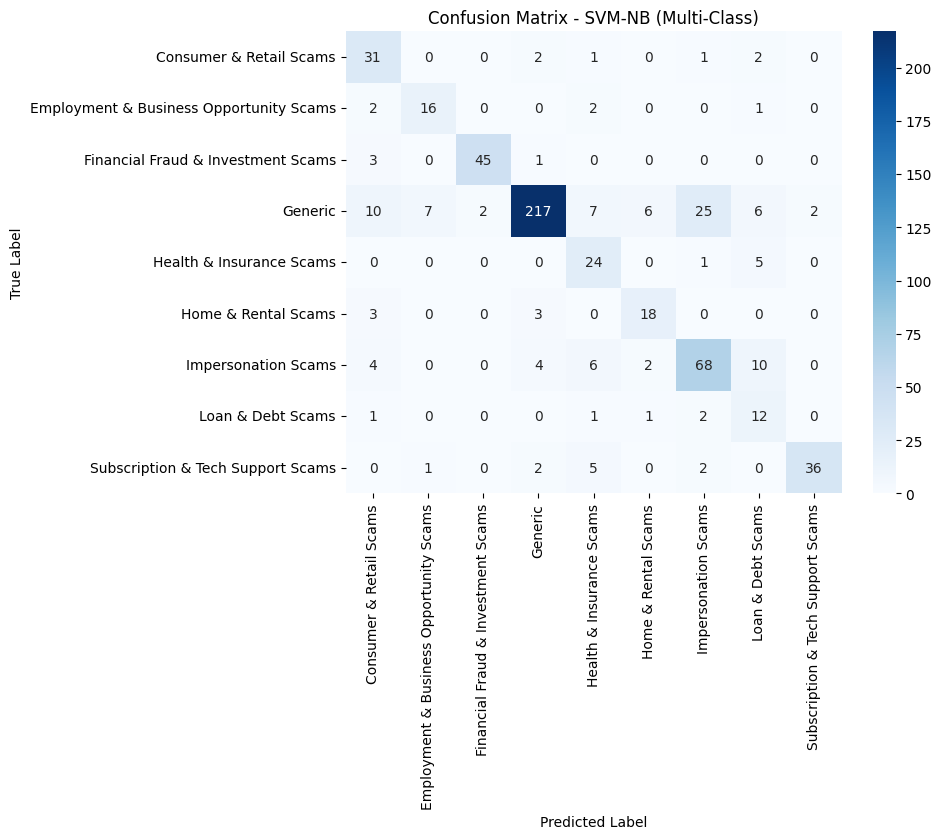

In [124]:
def plot_conf_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_conf_matrix(y2_BERT_test, y_pred_trimmed, "Confusion Matrix - SVM-NB (Multi-Class)", le.classes_)

#### 4.7.2 This part is implementation on the **binary** classification

In [125]:
nb = GaussianNB()
nb.fit(X_BERT_train, y1_BERT_train)

# Get predictions on the training set
train_preds = nb.predict(X_BERT_train)

# Use NearestNeighbors for trimming
nn = NearestNeighbors(n_neighbors=2, metric='euclidean')
nn.fit(X_BERT_train)
distances, indices = nn.kneighbors(X_BERT_train)

samples_to_remove = []
for i in range(X_BERT_train.shape[0]):
    # The first neighbor is the sample itself; the second is the nearest different sample
    neighbor_idx = indices[i, 1]
    if train_preds[i] != train_preds[neighbor_idx]:
        samples_to_remove.append(i)

mask = np.ones(X_BERT_train.shape[0], dtype=bool)
mask[samples_to_remove] = False



In [126]:
X_train_trimmed = X_BERT_train[mask]
y_train_trimmed = y1_BERT_train[mask]

nb_trimmed = GaussianNB()
nb_trimmed.fit(X_train_trimmed, y_train_trimmed)

y_test_preds = nb_trimmed.predict(X_BERT_test)

print("Accuracy on Test Set (Binary):", accuracy_score(y1_BERT_test, y_test_preds))
print("\nClassification Report (Binary):\n", classification_report(y1_BERT_test, y_test_preds))

Accuracy on Test Set (Binary): 0.845

Classification Report (Binary):
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       282
           1       0.84      0.88      0.86       318

    accuracy                           0.84       600
   macro avg       0.85      0.84      0.84       600
weighted avg       0.85      0.84      0.84       600



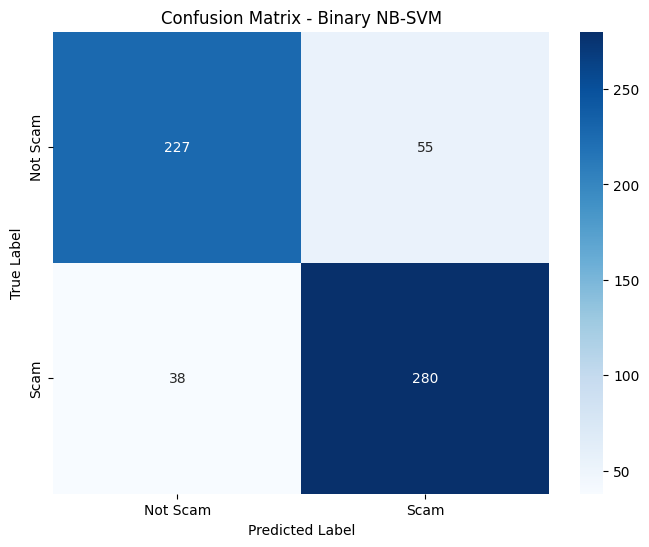

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y1_BERT_test, y_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Scam", "Scam"],
            yticklabels=["Not Scam", "Scam"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Binary NB-SVM")
plt.show()

#### 4.7.3 This part is the integrated of both binary and multiclass and collating to `combined_results_df`

In [128]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

array_embeddings = {"Count Vectorizer", "TF-IDF"}

results_nbsvm = []

for embedding, data in embedding_data.items():
    print(f"\n########## NB-SVM for Embedding = {embedding} ##########")

    if embedding in array_embeddings:
        X_train_full = data["X_train"].toarray()
        X_val_full   = data["X_val"].toarray()
        X_test_full  = data["X_test"].toarray()
    else:
        X_train_full = data["X_train"]
        X_val_full   = data["X_val"]
        X_test_full  = data["X_test"]

    y1_train = data["y1_train"]
    y1_val   = data["y1_val"]
    y1_test  = data["y1_test"]

    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train_full, y1_train)

    nbrs = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(X_train_full)
    distances, indices = nbrs.kneighbors(X_train_full)
    keep_indices = []
    train_preds = nb_classifier.predict(X_train_full)

    for i in range(X_train_full.shape[0]):
        nn_index = indices[i, 1]
        if train_preds[i] == train_preds[nn_index]:
            keep_indices.append(i)

    X_train_trimmed = X_train_full[keep_indices]
    y1_train_trimmed = y1_train.iloc[keep_indices] if hasattr(y1_train, "iloc") else y1_train[np.array(keep_indices)]

    nb_classifier_trimmed = GaussianNB()
    nb_classifier_trimmed.fit(X_train_trimmed, y1_train_trimmed)

    y1_val_pred  = nb_classifier_trimmed.predict(X_val_full)
    avg = "binary"
    y1_val_acc  = accuracy_score(y1_val, y1_val_pred)
    y1_val_prec = precision_score(y1_val, y1_val_pred, average=avg, zero_division=0)
    y1_val_rec  = recall_score(y1_val, y1_val_pred, average=avg, zero_division=0)
    y1_val_f1   = f1_score(y1_val, y1_val_pred, average=avg, zero_division=0)

    y1_test_pred = nb_classifier_trimmed.predict(X_test_full)
    y1_test_acc  = accuracy_score(y1_test, y1_test_pred)
    y1_test_prec = precision_score(y1_test, y1_test_pred, average=avg, zero_division=0)
    y1_test_rec  = recall_score(y1_test, y1_test_pred, average=avg, zero_division=0)
    y1_test_f1   = f1_score(y1_test, y1_test_pred, average=avg, zero_division=0)

    y2_train = data["y2_train"]
    y2_val   = data["y2_val"]
    y2_test  = data["y2_test"]

    nb_classifier2 = GaussianNB()
    nb_classifier2.fit(X_train_full, y2_train)

    nbrs2 = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(X_train_full)
    distances2, indices2 = nbrs2.kneighbors(X_train_full)
    keep_indices2 = []
    train_preds2 = nb_classifier2.predict(X_train_full)

    for i in range(X_train_full.shape[0]):
        nn_index = indices2[i, 1]
        if train_preds2[i] == train_preds2[nn_index]:
            keep_indices2.append(i)

    X_train_trimmed2 = X_train_full[keep_indices2]
    y2_train_trimmed = y2_train[np.array(keep_indices2)]

    nb_classifier_trimmed2 = GaussianNB()
    nb_classifier_trimmed2.fit(X_train_trimmed2, y2_train_trimmed)

    y2_val_pred  = nb_classifier_trimmed2.predict(X_val_full)
    avg = "weighted"
    y2_val_acc  = accuracy_score(y2_val, y2_val_pred)
    y2_val_prec = precision_score(y2_val, y2_val_pred, average=avg, zero_division=0)
    y2_val_rec  = recall_score(y2_val, y2_val_pred, average=avg, zero_division=0)
    y2_val_f1   = f1_score(y2_val, y2_val_pred, average=avg, zero_division=0)

    y2_test_pred = nb_classifier_trimmed2.predict(X_test_full)
    y2_test_acc  = accuracy_score(y2_test, y2_test_pred)
    y2_test_prec = precision_score(y2_test, y2_test_pred, average=avg, zero_division=0)
    y2_test_rec  = recall_score(y2_test, y2_test_pred, average=avg, zero_division=0)
    y2_test_f1   = f1_score(y2_test, y2_test_pred, average=avg, zero_division=0)


    row_val = {
        "Algorithm": "NB-SVM Integrated",
        "Embedding": embedding,
        "Type": "Validation Set",

        "y1_Accuracy":  round(y1_val_acc, 4),
        "y1_Precision": round(y1_val_prec, 4),
        "y1_Recall":    round(y1_val_rec, 4),
        "y1_F1_Score":  round(y1_val_f1, 4),

        "y2_Accuracy":  round(y2_val_acc, 4),
        "y2_Precision": round(y2_val_prec, 4),
        "y2_Recall":    round(y2_val_rec, 4),
        "y2_F1_Score":  round(y2_val_f1, 4),
    }
    results_nbsvm.append(row_val)

    row_test = {
        "Algorithm": "NB-SVM Integrated",
        "Embedding": embedding,
        "Type": "Test Set",

        "y1_Accuracy":  round(y1_test_acc, 4),
        "y1_Precision": round(y1_test_prec, 4),
        "y1_Recall":    round(y1_test_rec, 4),
        "y1_F1_Score":  round(y1_test_f1, 4),

        "y2_Accuracy":  round(y2_test_acc, 4),
        "y2_Precision": round(y2_test_prec, 4),
        "y2_Recall":    round(y2_test_rec, 4),
        "y2_F1_Score":  round(y2_test_f1, 4),
    }
    results_nbsvm.append(row_test)

df_nbsvm = pd.DataFrame(results_nbsvm)
combined_results_df = pd.concat([combined_results_df, df_nbsvm], ignore_index=True)

print("\nNB-SVM results:\n", df_nbsvm)



########## NB-SVM for Embedding = Count Vectorizer ##########

########## NB-SVM for Embedding = TF-IDF ##########

########## NB-SVM for Embedding = Word2Vec ##########

########## NB-SVM for Embedding = DistilBERT ##########

########## NB-SVM for Embedding = SBERT ##########

NB-SVM results:
            Algorithm         Embedding            Type  y1_Accuracy  \
0  NB-SVM Integrated  Count Vectorizer  Validation Set       0.8767   
1  NB-SVM Integrated  Count Vectorizer        Test Set       0.8750   
2  NB-SVM Integrated            TF-IDF  Validation Set       0.8800   
3  NB-SVM Integrated            TF-IDF        Test Set       0.8750   
4  NB-SVM Integrated          Word2Vec  Validation Set       0.8783   
5  NB-SVM Integrated          Word2Vec        Test Set       0.8967   
6  NB-SVM Integrated        DistilBERT  Validation Set       0.8550   
7  NB-SVM Integrated        DistilBERT        Test Set       0.8450   
8  NB-SVM Integrated             SBERT  Validation Set       0.

## 4.8. Results for each Algo-Embedding Pair

In [129]:
combined_results_df

Algorithm         Embedding            Type  y1_Accuracy  \
0   Logistic Regression  Count Vectorizer  Validation Set       0.8833   
1   Logistic Regression            TF-IDF  Validation Set       0.8883   
2   Logistic Regression          Word2Vec  Validation Set       0.9050   
3   Logistic Regression        DistilBERT  Validation Set       0.9750   
4   Logistic Regression             SBERT  Validation Set       0.9517   
5   Logistic Regression  Count Vectorizer        Test Set       0.8817   
6   Logistic Regression            TF-IDF        Test Set       0.8867   
7   Logistic Regression          Word2Vec        Test Set       0.9233   
8   Logistic Regression        DistilBERT        Test Set       0.9683   
9   Logistic Regression             SBERT        Test Set       0.9583   
10                  SVM  Count Vectorizer  Validation Set       0.8283   
11                  SVM            TF-IDF  Validation Set       0.8950   
12                  SVM          Word2Vec  Validation Set       0.9000   
13                  SVM        DistilBERT  Validation Set       0.9550   
14                  SVM             SBERT  Validation Set       0.9850   
15                  SVM  Count Vectorizer        Test Set       0.8350   
16                  SVM            TF-IDF        Test Set       0.8933   
17                  SVM          Word2Vec        Test Set       0.9283   
18                  SVM        DistilBERT        Test Set       0.9450   
19                  SVM             SBERT        Test Set       0.9833   
20        Random Forest  Count Vectorizer  Validation Set       0.8600   
21        Random Forest            TF-IDF  Validation Set       0.8650   
22        Random Forest          Word2Vec  Validation Set       0.9550   
23        Random Forest        DistilBERT  Validation Set       0.9550   
24        Random Forest             SBERT  Validation Set       0.9467   
25        Random Forest  Count Vectorizer        Test Set       0.8583   
26        Random Forest            TF-IDF        Test Set       0.8600   
27        Random Forest          Word2Vec        Test Set       0.9383   
28        Random Forest        DistilBERT        Test Set       0.9600   
29        Random Forest             SBERT        Test Set       0.9583   
30             AdaBoost  Count Vectorizer  Validation Set       0.7217   
31             AdaBoost            TF-IDF  Validation Set       0.7250   
32             AdaBoost          Word2Vec  Validation Set       0.9633   
33             AdaBoost        DistilBERT  Validation Set       0.9600   
34             AdaBoost             SBERT  Validation Set       0.9550   
35             AdaBoost  Count Vectorizer        Test Set       0.7300   
36             AdaBoost            TF-IDF        Test Set       0.7383   
37             AdaBoost          Word2Vec        Test Set       0.9533   
38             AdaBoost        DistilBERT        Test Set       0.9500   
39             AdaBoost             SBERT        Test Set       0.9567   
40  Multi-Task Learning  Count Vectorizer  Validation Set       0.8733   
41  Multi-Task Learning            TF-IDF  Validation Set       0.8717   
42  Multi-Task Learning          Word2Vec  Validation Set       0.9633   
43  Multi-Task Learning        DistilBERT  Validation Set       0.9833   
44  Multi-Task Learning             SBERT  Validation Set       0.9850   
45  Multi-Task Learning  Count Vectorizer        Test Set       0.8833   
46  Multi-Task Learning            TF-IDF        Test Set       0.8833   
47  Multi-Task Learning          Word2Vec        Test Set       0.9433   
48  Multi-Task Learning        DistilBERT        Test Set       0.9717   
49  Multi-Task Learning             SBERT        Test Set       0.9800   
50    NB-SVM Integrated  Count Vectorizer  Validation Set       0.8767   
51    NB-SVM Integrated  Count Vectorizer        Test Set       0.8750   
52    NB-SVM Integrated            TF-IDF  Validation Set       0.8800   
53    NB-SVM Integ

In [130]:
# Export the results to a CSV file
combined_results_df.to_csv("results.csv", index=False)

Linear Regression for y1_F1_Score:

                            OLS Regression Results                            
Dep. Variable:            y1_F1_Score   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     9.883
Date:                Fri, 07 Mar 2025   Prob (F-statistic):           1.64e-08
Time:                        18:26:39   Log-Likelihood:                 95.464
No. Observations:                  60   AIC:                            -170.9
Df Residuals:                      50   BIC:                            -150.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

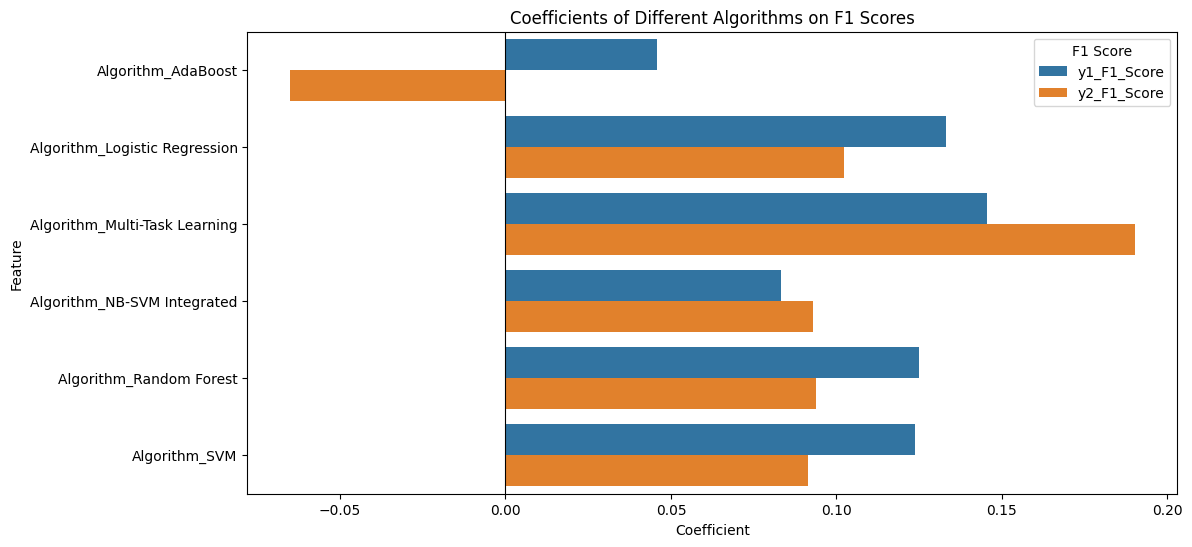

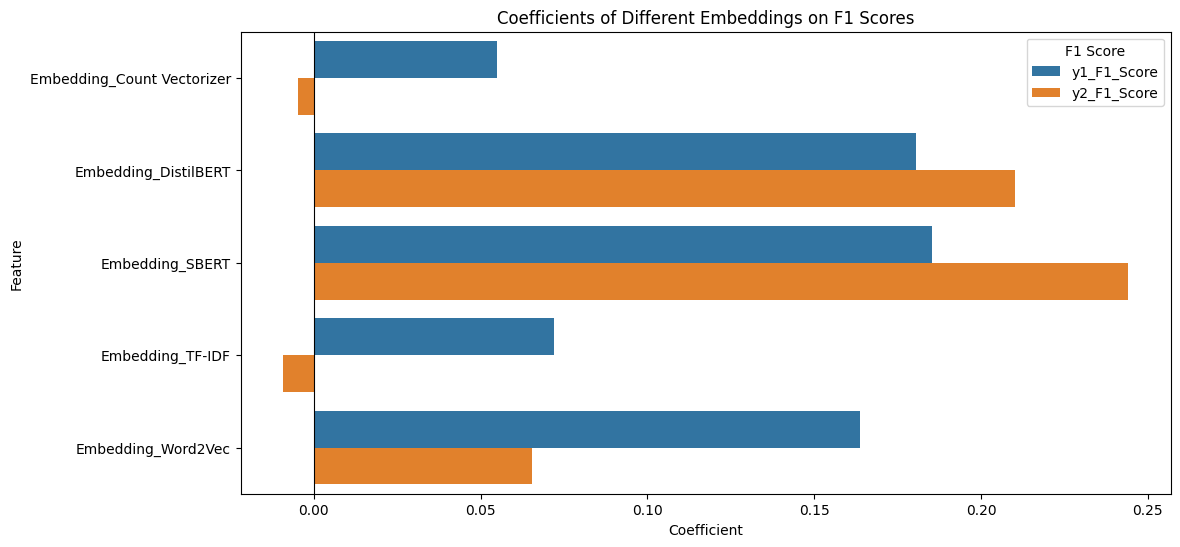

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("results.csv")

# Encoding categorical variables
df_encoded = pd.get_dummies(df, columns=["Algorithm", "Embedding"], drop_first=False)

# Defining independent variables (features) and dependent variables (targets)
X = df_encoded.drop(columns=["y1_F1_Score", "y2_F1_Score", "Type", "y1_Accuracy", "y2_Accuracy", "y1_Precision", "y2_Precision", "y1_Recall", "y2_Recall"])
y1 = df_encoded["y1_F1_Score"]
y2 = df_encoded["y2_F1_Score"]

X = X.astype(float)
Y1 = y1.astype(float)
Y2 = y2.astype(float)

# Adding constant term for linear regression
X = sm.add_constant(X)


# Fitting linear regression model for y1_F1_Score
model_y1 = sm.OLS(y1, X).fit()

# Fitting linear regression model for y2_F1_Score
model_y2 = sm.OLS(y2, X).fit()

# Displaying summary of regression results
print("Linear Regression for y1_F1_Score:\n")
print(model_y1.summary())

print("\nLinear Regression for y2_F1_Score:\n")
print(model_y2.summary())

# Extracting coefficients for plotting
coef_y1 = model_y1.params.drop("const")
coef_y2 = model_y2.params.drop("const")

# Using concat instead of append for creating the DataFrame
coef_df = pd.concat([
    pd.DataFrame({"Feature": coef_y1.index, "Coefficient": coef_y1.values, "F1 Score": "y1_F1_Score"}),
    pd.DataFrame({"Feature": coef_y2.index, "Coefficient": coef_y2.values, "F1 Score": "y2_F1_Score"})
]).reset_index(drop=True)

# Splitting coefficients into separate DataFrames for Algorithm and Embedding
coef_algorithm = coef_df[coef_df["Feature"].str.contains("Algorithm")]
coef_embedding = coef_df[coef_df["Feature"].str.contains("Embedding")]

# Plotting Algorithm Coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x="Coefficient", y="Feature", hue="F1 Score", data=coef_algorithm, dodge=True)
plt.title("Coefficients of Different Algorithms on F1 Scores")
plt.axvline(0, color='black', linewidth=0.8)  # Vertical line at 0 for reference
plt.show()

# Plotting Embedding Coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x="Coefficient", y="Feature", hue="F1 Score", data=coef_embedding, dodge=True)
plt.title("Coefficients of Different Embeddings on F1 Scores")
plt.axvline(0, color='black', linewidth=0.8)  # Vertical line at 0 for reference
plt.show()


## 5. Hyperparameter Tuning & Plotting

In [131]:
# TODO